In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn	# 各种层类型的实现
import torch.nn.functional as F	# 各中层函数的实现，与层类型对应，如：卷积函数、池化函数、归一化函数等等
import torch.optim as optim	# 实现各种优化算法的包
from torchvision import datasets, transforms
import numpy as np

import argparse
import sys


import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt
from grid_data import GridData

from compute_mpe import CircuitMPE
import sys
sys.path.insert(0,'/root/gurobi903/linux64/lib/python3.6_utf32/gurobipy')
import gurobipy
cmpe = CircuitMPE('/root/PySDD/notebooks/yahoo.vtree', '/root/PySDD/notebooks/yahoo.sdd')
class para:
    def __init__(self):
        self.batch_size=16
        self.wmc=10
        self.solDim=24
        self.card=10
        self.test_batch_size=1000
        self.epochs=10
        self.lr=0.1
        self.momentum=0.5
        self.no_cuda='store_true'
        self.seed=1
        self.log_interval=10
        self.hidden_dim=10
args=para()
legalList={0: [13, 18],
 1: [17, 20, 22],
 2: [4, 5, 10, 13, 14, 16, 17, 18, 20, 22],
 3: [5, 9, 11, 12, 15],
 4: [2, 10, 13, 14, 16, 17, 18, 20, 22],
 5: [2, 3, 6, 9, 10, 11, 12, 14, 16],
 6: [5, 15],
 7: [],
 8: [],
 9: [3, 5, 11, 12, 15],
 10: [2, 4, 5, 14, 16, 22],
 11: [3, 5, 9, 12, 15],
 12: [3, 5, 9, 11, 15],
 13: [0, 2, 4, 14, 18, 22],
 14: [2, 4, 5, 10, 13, 16, 17, 18, 20, 22],
 15: [3, 6, 9, 11, 12, 17, 19, 20],
 16: [2, 4, 5, 10, 14, 22],
 17: [1, 2, 4, 14, 15, 19, 20, 22],
 18: [0, 2, 4, 13, 14, 22],
 19: [15, 17, 20],
 20: [1, 2, 4, 14, 15, 17, 19, 22],
 21: [],
 22: [1, 2, 4, 10, 13, 14, 16, 17, 18, 20],
 23: []}
def checkFea(x):
    cnt=0
    cntT=0
    for i in range(len(legalList.keys())):
        for j in legalList[i]:
            cntT+=1
            if x[j]+x[i]>1:
                cnt+=1
    return cnt/cntT/2+abs(x.sum()-args.card)/args.card/2
def CB(alpha,x,M):
    return alpha*np.sqrt(np.dot(np.dot(x.T,np.linalg.inv(M)),x))
def solver(theta,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(theta), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    MODEL.optimize()
    return np.array(MODEL.x)
def solver_quad(Q,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(Q).dot(np.array(variables)), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    
    print('??')
    MODEL.optimize()
    print('??')
    return np.array(MODEL.x)

In [2]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

def inv_sherman_morrison(u, A_inv):
    """Inverse of a matrix with rank 1 update.
    """
    Au = np.dot(A_inv, u)
    A_inv -= np.outer(Au, Au)/(1+np.dot(u.T, Au))
    return A_inv

class Model(nn.Module):
    """Template for fully connected neural network for scalar approximation.
    """
    def __init__(self, 
                 input_size=1, 
                 hidden_size=2,
                 n_layers=1,
                 activation='ReLU',
                 p=0.0,
                ):
        super(Model, self).__init__()
        
        self.n_layers = n_layers
        
        if self.n_layers == 1:
            self.layers = [nn.Linear(input_size, 1)]
        else:
            size  = [input_size] + [hidden_size,] * (self.n_layers-1) + [1]
            self.layers = [nn.Linear(size[i], size[i+1]) for i in range(self.n_layers)]
        self.layers = nn.ModuleList(self.layers)
        
        # dropout layer
        self.dropout = nn.Dropout(p=p)
        
        # activation function
        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'LeakyReLU':
            self.activation = nn.LeakyReLU(negative_slope=0.1)
        else:
            raise Exception('{} not an available activation'.format(activation))
            
    def forward(self, x):
        for i in range(self.n_layers-1):
            x = self.dropout(self.activation(self.layers[i](x)))
        x = self.layers[-1](x)
        return x


In [17]:
import numpy as np
import abc
from tqdm import tqdm

class UCB(abc.ABC):
    """Base class for UBC methods.
    """
    def __init__(self,
                 bandit,
                 reg_factor=1.0,
                 confidence_scaling_factor=-1.0,
                 delta=0.1,
                 train_every=1,
                 throttle=int(1e2),
                ):
        # bandit object, contains features and generated rewards
        self.bandit = bandit
        # L2 regularization strength
        self.reg_factor = reg_factor
        # Confidence bound with probability 1-delta
        self.delta = delta
        # multiplier for the confidence bound (default is bandit reward noise std dev)
        if confidence_scaling_factor == -1.0:
            confidence_scaling_factor = bandit.noise_std
        self.confidence_scaling_factor = confidence_scaling_factor
        
        # train approximator only every few rounds
        self.train_every = train_every
        self.best_recommended_reward =-200
        self.best_recommended_action =np.array([1]*args.card+[0]*(self.bandit.n_features-args.card))
        self.rewards_list=[]
        self.best_sample_rewards_list=[]
        self.feasi=[]
        # throttle tqdm updates
        self.throttle = throttle
        self.solverSol=None
        self.reset()
        
    def reset_upper_confidence_bounds(self):
        """Initialize upper confidence bounds and related quantities.
        """
        self.exploration_bonus = np.empty((self.bandit.T, self.bandit.n_arms))
        self.mu_hat = np.empty((self.bandit.T, self.bandit.n_arms)) 
        self.meta_mu_hat = np.empty(( self.bandit.n_features)) 
        self.cross_mu_hat = np.empty(( self.bandit.n_features**2)) 
        self.upper_confidence_bounds = np.ones((self.bandit.T, self.bandit.n_arms))
        self.meta_values= np.ones((self.bandit.n_features))
        self.cross_values= np.ones((self.bandit.n_features**2))
        self.knn_metabest=-100
        self.best_rewards_oracle=-100
    def reset_regrets(self):
        """Initialize regrets.
        """
        self.regrets = np.empty(self.bandit.T)

    def reset_actions(self):
        """Initialize cache of actions.
        """
        self.actions = np.empty(self.bandit.T).astype('int')
    
    def reset_A_inv(self):
        """Initialize n_arms square matrices representing the inverses
        of exploration bonus matrices.
        """
        self.A_inv = np.array(
            [
                np.eye(self.approximator_dim)/self.reg_factor for _ in self.bandit.arms
            ]
        )
    def reset_grad_approx(self):
        """Initialize the gradient of the approximator w.r.t its parameters.
        """
        self.grad_approx = np.zeros((self.bandit.n_arms, self.approximator_dim))

    def sample_action(self):
        """Return the action to play based on current estimates
        """
        if self.iteration>=max(self.bandit.n_features*4,200):
            return np.argmax(self.upper_confidence_bounds[self.iteration]).astype('int')
        else:
            return np.random.choice(self.bandit.n_arms)
    @abc.abstractmethod
    def reset(self):
        """Initialize variables of interest.
        To be defined in children classes.
        """
        pass

    @property
    @abc.abstractmethod
    def approximator_dim(self):
        """Number of parameters used in the approximator.
        """
        pass
    
    @property
    @abc.abstractmethod
    def confidence_multiplier(self):
        """Multiplier for the confidence exploration bonus.
        To be defined in children classes.
        """
        pass
    
    @abc.abstractmethod
    def update_confidence_bounds(self):
        """Update the confidence bounds for all arms at time t.
        To be defined in children classes.
        """
        pass

    @abc.abstractmethod
    def update_output_gradient(self):
        """Compute output gradient of the approximator w.r.t its parameters.
        """
        pass
    
    @abc.abstractmethod
    def train(self):
        """Update approximator.
        To be defined in children classes.
        """
        pass
    
    @abc.abstractmethod
    def predict(self):
        """Predict rewards based on an approximator.
        To be defined in children classes.
        """
        pass

    def update_confidence_bounds(self):
        """Update confidence bounds and related quantities for all arms.
        """
        
        if self.iteration>max(self.bandit.n_features*4,200):#self.bandit.n_features:
            self.bandit.features[self.iteration][2]=self.best_recommended_action
            self.bandit.features[self.iteration][0]=self.solverSol
            self.bandit.features[self.iteration][1]=self.solverSol_quad
            for j in range(3,self.bandit.n_arms//3):
                tmp=[np.random.beta(min(1-0.1,max(0.1,mm)),1-min(1-0.1,max(0.1,mm))) for mm in self.solverSol]#[self.meta_values[i]+2*np.sqrt(np.log(self.iteration+1)/self.cnt[i]/self.iteration) for i in range(self.bandit.n_features)]
                tmp2=sorted(tmp)[-args.card:] 
                self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            for j in range(n_arms//3,self.bandit.n_arms//2):
                tmp=[np.random.beta(min(1-0.1,max(0.1,mm)),1-min(1-0.1,max(0.1,mm))) for mm in self.solverSol_quad]#[self.meta_values[i]+2*np.sqrt(np.log(self.iteration+1)/self.cnt[i]/self.iteration) for i in range(self.bandit.n_features)]
                tmp2=sorted(tmp)[-args.card:] 
                self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            for j in range(n_arms//2,2*self.bandit.n_arms//3):
                tmp=self.bandit.features[self.iteration][j]+np.random.random()*(self.best_recommended_action-self.bandit.features[self.iteration][j])
                if self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][j]).to(self.device)).detach().squeeze()<self.model.forward(torch.FloatTensor(tmp).to(self.device)).detach().squeeze():
                    tmp2=sorted(tmp)[-args.card:] 
                    self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            if np.random.random()>0.4:
                a=np.random.choice(self.bandit.n_arms)
                b=np.random.choice(self.bandit.n_arms)
                if a!=b:
                    if  self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][a]).to(self.device)).detach().squeeze()>self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][b]).to(self.device)).detach().squeeze():
                        tmp=self.bandit.features[self.iteration][b]+np.random.random()*(a-b)
                        tmp2=sorted(tmp)[-args.card:] 
                        self.bandit.features[self.iteration][b]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))

        self.update_output_gradient()
        # UCB exploration bonus
        self.exploration_bonus[self.iteration] = np.array(
            [
                500000*constraint(self.bandit.features[self.iteration][a])+self.confidence_multiplier * np.sqrt(np.dot(self.grad_approx[a], np.dot(self.A_inv[a], self.grad_approx[a].T))) for a in self.bandit.arms
            ]
        ) #500000*constraint(self.bandit.features[self.iteration][a])+
        # update reward prediction mu_hat
        self.predict()
        self.bandit.rewards[self.iteration]=np.array([self.bandit.h(self.bandit.features[self.iteration, k],self.iteration) + self.bandit.noise_std*np.random.randn() for k in range(self.bandit.n_arms)])
        self.bandit.rewards2[self.iteration]=np.array([self.bandit.hwithoutconstraints(self.bandit.features[self.iteration, k]) + self.bandit.noise_std*np.random.randn() for k in range(self.bandit.n_arms)])

        # estimated combined bound for reward
        self.meta_values=self.meta_mu_hat# + self.meta_exploration_bonus[self.iteration] 
        if self.iteration>=max(self.bandit.n_features*4,200):
            self.cross_values=self.cross_mu_hat
            for i in range(self.bandit.n_features):
                for j in range(self.bandit.n_features):
                    if i==j:
                        self.cross_values[i*self.bandit.n_features+j]=self.meta_mu_hat[i]
                    else:
                        self.cross_values[i*self.bandit.n_features+j]=(self.cross_mu_hat[i*self.bandit.n_features+j]-self.meta_mu_hat[i]-self.meta_mu_hat[j])/2
            self.cross_values=self.cross_values.reshape(self.bandit.n_features,self.bandit.n_features)
        with gurobipy.Env(empty=True) as env:
            env.setParam('OutputFlag', 0)
            env.setParam('IterationLimit',600)
            env.start()
            with gurobipy.Model(env=env) as m:
                self.solverSol=np.divide(solver(self.meta_values,m),np.sqrt(args.card))
        if self.iteration>=max(self.bandit.n_features*4,200):
            with gurobipy.Env(empty=True) as env:
                env.setParam('OutputFlag', 0)
                env.setParam('IterationLimit',600)
                env.start()
                with gurobipy.Model(env=env) as m:
                    self.solverSol_quad=np.divide(solver_quad(self.cross_values,m),np.sqrt(args.card))
                    print('solverSol_quad',self.bandit.hwithoutconstraints(self.solverSol_quad))
        tmp=sorted(self.meta_values )[-args.card:]   #后面记得加/改一下探索项！！！
        self.meta_values = np.array([1 if self.meta_values[i] in tmp else 0 for i in range(self.bandit.n_features)])
        if len(np.argwhere(self.meta_values==1)):
            metabest=np.argwhere(self.meta_values==1)[:args.card].reshape(args.card)
        else:
            metabest=list(range(self.bandit.n_features))
            np.random.shuffle(metabest)
            metabest=np.array(metabest[:args.card])
        knn_metabest={}
        import copy
        for i in range(10):
            tmp=metabest.copy()
            tmp[np.random.choice(range(args.card))]=np.random.choice(range(self.bandit.n_features))
            tmp=np.divide(np.array([1 if i in tmp else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            tmpvalue=self.model.forward(
                    torch.FloatTensor(tmp).to(self.device)
                ).detach().squeeze()
            knn_metabest[tmpvalue]=tmp
        
        self.meta_values=np.divide(self.meta_values,np.sqrt(args.card))
        self.upper_confidence_bounds[self.iteration] = self.mu_hat[self.iteration] + self.exploration_bonus[self.iteration]
        self.knn_metabest=knn_metabest[max(knn_metabest.keys())]
        self.bandit.knn_metabestValue =self.bandit.h(self.knn_metabest,self.iteration)
        self.bandit.best_rewards_oracle =max( max(np.max(self.bandit.rewards, axis=1)),self.bandit.knn_metabestValue)
        self.best_rewards_oracle=max(max(self.best_rewards_oracle,self.bandit.best_rewards_oracle),self.bandit.hwithoutconstraints(self.knn_metabest))
        print('----------------',self.best_rewards_oracle,self.bandit.hwithoutconstraints(self.knn_metabest),checkFea(torch.from_numpy(self.knn_metabest)*np.sqrt(args.card)),self.bandit.hwithoutconstraints(self.solverSol),checkFea(np.sqrt(args.card)*torch.from_numpy(self.solverSol)))
    def update_A_inv(self):
        self.A_inv[self.action] = inv_sherman_morrison(
            self.grad_approx[self.action],
            self.A_inv[self.action]
        )
    def run(self):
        """Run an episode of bandit.
        """
        postfix = {
            'total regret': 0.0,
            '% optimal arm': 0.0,
        }
        with tqdm(total=self.bandit.T, postfix=postfix) as pbar:
            for t in range(self.bandit.T):
                # update confidence of all arms based on observed features at time t
                self.update_confidence_bounds()
                # pick action with the highest boosted estimated reward
                self.action = self.sample_action()
                self.actions[t] = self.action
                # update approximator
                if t % self.train_every == 0:
                    self.train()
                # update exploration indicator A_inv
                self.update_A_inv()
                # compute regret
                
                #print(t,self.action,self.bandit.best_rewards_oracle[t],self.bandit.rewards[t, self.action])
                print('hhhhh',self.bandit.hwithoutconstraints(self.bandit.features[self.iteration][self.action]),np.sqrt(args.card)*sum(self.bandit.features[self.iteration][self.action]),checkFea(torch.from_numpy(self.bandit.features[self.iteration][self.action])*np.sqrt(args.card)))
                self.regrets[t] = self.best_rewards_oracle-self.bandit.h(self.bandit.features[self.iteration][self.action],self.iteration)
                if self.best_recommended_reward<self.bandit.h(self.bandit.features[self.iteration][self.action],self.iteration):
                    self.best_recommended_reward=self.bandit.h(self.bandit.features[self.iteration][self.action],self.iteration)
                    self.best_recommended_action=self.bandit.features[self.iteration][self.action]
                self.best_sample_rewards_list.append( self.best_rewards_oracle)
                self.rewards_list.append(self.bandit.hwithoutconstraints(self.bandit.features[self.iteration][self.action]))
                self.feasi.append(checkFea(self.bandit.features[self.iteration][self.action]*np.sqrt(args.card)))
                # increment counter
                self.iteration += 1
                
                # log
                postfix['total regret'] += self.regrets[t]
                n_optimal_arm = np.sum(
                    self.actions[:self.iteration]==self.bandit.best_actions_oracle[:self.iteration]
                )
                postfix['% optimal arm'] = '{:.2%}'.format(n_optimal_arm / self.iteration)
                
                if t % self.throttle == 0:
                    pbar.set_postfix(postfix)
                    pbar.update(self.throttle)


In [18]:
import numpy as np
import itertools


class ContextualBandit():
    def __init__(self,
                 T,
                 n_arms,
                 n_features,
                 h,
                 hwithoutconstraints,
                 noise_std=1.0,
                ):
        # number of rounds
        self.T = T
        # number of arms
        self.n_arms = n_arms
        # number of features for each arm
        self.n_features = n_features
        # average reward function
        # h : R^d -> R
        self.h = h
        self.hwithoutconstraints=hwithoutconstraints
        self.knn_metabestValue=-100
        self.best_rewards_oracle = -100
        # standard deviation of Gaussian reward noise
        self.noise_std = noise_std
        # generate random features
        print('44-------------')
        self.reset()

    @property
    def arms(self):
        """Return [0, ...,n_arms-1]
        """
        return range(self.n_arms)
        
    def reset(self):
        """Generate new features and new rewards.
        """
        print('55-------------')
        self.reset_features()
        print('66-------------')
        self.reset_rewards()
        
    def reset_features(self):
        """Generate normalized random N(0,1) features.
        """
        x1,x2=[],[]
        for i in range(self.T):
            tmp1,tmp2=[],[]
            for j in range(self.n_arms):
                a=np.array([0]*(self.n_features-args.card)+[1]*args.card)
                np.random.shuffle(a)
                a=np.divide(a,np.sqrt(args.card))
                tmp1.append(a)
            for j in range(self.n_features):
                a=np.array([0.0]*j+[1.0]+[0.0]*(self.n_features-j-1))
                tmp2.append(a)
            x1.append(tmp1)
            x2.append(tmp2)
        x1,x2=np.array(x1),np.array(x2)
        #x /= np.repeat(np.linalg.norm(x, axis=-1, ord=2), self.n_features).reshape(self.T, self.n_arms, self.n_features)
        self.features = x1
        self.meta_features=x2
        self.cross_features=[]
        for i in range(self.n_features):
            for j in range(self.n_features):
                tmp=np.zeros(self.n_features)
                tmp[i]=1
                tmp[j]=1
                self.cross_features.append(tmp)
                
    def reset_rewards(self):
        """Generate rewards for each arm and each round,
        following the reward function h + Gaussian noise.
        """
        
        self.rewards = np.random.random([self.T, self.n_arms])
        self.rewards2 = np.random.random([self.T, self.n_arms])
        
        # to be used only to compute regret, NOT by the algorithm itself
        self.best_rewards_oracle =max( max(np.max(self.rewards, axis=1)),self.knn_metabestValue)
        self.best_actions_oracle = np.argmax(self.rewards, axis=1)


In [5]:
import numpy as np
import torch
import torch.nn as nn

class NeuralUCB(UCB):
    """Neural UCB.
    """
    def __init__(self,
                 bandit,
                 hidden_size=20,
                 n_layers=2,
                 reg_factor=1.0,
                 delta=0.01,
                 confidence_scaling_factor=-1.0,
                 training_window=100,
                 p=0.0,
                 learning_rate=0.01,
                 epochs=1,
                 train_every=1,
                 throttle=1,
                 use_cuda=False,
                ):

        # hidden size of the NN layers
        self.hidden_size = hidden_size
        # number of layers
        self.n_layers = n_layers
        
        # number of rewards in the training buffer
        self.training_window = training_window
        
        # NN parameters
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        self.use_cuda = use_cuda
        if self.use_cuda:
            raise Exception(
                'Not yet CUDA compatible : TODO for later (not necessary to obtain good results')
        self.device = torch.device('cuda' if torch.cuda.is_available() and self.use_cuda else 'cpu')
    
        # dropout rate
        self.p = p

        # neural network
        self.model = Model(input_size=bandit.n_features, 
                           hidden_size=self.hidden_size,
                           n_layers=self.n_layers,
                           p=self.p
                          ).to(self.device)
        self.model2 = Model(input_size=bandit.n_features, 
                           hidden_size=self.hidden_size,
                           n_layers=self.n_layers,
                           p=self.p
                          ).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.optimizer2 = torch.optim.Adam(self.model2.parameters(), lr=self.learning_rate)

        super().__init__(bandit, 
                         reg_factor=reg_factor,
                         confidence_scaling_factor=confidence_scaling_factor,
                         delta=delta,
                         throttle=throttle,
                         train_every=train_every,
                        )

    @property
    def approximator_dim(self):
        """Sum of the dimensions of all trainable layers in the network.
        """
        return sum(w.numel() for w in self.model.parameters() if w.requires_grad)
    
    @property
    def confidence_multiplier(self):
        """Constant equal to confidence_scaling_factor
        """
        return self.confidence_scaling_factor
    
    def update_output_gradient(self):
        """Get gradient of network prediction w.r.t network weights.
        """
        for a in self.bandit.arms:
            x = torch.FloatTensor(
                self.bandit.features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model.zero_grad()
            y = self.model(x)
            y.backward()
            
            self.grad_approx[a] = torch.cat(
                [w.grad.detach().flatten() / np.sqrt(self.hidden_size) for w in self.model.parameters() if w.requires_grad]
            ).to(self.device)
        for a in range(self.bandit.n_features):
            x = torch.FloatTensor(
                self.bandit.meta_features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model.zero_grad()
            y = self.model(x)
            y.backward()
        for a in self.bandit.arms:
            x = torch.FloatTensor(
                self.bandit.features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model2.zero_grad()
            y = self.model2(x)
            y.backward()

        for a in range(self.bandit.n_features):
            x = torch.FloatTensor(
                self.bandit.meta_features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model2.zero_grad()
            y = self.model2(x)
            y.backward()
            
    def reset(self):
        """Reset the internal estimates.
        """
        self.reset_upper_confidence_bounds()
        self.reset_regrets()
        self.reset_actions()
        self.reset_A_inv()
        self.reset_grad_approx()
        self.iteration = 0

    def train(self):
        """Train neural approximator.
        """
        iterations_so_far = range(np.max([0, self.iteration-self.training_window]), self.iteration+1)
        actions_so_far = self.actions[np.max([0, self.iteration-self.training_window]):self.iteration+1]

        x_train = torch.FloatTensor(self.bandit.features[iterations_so_far, actions_so_far]).to(self.device)
        y_train = torch.FloatTensor(self.bandit.rewards[iterations_so_far, actions_so_far]).squeeze().to(self.device)
        y_train2 = torch.FloatTensor(self.bandit.rewards2[iterations_so_far, actions_so_far]).squeeze().to(self.device)
        
        # train mode
        self.model.train()
        for _ in range(self.epochs):
            y_pred = self.model.forward(x_train).squeeze()
            loss = nn.MSELoss()(y_train2, y_pred)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        self.model2.train()
        for _ in range(self.epochs):
            y_pred = self.model2.forward(x_train).squeeze()
            loss = nn.MSELoss()(y_train2, y_pred)
            self.optimizer2.zero_grad()
            loss.backward()
            self.optimizer2.step()
        
        
    def predict(self):
        """Predict reward.
        """
        # eval mode
        self.model.eval()
        self.mu_hat[self.iteration] = self.model.forward(
            torch.FloatTensor(self.bandit.features[self.iteration]).to(self.device)
        ).detach().squeeze()
        self.meta_mu_hat = self.model2.forward(
            torch.FloatTensor(self.bandit.meta_features[self.iteration]).to(self.device)
        ).detach().squeeze()
        if self.iteration>=max(self.bandit.n_features*4,200):
            self.cross_mu_hat= self.model2.forward(
                torch.FloatTensor(self.bandit.cross_features).to(self.device)
            ).detach().squeeze()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [7]:
T = int(12e2)
n_arms =5
n_features = 24
noise_std = 0.1

confidence_scaling_factor = noise_std

n_sim = 1

p = 0.2
hidden_size = 4#16
epochs = 100#100
train_every = 10#10
confidence_scaling_factor = 1.0
use_cuda = False

In [10]:
### mean reward function

a = np.random.random(24) #  np.load('rateListUsersYahoo.npy')[0]
a /= np.linalg.norm(a, ord=2)
Q=np.random.random([24,24]) #np.load('Q.npy')#Q=np.random.random([n_features,n_features])+100*np.diag(np.ones(n_features))
#h = lambda x:   100*a.dot(Q).dot(a)   #min(100*(np.dot(a, x)**(5)),10000)
#100*a.dot(Q).dot(a)
def h(x,iteration):
    yu=torch.unbind(torch.from_numpy(x))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*n_features).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    return  50000*(1/(1+np.exp(-iteration))-0.5)*torch.log(torch.mean(wmc)).float()+100*(x.dot(a))**3 
def constraint(x):
    yu=torch.unbind(torch.from_numpy(x))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*n_features).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    return  50000*torch.log(torch.mean(wmc)).float()
hwithoutconstraints = lambda x:100*(x.dot(a))**3    #100*(x.dot(a))**3  、100*x.dot(Q).dot(x)

In [11]:
with gurobipy.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('IterationLimit',600)
        env.start()
        with gurobipy.Model(env=env) as m:
            action=solver(a,m)
hwithoutconstraints(action)/(np.sqrt(args.card))**3

30.457828816147085

In [12]:
with gurobipy.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('IterationLimit',600)
        env.start()
        with gurobipy.Model(env=env) as m:
            action2=solver_quad(Q,m)
hwithoutconstraints(action2)/10

??
??


53.116462237722736

In [14]:
bandit = ContextualBandit(T, n_arms, n_features, h,hwithoutconstraints, noise_std=noise_std)

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda
                     )
        
    model.run()
    regrets[i] = np.cumsum(model.regrets)

44-------------
55-------------


  0%|          | 0/1200 [00:00<?, ?it/s, % optimal arm=0, total regret=0]

66-------------
---------------- tensor(24.7312) 24.731213122048256 tensor(0.0873, dtype=torch.float64) 16.91744431638874 tensor(0., dtype=torch.float64)


  0%|          | 2/1200 [00:00<04:50,  4.12it/s, total regret=1.42e+4, % optimal arm=100.00%]

hhhhh 7.4655940665864575 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- tensor(24.7312) 15.981382141234402 tensor(0.0873, dtype=torch.float64) 16.91744431638874 tensor(0., dtype=torch.float64)
hhhhh 21.0224861462967 10.000000000000002 tensor(0.1587, dtype=torch.float64)


  0%|          | 4/1200 [00:00<03:26,  5.78it/s, total regret=5.34e+4, % optimal arm=50.00%] 

---------------- tensor(24.7312) 7.314622728605921 tensor(0.0635, dtype=torch.float64) 15.826146913661551 tensor(0., dtype=torch.float64)
hhhhh 32.1607259890862 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- tensor(24.7312) 11.969189597167546 tensor(0.1056, dtype=torch.float64) 22.752159114230828 tensor(0., dtype=torch.float64)
hhhhh 36.87580913134876 10.000000000000002 tensor(0.1508, dtype=torch.float64)


  0%|          | 6/1200 [00:00<02:47,  7.12it/s, total regret=1.07e+5, % optimal arm=33.33%]

---------------- tensor(24.7312) 6.400020229286218 tensor(0.0897, dtype=torch.float64) 16.91744431638874 tensor(0., dtype=torch.float64)
hhhhh 16.230795472850005 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- tensor(24.7312) 5.744335243849254 tensor(0.0976, dtype=torch.float64) 15.995222211878987 tensor(0., dtype=torch.float64)
hhhhh 17.265959171127147 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  1%|          | 8/1200 [00:01<02:31,  7.85it/s, total regret=1.57e+5, % optimal arm=25.00%]

---------------- tensor(24.7312) 7.661894623503438 tensor(0.1294, dtype=torch.float64) 19.39492342105116 tensor(0., dtype=torch.float64)
hhhhh 18.02085513957542 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- tensor(24.7312) 14.367114411899331 tensor(0.0635, dtype=torch.float64) 22.752159114230828 tensor(0., dtype=torch.float64)
hhhhh 17.84617554625426 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  1%|          | 10/1200 [00:01<02:31,  7.83it/s, total regret=1.97e+5, % optimal arm=30.00%]

---------------- tensor(24.7312) 7.005508144821926 tensor(0.0817, dtype=torch.float64) 15.995222211878987 tensor(0., dtype=torch.float64)
hhhhh 19.375422898159343 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- tensor(24.7312) 10.426305596086369 tensor(0.0817, dtype=torch.float64) 15.995222211878987 tensor(0., dtype=torch.float64)
hhhhh 24.239743935393427 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- tensor(24.7312) 14.734507543624531 tensor(0.0317, dtype=torch.float64) 19.39492342105116 tensor(0., dtype=torch.float64)


  1%|          | 12/1200 [00:01<03:29,  5.67it/s, total regret=2.46e+5, % optimal arm=25.00%]

hhhhh 8.704762820676185 10.000000000000002 tensor(0.1111, dtype=torch.float64)
---------------- tensor(24.7312) 14.81455743517677 tensor(0.1294, dtype=torch.float64) 19.109088524397304 tensor(0., dtype=torch.float64)
hhhhh 22.05502229740125 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  1%|          | 14/1200 [00:02<02:49,  7.02it/s, total regret=2.95e+5, % optimal arm=28.57%]

---------------- tensor(24.7312) 20.653641850142908 tensor(0.1452, dtype=torch.float64) 19.109088524397304 tensor(0., dtype=torch.float64)
hhhhh 30.978751483630933 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 39.74821467888787 39.74821467888787 tensor(0.0952, dtype=torch.float64) 22.752159114230828 tensor(0., dtype=torch.float64)
hhhhh 14.082762208991987 10.000000000000002 tensor(0.1349, dtype=torch.float64)


  1%|▏         | 16/1200 [00:02<02:41,  7.33it/s, total regret=3.34e+5, % optimal arm=25.00%]

---------------- 39.74821467888787 28.59003912622431 tensor(0.1270, dtype=torch.float64) 19.109088524397304 tensor(0., dtype=torch.float64)
hhhhh 19.805520148695322 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 39.74821467888787 16.520113716176077 tensor(0.1032, dtype=torch.float64) 16.07068825027324 tensor(0., dtype=torch.float64)
hhhhh 15.122051318217563 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  2%|▏         | 18/1200 [00:02<02:26,  8.07it/s, total regret=3.89e+5, % optimal arm=22.22%]

---------------- 39.74821467888787 25.961520211506507 tensor(0.1349, dtype=torch.float64) 19.109088524397304 tensor(0., dtype=torch.float64)
hhhhh 18.91509583815282 10.000000000000002 tensor(0.1429, dtype=torch.float64)
---------------- 39.74821467888787 29.952489586433085 tensor(0.1270, dtype=torch.float64) 19.923493843782015 tensor(0., dtype=torch.float64)
hhhhh 10.026985912302004 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  2%|▏         | 19/1200 [00:02<02:24,  8.17it/s, total regret=4.48e+5, % optimal arm=20.00%]

---------------- 39.74821467888787 24.6379722710177 tensor(0.1032, dtype=torch.float64) 19.109088524397304 tensor(0., dtype=torch.float64)
hhhhh 11.467176038544004 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 39.74821467888787 24.942856532479734 tensor(0.1294, dtype=torch.float64) 18.918687858419986 tensor(0., dtype=torch.float64)
hhhhh 10.01218712173855 10.000000000000002 tensor(0.1667, dtype=torch.float64)


  2%|▏         | 20/1200 [00:02<02:47,  7.05it/s, total regret=4.48e+5, % optimal arm=20.00%]

---------------- 39.74821467888787 16.32818868387213 tensor(0.1135, dtype=torch.float64) 19.109088524397304 tensor(0., dtype=torch.float64)


  2%|▏         | 22/1200 [00:03<03:32,  5.54it/s, total regret=4.93e+5, % optimal arm=18.18%]

hhhhh 19.062918099237127 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 39.74821467888787 30.657254079570357 tensor(0.1452, dtype=torch.float64) 20.01084867350664 tensor(0., dtype=torch.float64)
hhhhh 11.397766240696102 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  2%|▏         | 24/1200 [00:03<02:50,  6.91it/s, total regret=5.24e+5, % optimal arm=16.67%]

---------------- 39.74821467888787 25.466021854402914 tensor(0.1214, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 15.226410802742258 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 55.65259998699005 55.65259998699005 tensor(0.1111, dtype=torch.float64) 25.788623181566052 tensor(0., dtype=torch.float64)
hhhhh 25.83782021706679 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  2%|▏         | 26/1200 [00:03<02:29,  7.88it/s, total regret=5.6e+5, % optimal arm=15.38%] 

---------------- 55.65259998699005 21.540170375857137 tensor(0.1349, dtype=torch.float64) 19.923493843782015 tensor(0., dtype=torch.float64)
hhhhh 28.64445877636088 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 55.65259998699005 16.788086730524434 tensor(0.1690, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 13.812589033299014 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  2%|▏         | 28/1200 [00:04<02:39,  7.35it/s, total regret=5.98e+5, % optimal arm=14.29%]

---------------- 55.65259998699005 35.39639534710578 tensor(0.1032, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 14.081765401595167 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- 55.65259998699005 32.93857865818031 tensor(0.1111, dtype=torch.float64) 19.923493843782015 tensor(0., dtype=torch.float64)
hhhhh 19.609720489208886 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  2%|▎         | 30/1200 [00:04<02:36,  7.50it/s, total regret=6.41e+5, % optimal arm=16.67%]

---------------- 55.65259998699005 41.59952342682284 tensor(0.1214, dtype=torch.float64) 19.727712112511416 tensor(0., dtype=torch.float64)
hhhhh 20.282805417814632 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 55.65259998699005 20.995312408212975 tensor(0.0714, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 19.122727555876757 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 55.65259998699005 36.234031767038765 tensor(0.1135, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 12.404616646402438 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  3%|▎         | 33/1200 [00:04<02:52,  6.76it/s, total regret=7e+5, % optimal arm=15.15%]   

---------------- 55.65259998699005 36.22289441265277 tensor(0.1135, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 17.694050359053573 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 55.65259998699005 31.0652274461667 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 12.877193825855054 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  3%|▎         | 35/1200 [00:05<02:51,  6.81it/s, total regret=7.41e+5, % optimal arm=17.14%]

---------------- 55.65259998699005 38.0648653697498 tensor(0.1349, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 27.71800873259251 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 57.38668393954354 57.38668393954354 tensor(0.0794, dtype=torch.float64) 22.95502337661478 tensor(0., dtype=torch.float64)
hhhhh 27.573090111354958 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  3%|▎         | 36/1200 [00:05<03:03,  6.33it/s, total regret=7.57e+5, % optimal arm=16.67%]

---------------- 57.38668393954354 28.906264959688567 tensor(0.1056, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 55.01454874465781 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 57.38668393954354 35.869939053034464 tensor(0.1190, dtype=torch.float64) 25.5560292640124 tensor(0., dtype=torch.float64)
hhhhh 28.621689891326717 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  3%|▎         | 38/1200 [00:05<03:17,  5.90it/s, total regret=7.95e+5, % optimal arm=18.42%]

---------------- 57.38668393954354 27.43631653041742 tensor(0.1690, dtype=torch.float64) 25.5560292640124 tensor(0., dtype=torch.float64)
hhhhh 19.42938647767044 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 57.38668393954354 26.49259526364427 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 18.775533450002097 10.000000000000002 tensor(0.0238, dtype=torch.float64)


  3%|▎         | 40/1200 [00:06<03:28,  5.58it/s, total regret=8.33e+5, % optimal arm=20.00%]

---------------- 57.38668393954354 28.214390503013853 tensor(0.1373, dtype=torch.float64) 25.5560292640124 tensor(0., dtype=torch.float64)
hhhhh 28.059671528896036 10.000000000000002 tensor(0.1111, dtype=torch.float64)
---------------- 57.38668393954354 28.23204459001864 tensor(0.1532, dtype=torch.float64) 25.5560292640124 tensor(0., dtype=torch.float64)


  3%|▎         | 41/1200 [00:06<05:22,  3.59it/s, total regret=8.49e+5, % optimal arm=19.51%]

hhhhh 29.006402745369492 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 57.38668393954354 41.14685186846198 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 10.90441849006329

  4%|▎         | 42/1200 [00:06<04:55,  3.92it/s, total regret=8.73e+5, % optimal arm=19.05%]

 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 57.38668393954354 23.732219707617705 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 40.05478219643124 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  4%|▎         | 44/1200 [00:07<04:09,  4.64it/s, total regret=9.17e+5, % optimal arm=18.18%]

---------------- 57.38668393954354 35.01408253460014 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 9.935404866361862 10.000000000000002 tensor(0.0317, dtype=torch.float64)
---------------- 57.38668393954354 42.71384706462399 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 19.318107101565058 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  4%|▍         | 47/1200 [00:07<03:31,  5.44it/s, total regret=9.91e+5, % optimal arm=19.15%]

---------------- 57.38668393954354 39.85996835131059 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 15.931255833298746 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 57.38668393954354 40.81751480508353 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 21.15087532482392 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  4%|▍         | 48/1200 [00:07<03:33,  5.40it/s, total regret=1.01e+6, % optimal arm=20.83%]

---------------- 57.38668393954354 33.74208166642505 tensor(0.1056, dtype=torch.float64) 25.788623181566052 tensor(0., dtype=torch.float64)
hhhhh 16.643951715330115 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 57.38668393954354 50.11507333911894 tensor(0.0873, dtype=torch.float64) 25.788623181566052 tensor(0., dtype=torch.float64)
hhhhh 14.877620025372057 10.000000000000002 tensor(0.0317, dtype=torch.float64)

  4%|▍         | 49/1200 [00:08<03:38,  5.26it/s, total regret=1.03e+6, % optimal arm=20.41%]


---------------- 57.38668393954354 37.20249907981317 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh

  4%|▍         | 50/1200 [00:08<03:39,  5.24it/s, total regret=1.05e+6, % optimal arm=20.00%]

 10.07185490686675 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 57.38668393954354 27.208106593857252 tensor(0.1532, dtype=torch.float64) 25.788623181566052 tensor(0., dtype=torch.float64)


  4%|▍         | 51/1200 [00:08<06:07,  3.13it/s, total regret=1.07e+6, % optimal arm=19.61%]

hhhhh 16.982848386481773 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  4%|▍         | 52/1200 [00:09<05:21,  3.57it/s, total regret=1.1e+6, % optimal arm=19.23%] 

---------------- 57.38668393954354 50.91391553468624 tensor(0.1032, dtype=torch.float64) 25.5560292640124 tensor(0., dtype=torch.float64)
hhhhh 19.191688622543197 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 57.38668393954354 55.463327408912214 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 6.714727366015717 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  4%|▍         | 54/1200 [00:09<04:25,  4.31it/s, total regret=1.14e+6, % optimal arm=18.52%]

---------------- 57.38668393954354 47.627406276695524 tensor(0.1508, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 15.52008540408876 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  5%|▍         | 55/1200 [00:09<04:41,  4.07it/s, total regret=1.16e+6, % optimal arm=18.18%]

---------------- 57.38668393954354 48.79593099567073 tensor(0.1111, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 26.820047265558156 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  5%|▍         | 56/1200 [00:09<04:43,  4.03it/s, total regret=1.18e+6, % optimal arm=17.86%]

---------------- 57.38668393954354 34.28987528509879 tensor(0.1532, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 26.772835571787805 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 57.38668393954354 33.32773002769235 tensor(0.1111, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 14.391100630099304 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  5%|▍         | 59/1200 [00:10<03:52,  4.91it/s, total regret=1.25e+6, % optimal arm=16.95%]

---------------- 57.38668393954354 51.84140491385703 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 21.95056940563984 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 57.38668393954354 37.911450786440234 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 14.81303269989549 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  5%|▌         | 60/1200 [00:10<04:04,  4.67it/s, total regret=1.27e+6, % optimal arm=16.67%]

---------------- 57.38668393954354 35.42851897727202 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 13.424933719890287 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 57.38668393954354 34.56895611360255 tensor(0.0714, dtype=torch.float64) 25.788623181566052 tensor(0., dtype=torch.float64)


  5%|▌         | 61/1200 [00:11<05:04,  3.74it/s, total regret=1.29e+6, % optimal arm=16.39%]

hhhhh 10.235417926435373 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 57.38668393954354 51.24442331539786 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 

  5%|▌         | 62/1200 [00:11<04:41,  4.04it/s, total regret=1.31e+6, % optimal arm=17.74%]

16.288925994757435 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 57.38668393954354 38.28691867865242 tensor(0.1294, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 32.604194156130504 10.000000000000002 tensor(0.1508, dtype=torch.float64)


  5%|▌         | 65/1200 [00:11<03:54,  4.85it/s, total regret=1.38e+6, % optimal arm=16.92%]

---------------- 57.38668393954354 38.583334839903024 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 8.084496701010748 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 57.38668393954354 43.006877792406414 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 23.63503650240768 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  6%|▌         | 66/1200 [00:12<03:44,  5.04it/s, total regret=1.4e+6, % optimal arm=16.67%] 

---------------- 57.38668393954354 42.42543555522224 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 16.247745364159105 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  6%|▌         | 67/1200 [00:12<03:48,  4.96it/s, total regret=1.42e+6, % optimal arm=16.42%]

---------------- 57.38668393954354 41.77379135260063 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 10.867313257197186 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 57.38668393954354 37.544025759789434 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 22.322048122061723 10.000000000000002 

  6%|▌         | 68/1200 [00:12<03:45,  5.01it/s, total regret=1.44e+6, % optimal arm=16.18%]

tensor(0.0873, dtype=torch.float64)


  6%|▌         | 69/1200 [00:12<03:59,  4.71it/s, total regret=1.46e+6, % optimal arm=15.94%]

---------------- 57.38668393954354 43.50579465010405 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 18.106490333147068 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 57.38668393954354 53.81546827077679 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 32.79777543202828 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  6%|▌         | 70/1200 [00:12<03:53,  4.84it/s, total regret=1.48e+6, % optimal arm=15.71%]

---------------- 57.38668393954354 41.932831965424576 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


  6%|▌         | 71/1200 [00:13<05:05,  3.69it/s, total regret=1.5e+6, % optimal arm=16.90%] 

hhhhh 13.90550152223155 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 57.38668393954354 43.83906098348943 tensor(0.1690, dtype=torch.float64) 

  6%|▌         | 72/1200 [00:13<04:44,  3.97it/s, total regret=1.53e+6, % optimal arm=18.06%]

30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 14.931736644475729 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 57.38668393954354

  6%|▌         | 73/1200 [00:13<04:27,  4.21it/s, total regret=1.55e+6, % optimal arm=17.81%]

 42.42543555522224 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 7.97828792766839 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 57.38668393954354 35.85457604414317 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 36.81264299464949 10.000000000000002 

  6%|▌         | 74/1200 [00:13<04:12,  4.46it/s, total regret=1.57e+6, % optimal arm=17.57%]

tensor(0.0794, dtype=torch.float64)
---------------- 57.38668393954354 44.03504300108298 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 13.965292151939012 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  6%|▋         | 77/1200 [00:14<03:37,  5.16it/s, total regret=1.63e+6, % optimal arm=18.18%]

---------------- 57.38668393954354 39.778541791874176 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 11.00478103873581 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 57.38668393954354 53.44812346973094 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 24.600830696403616 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  7%|▋         | 79/1200 [00:14<02:49,  6.60it/s, total regret=1.66e+6, % optimal arm=17.72%]

---------------- 57.38668393954354 37.99793990578191 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 16.516724562854197 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 57.38668393954354 50.3023194013186 tensor(0.1508, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 9.750501427194209 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  7%|▋         | 80/1200 [00:14<02:33,  7.28it/s, total regret=1.68e+6, % optimal arm=17.50%]

---------------- 57.38668393954354 32.228403208885304 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 28.083619462766755 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 57.38668393954354 50.58930570852363 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


  7%|▋         | 81/1200 [00:15<04:09,  4.49it/s, total regret=1.71e+6, % optimal arm=17.28%]

hhhhh 23.986335611080875 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  7%|▋         | 82/1200 [00:15<04:31,  4.12it/s, total regret=1.73e+6, % optimal arm=17.07%]

---------------- 57.38668393954354 52.79466045151481 tensor(0.0317, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 22.27997759665578 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  7%|▋         | 83/1200 [00:15<04:17,  4.34it/s, total regret=1.75e+6, % optimal arm=16.87%]

---------------- 57.38668393954354 46.25195186544085 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 25.237306635971578 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  7%|▋         | 84/1200 [00:15<04:10,  4.46it/s, total regret=1.77e+6, % optimal arm=16.67%]

---------------- 57.38668393954354 53.60480556863331 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 18.168697656139475 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  7%|▋         | 85/1200 [00:16<04:06,  4.53it/s, total regret=1.79e+6, % optimal arm=16.47%]

---------------- 57.38668393954354 57.05869977269612 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 34.55883756028999 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 57.38668393954354 50.86841396454105 tensor(0.1190, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


  7%|▋         | 86/1200 [00:16<04:00,  4.64it/s, total regret=1.82e+6, % optimal arm=17.44%]

hhhhh 19.790671409426942 10.000000000000002 tensor(0.1190, dtype=torch.float64)
---------------- 57.38668393954354 40.89085407128707 tensor(0.0976, dtype=torch.float64) 30.212808616174048 

  7%|▋         | 88/1200 [00:16<03:43,  4.97it/s, total regret=1.85e+6, % optimal arm=17.05%]

tensor(0., dtype=torch.float64)
hhhhh 16.960650950220618 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 57.38668393954354 40.65076288147029 tensor(0.0952, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 13.245583674623212 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  7%|▋         | 89/1200 [00:16<03:12,  5.78it/s, total regret=1.86e+6, % optimal arm=16.85%]

---------------- 57.38668393954354 44.945020424693325 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 24.335704705465666 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 57.38668393954354 57.25761842697161 

  8%|▊         | 90/1200 [00:17<03:25,  5.41it/s, total regret=1.88e+6, % optimal arm=16.67%]

tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 34.64181124373519 10.000000000000002 tensor(0.0317, dtype=torch.float64)
---------------- 57.38668393954354 44.04013561846675 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


  8%|▊         | 91/1200 [00:17<05:24,  3.41it/s, total regret=1.9e+6, % optimal arm=17.58%] 

hhhhh 17.564992973714773 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  8%|▊         | 92/1200 [00:17<05:24,  3.42it/s, total regret=1.92e+6, % optimal arm=17.39%]

---------------- 57.38668393954354 57.188714037219036 tensor(0.1111, dtype=torch.float64) 23.9161638026379 tensor(0., dtype=torch.float64)
hhhhh 18.039548849752354 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  8%|▊         | 93/1200 [00:18<04:57,  3.73it/s, total regret=1.93e+6, % optimal arm=17.20%]

---------------- 57.38668393954354 41.79702303324712 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 18.43184751698907 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  8%|▊         | 94/1200 [00:18<04:36,  4.00it/s, total regret=1.95e+6, % optimal arm=17.02%]

---------------- 57.38668393954354 47.42644416803887 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 19.604376309997583 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  8%|▊         | 95/1200 [00:18<04:42,  3.91it/s, total regret=1.98e+6, % optimal arm=16.84%]

---------------- 57.38668393954354 44.73664959928495 tensor(0.1690, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 14.095569875079583 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  8%|▊         | 96/1200 [00:18<04:27,  4.13it/s, total regret=2.01e+6, % optimal arm=16.67%]

---------------- 57.38668393954354 54.87757230868981 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 14.120443526384928 10.000000000000002 tensor(0.1349, dtype=torch.float64)


  8%|▊         | 97/1200 [00:18<04:13,  4.34it/s, total regret=2.03e+6, % optimal arm=16.49%]

---------------- 57.38668393954354 39.91577348484318 tensor(0.1294, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 10.215756168949145 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  8%|▊         | 98/1200 [00:19<04:07,  4.45it/s, total regret=2.05e+6, % optimal arm=16.33%]

---------------- 57.38668393954354 43.48685833341884 tensor(0.0976, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 22.494029626886043 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  8%|▊         | 99/1200 [00:19<03:58,  4.62it/s, total regret=2.08e+6, % optimal arm=16.16%]

---------------- 57.38668393954354 52.265905985852726 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 28.608429444995924 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 57.38668393954354 49.88700734701638 tensor(0.0476, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 31.349002022810456 10.000000000000002 

  8%|▊         | 100/1200 [00:19<03:56,  4.66it/s, total regret=2.11e+6, % optimal arm=16.00%]

tensor(0.1270, dtype=torch.float64)
---------------- 57.38668393954354 48.65860577021002 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


  8%|▊         | 101/1200 [00:20<05:28,  3.34it/s, total regret=2.13e+6, % optimal arm=15.84%]

hhhhh 22.48938728739083 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  8%|▊         | 102/1200 [00:20<05:33,  3.29it/s, total regret=2.15e+6, % optimal arm=16.67%]

---------------- 57.38668393954354 44.123397632265075 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.46008746040708 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  9%|▊         | 103/1200 [00:20<05:00,  3.65it/s, total regret=2.17e+6, % optimal arm=16.50%]

---------------- 57.38668393954354 51.06288006388384 tensor(0.1349, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 10.683750386382288 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 57.38668393954354 51.317212080361344 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 

  9%|▉         | 105/1200 [00:20<04:02,  4.52it/s, total regret=2.21e+6, % optimal arm=17.14%]

29.15736475741318 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 59.94661034962764 59.94661034962764 tensor(0.0714, dtype=torch.float64) 24.12587917966683 tensor(0., dtype=torch.float64)
hhhhh 21.13097611061774 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  9%|▉         | 107/1200 [00:21<03:14,  5.62it/s, total regret=2.25e+6, % optimal arm=16.82%]

---------------- 59.94661034962764 45.662811921637584 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 29.158931099002288 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 59.94661034962764 36.393447845930496 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 12.843714303520654 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  9%|▉         | 109/1200 [00:21<03:05,  5.89it/s, total regret=2.3e+6, % optimal arm=17.43%] 

---------------- 59.94661034962764 45.12959864325201 tensor(0.1111, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 8.503774023736737 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 59.94661034962764 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 25.579485583608868 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  9%|▉         | 110/1200 [00:21<03:21,  5.41it/s, total regret=2.33e+6, % optimal arm=17.27%]

---------------- 59.94661034962764 47.58581507007399 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 20.156825641675514 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 59.94661034962764 50.625077179744274 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


  9%|▉         | 111/1200 [00:22<04:53,  3.71it/s, total regret=2.35e+6, % optimal arm=17.12%]

hhhhh 29.58284468611763 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 59.94661034962764

  9%|▉         | 113/1200 [00:22<04:00,  4.52it/s, total regret=2.4e+6, % optimal arm=17.70%] 

 48.642804527417546 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 11.689707240835814 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 59.94661034962764 39.21329462423569 tensor(0.1135, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 14.202705143907579 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 10%|▉         | 115/1200 [00:22<03:03,  5.92it/s, total regret=2.45e+6, % optimal arm=18.26%]

---------------- 59.94661034962764 57.51606520757534 tensor(0.1508, dtype=torch.float64) 25.5560292640124 tensor(0., dtype=torch.float64)
hhhhh 4.896145420394813 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 59.94661034962764 48.146112998988286 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 10.236825983452988 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 10%|▉         | 116/1200 [00:23<03:04,  5.88it/s, total regret=2.47e+6, % optimal arm=18.97%]

---------------- 59.94661034962764 55.40018234770082 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 26.9255048997713 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 10%|▉         | 117/1200 [00:23<03:26,  5.24it/s, total regret=2.51e+6, % optimal arm=19.66%]

---------------- 59.94661034962764 46.29495865916141 tensor(0.1214, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 14.057778917742564 10.000000000000002 tensor(0.1270, dtype=torch.float64)


 10%|▉         | 118/1200 [00:23<03:41,  4.89it/s, total regret=2.53e+6, % optimal arm=19.49%]

---------------- 59.94661034962764 51.78443344023139 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 11.105316861473465 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 10%|▉         | 119/1200 [00:23<03:59,  4.52it/s, total regret=2.56e+6, % optimal arm=20.17%]

---------------- 59.94661034962764 47.42644416803887 tensor(0.1032, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 16.70203343544703 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 10%|█         | 120/1200 [00:23<03:52,  4.64it/s, total regret=2.58e+6, % optimal arm=20.00%]

---------------- 59.94661034962764 38.91993557481092 tensor(0.1770, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 20.03838568674507 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 59.94661034962764 42.872614554063546 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 10%|█         | 122/1200 [00:24<03:53,  4.61it/s, total regret=2.63e+6, % optimal arm=20.49%]

hhhhh 16.835700794707673 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 59.94661034962764 43.61738850636766 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 10.566401967688138 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 10%|█         | 124/1200 [00:24<02:51,  6.26it/s, total regret=2.67e+6, % optimal arm=20.16%]

---------------- 59.94661034962764 54.89972161443103 tensor(0.1190, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 21.97635302472154 10.000000000000002 tensor(0.1111, dtype=torch.float64)
---------------- 59.94661034962764 41.35891091971244 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 19.824725008334802 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 10%|█         | 126/1200 [00:24<02:23,  7.46it/s, total regret=2.72e+6, % optimal arm=20.63%]

---------------- 59.94661034962764 41.50251999213225 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 10.972397296878059 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 59.94661034962764 47.16817704611766 tensor(0.0952, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 6.9659434520553924 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 11%|█         | 128/1200 [00:25<02:08,  8.34it/s, total regret=2.76e+6, % optimal arm=21.09%]

---------------- 59.94661034962764 50.04087341552427 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 16.861004987969423 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- 59.94661034962764 55.94190185587436 tensor(0.0635, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 13.958428337615642 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 11%|█         | 130/1200 [00:25<02:23,  7.45it/s, total regret=2.8e+6, % optimal arm=21.54%] 

---------------- 59.94661034962764 47.62538017987474 tensor(0.1190, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 12.521289701062368 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- 59.94661034962764 59.89792771404295 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 21.950406316712794 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 64.3844155914856 64.3844155914856 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 18.54228604460035 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 11%|█         | 132/1200 [00:25<02:56,  6.06it/s, total regret=2.84e+6, % optimal arm=21.21%]

---------------- 64.3844155914856 55.83000464267395 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 28.38979347310728 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 64.3844155914856 50.46204470405616 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 11.617513962890358 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 11%|█         | 134/1200 [00:26<03:11,  5.56it/s, total regret=2.88e+6, % optimal arm=20.90%]

---------------- 64.3844155914856 50.347534147997465 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 13.898024768188332 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 11%|█▏        | 135/1200 [00:26<03:27,  5.13it/s, total regret=2.9e+6, % optimal arm=20.74%] 

---------------- 64.3844155914856 41.15177878797626 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 12.916802324897342 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 64.3844155914856 45.73871310639558 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 11.269370129573435 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 12%|█▏        | 138/1200 [00:26<02:37,  6.76it/s, total regret=2.96e+6, % optimal arm=20.29%]

---------------- 64.3844155914856 38.85611879425739 tensor(0.1929, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 13.993948974272758 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 64.3844155914856 46.967570705344066 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 23.56811740485868 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 12%|█▏        | 140/1200 [00:27<02:17,  7.72it/s, total regret=3e+6, % optimal arm=20.00%]   

---------------- 64.3844155914856 58.138051263606705 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 10.92869967360062 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 64.3844155914856 50.921742434230566 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 10.090923935433803 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 64.3844155914856 44.907416053277885 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 12%|█▏        | 141/1200 [00:27<03:40,  4.80it/s, total regret=3.02e+6, % optimal arm=19.86%]

hhhhh 14.571331219790787 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 12%|█▏        | 143/1200 [00:27<03:30,  5.02it/s, total regret=3.06e+6, % optimal arm=19.58%]

---------------- 64.3844155914856 47.247807596534926 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 18.227950024926383 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 64.3844155914856 46.967695690456345 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 45.08863670130653 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 12%|█▏        | 145/1200 [00:28<03:31,  4.99it/s, total regret=3.1e+6, % optimal arm=19.31%] 

---------------- 64.3844155914856 40.22999589806168 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 25.00710598992939 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 64.3844155914856 50.858246233859596 tensor(0.1190, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 27.509780741026113 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 12%|█▏        | 147/1200 [00:28<02:45,  6.37it/s, total regret=3.14e+6, % optimal arm=19.73%]

---------------- 64.3844155914856 44.25769502762473 tensor(0.1111, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 16.220161789905507 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 64.3844155914856 42.08758401704467 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 16.56208895040412 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 12%|█▏        | 148/1200 [00:28<02:46,  6.31it/s, total regret=3.16e+6, % optimal arm=19.59%]

---------------- 64.3844155914856 46.79436749569876 tensor(0.1214, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 10.353572710206208 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 12%|█▎        | 150/1200 [00:29<03:12,  5.46it/s, total regret=3.2e+6, % optimal arm=19.33%] 

---------------- 64.3844155914856 47.430127579378386 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 24.581539886099172 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 64.3844155914856 51.42326378265081 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 24.011758502028158 10.000000000000002 tensor(0.0317, dtype=torch.float64)
---------------- 64.3844155914856 34.287791581092726 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 13%|█▎        | 151/1200 [00:29<04:45,  3.67it/s, total regret=3.22e+6, % optimal arm=19.21%]

hhhhh 19.993157476160977 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 13%|█▎        | 152/1200 [00:29<05:06,  3.42it/s, total regret=3.23e+6, % optimal arm=19.08%]

---------------- 64.3844155914856 43.61738850636766 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 19.909121166172902 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 13%|█▎        | 153/1200 [00:30<05:19,  3.27it/s, total regret=3.25e+6, % optimal arm=18.95%]

---------------- 64.3844155914856 54.34675122757299 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 17.473189897682083 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 13%|█▎        | 154/1200 [00:30<05:27,  3.19it/s, total regret=3.27e+6, % optimal arm=19.48%]

---------------- 64.3844155914856 47.91750146571933 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 15.563251372115305 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 13%|█▎        | 155/1200 [00:30<05:14,  3.33it/s, total regret=3.29e+6, % optimal arm=19.35%]

---------------- 64.3844155914856 45.57420270416626 tensor(0.0556, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 11.557998484616984 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 13%|█▎        | 156/1200 [00:31<05:01,  3.46it/s, total regret=3.31e+6, % optimal arm=19.23%]

---------------- 64.3844155914856 40.51961128625774 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 17.420048166434956 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 13%|█▎        | 157/1200 [00:31<05:28,  3.17it/s, total regret=3.33e+6, % optimal arm=19.11%]

---------------- 64.3844155914856 40.834022309862064 tensor(0.1770, dtype=torch.float64) 25.89236244218768 tensor(0., dtype=torch.float64)
hhhhh 10.785448485284057 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 13%|█▎        | 158/1200 [00:31<05:18,  3.27it/s, total regret=3.35e+6, % optimal arm=19.62%]

---------------- 64.3844155914856 43.59482153658996 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 20.637819764687343 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 13%|█▎        | 159/1200 [00:32<05:09,  3.36it/s, total regret=3.37e+6, % optimal arm=19.50%]

---------------- 64.3844155914856 57.76132554203096 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 16.304182350044588 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 13%|█▎        | 160/1200 [00:32<05:04,  3.42it/s, total regret=3.39e+6, % optimal arm=19.38%]

---------------- 64.3844155914856 35.089146761367836 tensor(0.1270, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 18.757164187965945 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 64.3844155914856 40.56404011260062 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 13%|█▎        | 161/1200 [00:32<06:49,  2.54it/s, total regret=3.42e+6, % optimal arm=19.25%]

hhhhh 12.988591948636339 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 14%|█▎        | 162/1200 [00:33<05:49,  2.97it/s, total regret=3.44e+6, % optimal arm=19.75%]

---------------- 64.3844155914856 57.18651620245592 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 13.369096044963866 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 64.3844155914856 40.98567324138301 

 14%|█▎        | 163/1200 [00:33<05:05,  3.40it/s, total regret=3.46e+6, % optimal arm=19.63%]

tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 23.794107296133582 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 

 14%|█▎        | 164/1200 [00:33<04:37,  3.74it/s, total regret=3.48e+6, % optimal arm=20.12%]

64.3844155914856 44.46671884188568 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 27.052572455493618 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 64.3844155914856 42.72862005667973 tensor(0.1190, dtype=torch.float64) 30.457828816147085 

 14%|█▍        | 165/1200 [00:33<04:18,  4.01it/s, total regret=3.5e+6, % optimal arm=20.00%] 

tensor(0., dtype=torch.float64)
hhhhh 10.449071967681679 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 64.3844155914856 43.32274080847897 tensor(0.0976, dtype=torch.float64) 30.212808616174048 

 14%|█▍        | 166/1200 [00:33<04:03,  4.24it/s, total regret=3.52e+6, % optimal arm=19.88%]

tensor(0., dtype=torch.float64)
hhhhh 15.629182454064669 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 14%|█▍        | 167/1200 [00:34<03:57,  4.35it/s, total regret=3.54e+6, % optimal arm=19.76%]

---------------- 64.3844155914856 45.96005801858606 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 5.3362588514239295 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 14%|█▍        | 169/1200 [00:34<03:29,  4.92it/s, total regret=3.59e+6, % optimal arm=20.12%]

---------------- 64.3844155914856 38.9011040684348 tensor(0.0976, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 13.363966799099472 10.000000000000002 tensor(0.0317, dtype=torch.float64)
---------------- 64.3844155914856 45.60409595898024 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 14.915616314876692 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 14%|█▍        | 170/1200 [00:34<03:27,  4.96it/s, total regret=3.61e+6, % optimal arm=20.00%]

---------------- 64.3844155914856 50.01328210460294 tensor(0.1111, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 31.05899762891668 10.000000000000002 tensor(0.1111, dtype=torch.float64)
---------------- 64.3844155914856 56.47732850228535 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 14%|█▍        | 171/1200 [00:35<04:31,  3.78it/s, total regret=3.65e+6, % optimal arm=19.77%]

hhhhh 20.30447376003527 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 64.3844155914856 50.951851719558405 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 13.215551911754378 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 14%|█▍        | 173/1200 [00:35<03:56,  4.34it/s, total regret=3.68e+6, % optimal arm=19.65%]

---------------- 64.3844155914856 53.45719919828728 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 20.17444931601016 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 64.3844155914856 43.97720574109618 tensor(0.1373, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh

 14%|█▍        | 174/1200 [00:35<03:46,  4.52it/s, total regret=3.7e+6, % optimal arm=19.54%] 

 20.030219799180042 10.000000000000002 tensor(0.1429, dtype=torch.float64)
---------------- 64.3844155914856 51.24527613251486 tensor(0.1190, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 13.71358480190334 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 15%|█▍        | 176/1200 [00:36<03:34,  4.77it/s, total regret=3.73e+6, % optimal arm=19.89%]

---------------- 64.3844155914856 46.41029991028305 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 22.76419803067828 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 15%|█▍        | 177/1200 [00:36<03:31,  4.83it/s, total regret=3.75e+6, % optimal arm=19.77%]

---------------- 64.3844155914856 52.38945926712167 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 19.81339658502495 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 64.3844155914856 40.36166770890061 

 15%|█▍        | 178/1200 [00:36<03:32,  4.81it/s, total regret=3.77e+6, % optimal arm=19.66%]

tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 28.214326745732222 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 15%|█▍        | 179/1200 [00:36<03:30,  4.85it/s, total regret=3.79e+6, % optimal arm=20.11%]

---------------- 64.3844155914856 44.78364382463905 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 15.36312551613091 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 15%|█▌        | 180/1200 [00:36<03:28,  4.89it/s, total regret=3.8e+6, % optimal arm=20.00%] 

---------------- 64.3844155914856 41.11371684922687 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 23.02086501243487 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 64.3844155914856 42.03763022682634 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 15%|█▌        | 182/1200 [00:37<04:00,  4.23it/s, total regret=3.84e+6, % optimal arm=19.78%]

hhhhh 20.86288493657017 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 64.3844155914856 58.694836025095775 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 10.802401495756836 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 15%|█▌        | 184/1200 [00:37<02:53,  5.85it/s, total regret=3.89e+6, % optimal arm=19.57%]

---------------- 64.3844155914856 42.54604888202867 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 17.74137099735089 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- 64.3844155914856 60.07870236541676 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 17.7298529058909 10.000000000000002 tensor(0.1587, dtype=torch.float64)


 15%|█▌        | 185/1200 [00:37<02:47,  6.05it/s, total regret=3.92e+6, % optimal arm=19.46%]

---------------- 64.3844155914856 40.205121618162764 tensor(0.1373, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 17.13740902324565 10.000000000000002 tensor(0.1508, dtype=torch.float64)
---------------- 64.3844155914856 46.12455031636666 tensor(0.0952, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 10.137464422291153 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 16%|█▌        | 187/1200 [00:38<02:37,  6.43it/s, total regret=3.96e+6, % optimal arm=19.25%]

---------------- 64.3844155914856 45.24237849529694 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 24.22295997517546 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 16%|█▌        | 189/1200 [00:38<02:54,  5.81it/s, total regret=3.99e+6, % optimal arm=19.05%]

---------------- 64.3844155914856 48.076826815663345 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 23.981239217533147 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 64.3844155914856 51.436306787846455 tensor(0.0952, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 12.042710235817568 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 16%|█▌        | 190/1200 [00:38<03:04,  5.48it/s, total regret=4.02e+6, % optimal arm=18.95%]

---------------- 64.3844155914856 43.04946450302456 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 13.891151789575302 10.000000000000002 tensor(0.1270, dtype=torch.float64)
---------------- 64.3844155914856 57.692017550604945 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 16%|█▌        | 191/1200 [00:39<04:56,  3.41it/s, total regret=4.04e+6, % optimal arm=18.85%]

hhhhh 14.0856703261573 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 16%|█▌        | 192/1200 [00:39<04:46,  3.51it/s, total regret=4.06e+6, % optimal arm=18.75%]

---------------- 64.3844155914856 48.99894467762908 tensor(0.1111, dtype=torch.float64) 25.5560292640124 tensor(0., dtype=torch.float64)
hhhhh 7.737981528001618 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 16%|█▌        | 193/1200 [00:39<04:12,  3.99it/s, total regret=4.09e+6, % optimal arm=18.65%]

---------------- 64.3844155914856 47.63711510184639 tensor(0.1373, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 13.804192470015986 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 16%|█▌        | 194/1200 [00:40<04:20,  3.87it/s, total regret=4.1e+6, % optimal arm=19.07%] 

---------------- 64.3844155914856 55.44060788522416 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 29.385180284663186 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 16%|█▋        | 195/1200 [00:40<04:25,  3.78it/s, total regret=4.13e+6, % optimal arm=18.97%]

---------------- 64.3844155914856 43.599461208136844 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 23.091768266476763 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 16%|█▋        | 196/1200 [00:40<04:35,  3.65it/s, total regret=4.15e+6, % optimal arm=19.39%]

---------------- 64.3844155914856 60.28276719879321 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 16.212522786637784 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 16%|█▋        | 197/1200 [00:40<04:32,  3.68it/s, total regret=4.17e+6, % optimal arm=19.29%]

---------------- 64.3844155914856 49.14504776002298 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 19.214989102714046 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 16%|█▋        | 198/1200 [00:41<04:11,  3.98it/s, total regret=4.19e+6, % optimal arm=19.19%]

---------------- 64.3844155914856 42.57359259545134 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 13.784384028856614 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 17%|█▋        | 199/1200 [00:41<04:09,  4.02it/s, total regret=4.21e+6, % optimal arm=19.10%]

---------------- 64.3844155914856 57.63265372485628 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 16.04646417670498 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 17%|█▋        | 200/1200 [00:41<03:54,  4.27it/s, total regret=4.24e+6, % optimal arm=19.00%]

---------------- 64.3844155914856 46.29539120274213 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 35.99110176454497 10.000000000000002 tensor(0.1111, dtype=torch.float64)
??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 56.848456470520325 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 17%|█▋        | 201/1200 [00:42<05:03,  3.29it/s, total regret=4.25e+6, % optimal arm=18.91%]

hhhhh 27.774629470402505 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 17%|█▋        | 202/1200 [00:42<05:09,  3.23it/s, total regret=4.26e+6, % optimal arm=18.81%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.17662355547472 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 203/1200 [00:42<05:02,  3.30it/s, total regret=4.27e+6, % optimal arm=18.72%]

??
??
solverSol_quad 25.788623181566052
---------------- 64.3844155914856 45.81912973633406 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 204/1200 [00:42<04:53,  3.39it/s, total regret=4.28e+6, % optimal arm=18.63%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 63.36570346526093 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 205/1200 [00:43<04:46,  3.47it/s, total regret=4.29e+6, % optimal arm=19.02%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 41.33189369226138 tensor(0.1373, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 206/1200 [00:43<04:49,  3.43it/s, total regret=4.3e+6, % optimal arm=18.93%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 42.49083923175374 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 207/1200 [00:43<04:45,  3.48it/s, total regret=4.31e+6, % optimal arm=18.84%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 208/1200 [00:44<04:43,  3.50it/s, total regret=4.32e+6, % optimal arm=19.23%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 37.352503886014446 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 20.496119904945424 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 17%|█▋        | 209/1200 [00:44<04:47,  3.45it/s, total regret=4.33e+6, % optimal arm=19.14%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 44.34991597465171 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 210/1200 [00:44<04:22,  3.78it/s, total regret=4.34e+6, % optimal arm=19.05%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 54.425461061363976 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.74265356883444 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 18%|█▊        | 211/1200 [00:45<05:54,  2.79it/s, total regret=4.34e+6, % optimal arm=18.96%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085


 18%|█▊        | 212/1200 [00:45<05:17,  3.11it/s, total regret=4.35e+6, % optimal arm=18.87%]

---------------- 64.3844155914856 44.89240626997402 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 213/1200 [00:45<05:16,  3.12it/s, total regret=4.36e+6, % optimal arm=18.78%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.471240554328745 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 214/1200 [00:45<05:07,  3.21it/s, total regret=4.37e+6, % optimal arm=18.69%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.60309172250092 tensor(0.0556, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 215/1200 [00:46<04:46,  3.44it/s, total regret=4.38e+6, % optimal arm=18.60%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 41.99700220552182 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??


 18%|█▊        | 216/1200 [00:46<04:14,  3.86it/s, total regret=4.39e+6, % optimal arm=18.98%]

??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 60.51206534062401 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.45888132764818 tensor(0.1452, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 18%|█▊        | 218/1200 [00:46<03:34,  4.58it/s, total regret=4.41e+6, % optimal arm=18.81%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.74536887592823 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 219/1200 [00:47<03:44,  4.37it/s, total regret=4.42e+6, % optimal arm=18.72%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 53.07069571842765 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 220/1200 [00:47<04:10,  3.92it/s, total regret=4.43e+6, % optimal arm=18.64%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 40.24624791758854 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 54.591846955715 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 18%|█▊        | 221/1200 [00:47<05:18,  3.07it/s, total regret=4.44e+6, % optimal arm=18.55%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 222/1200 [00:48<05:05,  3.20it/s, total regret=4.45e+6, % optimal arm=18.47%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 46.64041203214217 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 223/1200 [00:48<04:36,  3.54it/s, total regret=4.46e+6, % optimal arm=18.39%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 40.97495260262224 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 12.23338179193202 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 19%|█▊        | 224/1200 [00:48<04:42,  3.46it/s, total regret=4.46e+6, % optimal arm=18.30%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 39.51270847147658 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 225/1200 [00:49<05:17,  3.07it/s, total regret=4.47e+6, % optimal arm=18.22%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 46.406586730149755 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 226/1200 [00:49<04:40,  3.47it/s, total regret=4.48e+6, % optimal arm=18.58%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.22267429120264 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 227/1200 [00:49<04:24,  3.68it/s, total regret=4.49e+6, % optimal arm=18.50%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 42.994974706366406 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??

 19%|█▉        | 228/1200 [00:49<03:55,  4.13it/s, total regret=4.5e+6, % optimal arm=18.42%] 


solverSol_quad 25.5560292640124
---------------- 64.3844155914856 44.1722015654776 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.788623181566052


 19%|█▉        | 229/1200 [00:49<03:58,  4.08it/s, total regret=4.51e+6, % optimal arm=18.34%]

---------------- 64.3844155914856 44.78364382463905 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 230/1200 [00:50<04:17,  3.77it/s, total regret=4.52e+6, % optimal arm=18.26%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 53.583980190718265 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.34250525624104 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 19%|█▉        | 231/1200 [00:50<06:16,  2.58it/s, total regret=4.53e+6, % optimal arm=18.18%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 232/1200 [00:51<06:10,  2.61it/s, total regret=4.54e+6, % optimal arm=18.10%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 42.67962980814449 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 233/1200 [00:51<06:31,  2.47it/s, total regret=4.55e+6, % optimal arm=18.03%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 50.65791869615626 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 234/1200 [00:52<06:40,  2.41it/s, total regret=4.56e+6, % optimal arm=17.95%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.65116475543758 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 235/1200 [00:52<06:21,  2.53it/s, total regret=4.57e+6, % optimal arm=18.30%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 44.763358648299594 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 236/1200 [00:52<06:00,  2.68it/s, total regret=4.58e+6, % optimal arm=18.22%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 41.19017207353357 tensor(0.1214, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 237/1200 [00:53<05:56,  2.70it/s, total regret=4.58e+6, % optimal arm=18.14%]

??
??
solverSol_quad 25.788623181566052
---------------- 64.3844155914856 60.46542708938253 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 20.853654946160486 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 20%|█▉        | 238/1200 [00:53<05:36,  2.86it/s, total regret=4.59e+6, % optimal arm=18.07%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 46.762196400989595 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 239/1200 [00:53<05:25,  2.95it/s, total regret=4.6e+6, % optimal arm=17.99%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 42.53484212462614 tensor(0.1214, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 240/1200 [00:54<05:13,  3.06it/s, total regret=4.61e+6, % optimal arm=17.92%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.2353305718327 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 56.91358910190092 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 20%|██        | 241/1200 [00:54<06:31,  2.45it/s, total regret=4.62e+6, % optimal arm=17.84%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 242/1200 [00:54<06:02,  2.65it/s, total regret=4.63e+6, % optimal arm=18.18%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.89240626997402 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 243/1200 [00:55<05:24,  2.95it/s, total regret=4.64e+6, % optimal arm=18.11%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 42.12691485873034 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 244/1200 [00:55<04:57,  3.22it/s, total regret=4.65e+6, % optimal arm=18.44%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 52.87438188528346 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 245/1200 [00:55<05:31,  2.88it/s, total regret=4.66e+6, % optimal arm=18.37%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 39.92047421443958 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 246/1200 [00:56<05:25,  2.93it/s, total regret=4.67e+6, % optimal arm=18.29%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 55.44060788522416 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 247/1200 [00:56<05:39,  2.81it/s, total regret=4.68e+6, % optimal arm=18.22%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 60.15037613098498 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 248/1200 [00:57<05:51,  2.71it/s, total regret=4.69e+6, % optimal arm=18.55%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 59.3573689253465 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 249/1200 [00:57<05:56,  2.66it/s, total regret=4.7e+6, % optimal arm=18.47%] 

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.26239626701694 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 250/1200 [00:57<05:35,  2.84it/s, total regret=4.7e+6, % optimal arm=18.40%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 53.45499842830371 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 21%|██        | 251/1200 [00:58<06:27,  2.45it/s, total regret=4.71e+6, % optimal arm=18.33%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 252/1200 [00:58<05:49,  2.71it/s, total regret=4.72e+6, % optimal arm=18.65%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 34.53619848223152 tensor(0.1056, dtype=torch.float64) 24.12587917966683 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 253/1200 [00:58<05:21,  2.95it/s, total regret=4.73e+6, % optimal arm=18.58%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 44.74265356883444 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 24.12587917966683 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 254/1200 [00:59<04:59,  3.15it/s, total regret=4.74e+6, % optimal arm=18.50%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.79515067390501 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 255/1200 [00:59<05:04,  3.11it/s, total regret=4.75e+6, % optimal arm=18.82%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.8344840688842 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 256/1200 [00:59<04:57,  3.17it/s, total regret=4.76e+6, % optimal arm=18.75%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 41.10216882605193 tensor(0.1214, dtype=torch.float64) 24.12587917966683 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 257/1200 [01:00<05:04,  3.10it/s, total regret=4.77e+6, % optimal arm=18.68%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 40.56404011260062 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 24.12587917966683 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 258/1200 [01:00<04:53,  3.21it/s, total regret=4.78e+6, % optimal arm=18.99%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 47.33159213296816 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 259/1200 [01:00<04:40,  3.35it/s, total regret=4.79e+6, % optimal arm=18.92%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 53.390631856518134 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 260/1200 [01:00<04:32,  3.44it/s, total regret=4.8e+6, % optimal arm=18.85%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.37235303288249 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.788623181566052
---------------- 64.3844155914856 57.325378979878295 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 22%|██▏       | 261/1200 [01:01<05:25,  2.88it/s, total regret=4.81e+6, % optimal arm=18.77%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 22%|██▏       | 263/1200 [01:01<04:10,  3.73it/s, total regret=4.83e+6, % optimal arm=18.63%]

??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 45.96005801858606 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 47.376156017118795 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 264/1200 [01:02<04:24,  3.54it/s, total regret=4.83e+6, % optimal arm=18.56%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 45.62176477778562 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 265/1200 [01:02<04:34,  3.41it/s, total regret=4.84e+6, % optimal arm=18.49%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 51.977899993990754 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 266/1200 [01:02<04:37,  3.37it/s, total regret=4.85e+6, % optimal arm=18.42%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.86941948823333 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 267/1200 [01:03<04:45,  3.26it/s, total regret=4.86e+6, % optimal arm=18.35%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 42.77095052226487 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 268/1200 [01:03<05:05,  3.05it/s, total regret=4.87e+6, % optimal arm=18.66%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 47.430127579378386 tensor(0.1294, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 269/1200 [01:03<05:06,  3.04it/s, total regret=4.88e+6, % optimal arm=18.59%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 45.96005801858606 tensor(0.1294, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▎       | 270/1200 [01:04<05:01,  3.08it/s, total regret=4.89e+6, % optimal arm=18.52%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 60.87810702535901 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 51.62784270061075 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 23%|██▎       | 271/1200 [01:04<06:44,  2.30it/s, total regret=4.9e+6, % optimal arm=18.82%] 

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 272/1200 [01:05<06:30,  2.38it/s, total regret=4.91e+6, % optimal arm=18.75%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 45.26286830715134 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 273/1200 [01:05<05:41,  2.72it/s, total regret=4.92e+6, % optimal arm=18.68%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.540303353012014 tensor(0.0952, dtype=torch.float64) 23.9161638026379 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 274/1200 [01:05<05:44,  2.69it/s, total regret=4.93e+6, % optimal arm=18.61%]

??
??
solverSol_quad 25.788623181566052
---------------- 64.3844155914856 57.00083987179888 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 23.9161638026379 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 275/1200 [01:06<05:27,  2.82it/s, total regret=4.94e+6, % optimal arm=18.55%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 48.27097002355699 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 276/1200 [01:06<05:19,  2.89it/s, total regret=4.95e+6, % optimal arm=18.48%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 60.74484542255215 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 277/1200 [01:06<05:17,  2.90it/s, total regret=4.95e+6, % optimal arm=18.77%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 39.49258485732351 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 278/1200 [01:07<05:21,  2.87it/s, total regret=4.96e+6, % optimal arm=18.71%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 39.13757223301932 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 12.398996788554722 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 23%|██▎       | 279/1200 [01:07<05:10,  2.97it/s, total regret=4.97e+6, % optimal arm=19.00%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.64041203214217 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 280/1200 [01:07<05:01,  3.05it/s, total regret=4.98e+6, % optimal arm=19.29%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 53.24414507498426 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 47.95591908651093 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 23%|██▎       | 281/1200 [01:08<06:26,  2.38it/s, total regret=4.99e+6, % optimal arm=19.22%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 282/1200 [01:08<06:05,  2.51it/s, total regret=5e+6, % optimal arm=19.15%]   

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 51.78377142419334 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 283/1200 [01:08<05:28,  2.79it/s, total regret=5.01e+6, % optimal arm=19.08%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.112754426251705 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 284/1200 [01:09<05:10,  2.95it/s, total regret=5.02e+6, % optimal arm=19.01%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 49.878210501289736 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 285/1200 [01:09<04:56,  3.09it/s, total regret=5.03e+6, % optimal arm=19.30%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 44.56083247429056 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 286/1200 [01:09<04:44,  3.21it/s, total regret=5.04e+6, % optimal arm=19.23%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 49.63049528593668 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 287/1200 [01:10<04:32,  3.35it/s, total regret=5.04e+6, % optimal arm=19.16%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 43.50717418685557 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 288/1200 [01:10<04:34,  3.33it/s, total regret=5.05e+6, % optimal arm=19.10%]

??
??
solverSol_quad 25.788623181566052
---------------- 64.3844155914856 57.598946963052896 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 289/1200 [01:10<04:40,  3.25it/s, total regret=5.06e+6, % optimal arm=19.38%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.60399208241069 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 290/1200 [01:10<04:32,  3.34it/s, total regret=5.07e+6, % optimal arm=19.31%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 59.76499734741091 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 58.1248671485975 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 24%|██▍       | 291/1200 [01:11<05:20,  2.84it/s, total regret=5.08e+6, % optimal arm=19.24%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 292/1200 [01:11<05:10,  2.92it/s, total regret=5.09e+6, % optimal arm=19.18%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 53.67112553014491 tensor(0.0556, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 293/1200 [01:12<04:49,  3.13it/s, total regret=5.1e+6, % optimal arm=19.11%] 

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 41.28545321514876 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 294/1200 [01:12<04:39,  3.24it/s, total regret=5.11e+6, % optimal arm=19.05%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 50.22680155478816 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 295/1200 [01:12<04:32,  3.32it/s, total regret=5.12e+6, % optimal arm=18.98%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.29539120274213 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 296/1200 [01:12<04:31,  3.33it/s, total regret=5.13e+6, % optimal arm=19.26%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.307289773739285 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 297/1200 [01:13<04:29,  3.35it/s, total regret=5.14e+6, % optimal arm=19.19%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.116136337238565 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 298/1200 [01:13<04:20,  3.47it/s, total regret=5.15e+6, % optimal arm=19.46%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 42.03069319292915 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.5560292640124


 25%|██▌       | 300/1200 [01:13<03:24,  4.41it/s, total regret=5.17e+6, % optimal arm=19.33%]

---------------- 64.3844155914856 50.686359780833016 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 44.72521248017524 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 42.20912094611726 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 25%|██▌       | 301/1200 [01:14<04:47,  3.13it/s, total regret=5.17e+6, % optimal arm=19.27%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 302/1200 [01:14<04:52,  3.07it/s, total regret=5.18e+6, % optimal arm=19.21%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 61.50003980830867 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 41.783928865736655 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 304/1200 [01:15<03:44,  3.99it/s, total regret=5.2e+6, % optimal arm=19.08%] 

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 50.72770791384704 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 25%|██▌       | 305/1200 [01:15<03:50,  3.89it/s, total regret=5.21e+6, % optimal arm=19.02%]

??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 48.25272829669987 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 29.09843909198047 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 26%|██▌       | 306/1200 [01:15<04:03,  3.67it/s, total regret=5.22e+6, % optimal arm=18.95%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 58.76494470050021 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 307/1200 [01:15<04:02,  3.69it/s, total regret=5.23e+6, % optimal arm=19.22%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 53.95120603285687 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 308/1200 [01:16<03:56,  3.78it/s, total regret=5.24e+6, % optimal arm=19.16%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 44.89240626997402 tensor(0.1056, dtype=torch.float64) 24.12587917966683 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??

 26%|██▌       | 309/1200 [01:16<03:50,  3.86it/s, total regret=5.24e+6, % optimal arm=19.09%]


solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.60831154711847 tensor(0.0556, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 24.375117107186377 10.000000000000002 tensor(0.0635, dtype=torch.float64)
??


 26%|██▌       | 310/1200 [01:16<03:39,  4.06it/s, total regret=5.25e+6, % optimal arm=19.03%]

??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 39.941876849143654 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 47.98920513453921 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 26%|██▌       | 311/1200 [01:17<05:17,  2.80it/s, total regret=5.26e+6, % optimal arm=18.97%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 312/1200 [01:17<05:13,  2.83it/s, total regret=5.27e+6, % optimal arm=18.91%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 38.506141684563225 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 313/1200 [01:17<05:11,  2.85it/s, total regret=5.28e+6, % optimal arm=18.85%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.31791484626635 tensor(0.0976, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 314/1200 [01:18<04:52,  3.03it/s, total regret=5.29e+6, % optimal arm=18.79%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 55.65259998699005 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 23.698866161783823 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 26%|██▋       | 315/1200 [01:18<04:39,  3.17it/s, total regret=5.3e+6, % optimal arm=18.73%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.44712543283013 tensor(0.0952, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 316/1200 [01:18<04:33,  3.24it/s, total regret=5.31e+6, % optimal arm=18.99%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 42.32923890576099 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 29.840152988231523 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 26%|██▋       | 317/1200 [01:19<04:46,  3.08it/s, total regret=5.32e+6, % optimal arm=19.24%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 52.38945926712167 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 318/1200 [01:19<04:51,  3.02it/s, total regret=5.33e+6, % optimal arm=19.18%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 41.294301312690344 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 319/1200 [01:19<04:27,  3.29it/s, total regret=5.33e+6, % optimal arm=19.12%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 59.3573689253465 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 320/1200 [01:19<04:13,  3.47it/s, total regret=5.34e+6, % optimal arm=19.06%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 51.271072728267775 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 54.94520131770027 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 322/1200 [01:20<04:14,  3.45it/s, total regret=5.36e+6, % optimal arm=19.25%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.430127579378386 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 323/1200 [01:20<03:58,  3.68it/s, total regret=5.37e+6, % optimal arm=19.20%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.33276862396081 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 324/1200 [01:21<03:59,  3.65it/s, total regret=5.38e+6, % optimal arm=19.14%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 47.274319838340446 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 27%|██▋       | 325/1200 [01:21<03:42,  3.93it/s, total regret=5.39e+6, % optimal arm=19.08%]

??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 45.230855339573935 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64)

 27%|██▋       | 326/1200 [01:21<03:29,  4.18it/s, total regret=5.4e+6, % optimal arm=19.02%] 

 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 327/1200 [01:21<03:46,  3.85it/s, total regret=5.41e+6, % optimal arm=19.27%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 328/1200 [01:22<03:52,  3.76it/s, total regret=5.42e+6, % optimal arm=19.21%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 54.358848447415106 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 329/1200 [01:22<03:57,  3.67it/s, total regret=5.43e+6, % optimal arm=19.15%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.7208974469815 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 330/1200 [01:22<04:03,  3.58it/s, total regret=5.44e+6, % optimal arm=19.09%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.737218728597995 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 51.32989377546454 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 28%|██▊       | 331/1200 [01:23<05:12,  2.78it/s, total regret=5.45e+6, % optimal arm=19.34%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 332/1200 [01:23<05:01,  2.88it/s, total regret=5.45e+6, % optimal arm=19.28%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.3216112613715 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 333/1200 [01:23<04:36,  3.13it/s, total regret=5.46e+6, % optimal arm=19.22%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 47.82640258866551 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 334/1200 [01:24<04:41,  3.07it/s, total regret=5.47e+6, % optimal arm=19.16%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 52.98831411401942 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 335/1200 [01:24<04:09,  3.46it/s, total regret=5.48e+6, % optimal arm=19.10%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.73711049312672 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 336/1200 [01:24<04:01,  3.58it/s, total regret=5.49e+6, % optimal arm=19.05%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 52.36546372831143 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 337/1200 [01:24<04:19,  3.33it/s, total regret=5.5e+6, % optimal arm=18.99%] 

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.77820897396568 tensor(0.1508, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 338/1200 [01:25<04:24,  3.26it/s, total regret=5.51e+6, % optimal arm=19.23%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 55.34620078838892 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 339/1200 [01:25<04:10,  3.44it/s, total regret=5.52e+6, % optimal arm=19.47%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 40.63896536739062 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 340/1200 [01:25<04:15,  3.36it/s, total regret=5.53e+6, % optimal arm=19.41%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.04997135529853 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.3127626984892 tensor(0.1849, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 28%|██▊       | 341/1200 [01:26<06:06,  2.34it/s, total regret=5.54e+6, % optimal arm=19.65%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 342/1200 [01:26<05:23,  2.65it/s, total regret=5.55e+6, % optimal arm=19.59%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 343/1200 [01:27<04:50,  2.95it/s, total regret=5.56e+6, % optimal arm=19.53%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.91024984661864 tensor(0.0952, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 344/1200 [01:27<04:31,  3.15it/s, total regret=5.57e+6, % optimal arm=19.48%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.14714469717856 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??


 29%|██▉       | 345/1200 [01:27<04:12,  3.38it/s, total regret=5.58e+6, % optimal arm=19.42%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 41.397215449125355 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 346/1200 [01:27<04:12,  3.39it/s, total regret=5.58e+6, % optimal arm=19.36%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 54.358848447415106 tensor(0.1349, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 347/1200 [01:28<04:14,  3.35it/s, total regret=5.59e+6, % optimal arm=19.31%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 57.97104848131332 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 348/1200 [01:28<04:17,  3.31it/s, total regret=5.6e+6, % optimal arm=19.54%] 

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 49.33843468534755 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 349/1200 [01:28<04:26,  3.19it/s, total regret=5.61e+6, % optimal arm=19.48%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 51.47082809253424 tensor(0.0952, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 350/1200 [01:29<04:54,  2.89it/s, total regret=5.62e+6, % optimal arm=19.43%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 52.99743357623568 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 39.792717345178815 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 29%|██▉       | 351/1200 [01:29<06:28,  2.19it/s, total regret=5.63e+6, % optimal arm=19.37%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 352/1200 [01:30<06:01,  2.35it/s, total regret=5.64e+6, % optimal arm=19.32%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 40.60320020543663 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 353/1200 [01:30<05:23,  2.61it/s, total regret=5.65e+6, % optimal arm=19.26%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 46.49086410036896 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 354/1200 [01:30<04:56,  2.85it/s, total regret=5.66e+6, % optimal arm=19.21%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 60.55093295760234 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 355/1200 [01:31<04:35,  3.06it/s, total regret=5.67e+6, % optimal arm=19.15%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 45.60409595898024 tensor(0.1452, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 30%|██▉       | 356/1200 [01:31<04:05,  3.44it/s, total regret=5.68e+6, % optimal arm=19.10%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 54.36661145224244 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 357/1200 [01:31<04:09,  3.38it/s, total regret=5.69e+6, % optimal arm=19.05%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 61.108911404292186 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 358/1200 [01:31<03:48,  3.69it/s, total regret=5.7e+6, % optimal arm=18.99%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.29539120274213 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 359/1200 [01:32<03:45,  3.73it/s, total regret=5.7e+6, % optimal arm=18.94%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.93872427791775 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 360/1200 [01:32<03:59,  3.51it/s, total regret=5.71e+6, % optimal arm=18.89%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 41.59986204352204 tensor(0.1190, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.98844316574816 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 30%|███       | 361/1200 [01:32<04:57,  2.82it/s, total regret=5.72e+6, % optimal arm=18.84%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 362/1200 [01:33<04:52,  2.87it/s, total regret=5.73e+6, % optimal arm=19.06%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 59.76448452214679 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 363/1200 [01:33<04:34,  3.04it/s, total regret=5.74e+6, % optimal arm=19.01%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 43.59482153658996 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 364/1200 [01:33<04:23,  3.17it/s, total regret=5.75e+6, % optimal arm=19.23%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.00729060336489 tensor(0.1214, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 365/1200 [01:34<04:15,  3.27it/s, total regret=5.76e+6, % optimal arm=19.18%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 52.38945926712167 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 366/1200 [01:34<04:15,  3.27it/s, total regret=5.77e+6, % optimal arm=19.40%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 54.34173934191791 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 367/1200 [01:34<04:16,  3.25it/s, total regret=5.78e+6, % optimal arm=19.62%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 368/1200 [01:35<04:14,  3.27it/s, total regret=5.79e+6, % optimal arm=19.57%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 47.871646891917266 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 369/1200 [01:35<04:12,  3.30it/s, total regret=5.8e+6, % optimal arm=19.51%] 

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 37.71235493786672 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 18.173887603544106 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 31%|███       | 370/1200 [01:35<04:12,  3.28it/s, total regret=5.8e+6, % optimal arm=19.46%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.3216112613715 tensor(0.1452, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 51.68718732857138 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 31%|███       | 371/1200 [01:36<05:32,  2.49it/s, total regret=5.81e+6, % optimal arm=19.68%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 372/1200 [01:36<05:07,  2.69it/s, total regret=5.82e+6, % optimal arm=19.62%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 42.43222745357033 tensor(0.1373, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 373/1200 [01:36<04:51,  2.84it/s, total regret=5.83e+6, % optimal arm=19.57%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.51606520757534 tensor(0.1508, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 374/1200 [01:37<04:35,  3.00it/s, total regret=5.84e+6, % optimal arm=19.79%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.29539120274213 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 375/1200 [01:37<04:19,  3.17it/s, total regret=5.85e+6, % optimal arm=19.73%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 52.45002303230499 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 376/1200 [01:37<04:05,  3.35it/s, total regret=5.86e+6, % optimal arm=19.68%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.81203800865681 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 377/1200 [01:38<04:08,  3.31it/s, total regret=5.87e+6, % optimal arm=19.63%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 48.28538653774908 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 378/1200 [01:38<04:17,  3.19it/s, total regret=5.88e+6, % optimal arm=19.58%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 63.766393058489555 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 379/1200 [01:38<04:07,  3.32it/s, total regret=5.89e+6, % optimal arm=19.53%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.944174479694915 tensor(0.1190, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 380/1200 [01:38<04:06,  3.32it/s, total regret=5.9e+6, % optimal arm=19.74%] 

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 49.459991290141566 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.51904620114833 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 32%|███▏      | 381/1200 [01:39<05:33,  2.45it/s, total regret=5.9e+6, % optimal arm=19.69%]

hhhhh 16.70100923772579 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 32%|███▏      | 382/1200 [01:39<05:19,  2.56it/s, total regret=5.91e+6, % optimal arm=19.63%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 383/1200 [01:40<05:34,  2.44it/s, total regret=5.92e+6, % optimal arm=19.58%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.326479076255424 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 384/1200 [01:40<05:26,  2.50it/s, total regret=5.93e+6, % optimal arm=19.53%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 61.108911404292186 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 385/1200 [01:41<04:54,  2.77it/s, total regret=5.94e+6, % optimal arm=19.74%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.1663572139109 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 386/1200 [01:41<04:20,  3.13it/s, total regret=5.95e+6, % optimal arm=19.95%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 60.308024378880454 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 387/1200 [01:41<04:06,  3.30it/s, total regret=5.96e+6, % optimal arm=19.90%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.55093295760234 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 388/1200 [01:41<04:02,  3.35it/s, total regret=5.97e+6, % optimal arm=20.10%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.481923883888804 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 389/1200 [01:42<03:56,  3.43it/s, total regret=5.98e+6, % optimal arm=20.05%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.70259326673687 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085


 32%|███▎      | 390/1200 [01:42<03:32,  3.81it/s, total regret=5.99e+6, % optimal arm=20.00%]

---------------- 64.3844155914856 38.856503085094076 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 51.43581598056281 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 33%|███▎      | 391/1200 [01:42<04:17,  3.14it/s, total regret=6e+6, % optimal arm=19.95%]   

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 392/1200 [01:43<04:20,  3.10it/s, total regret=6.01e+6, % optimal arm=19.90%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 64.3844155914856 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 393/1200 [01:43<04:12,  3.19it/s, total regret=6.02e+6, % optimal arm=19.85%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 45.27174945636541 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 394/1200 [01:43<04:30,  2.98it/s, total regret=6.02e+6, % optimal arm=19.80%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 56.61771620993912 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 395/1200 [01:44<04:21,  3.08it/s, total regret=6.03e+6, % optimal arm=19.75%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.428596077382586 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 396/1200 [01:44<04:09,  3.23it/s, total regret=6.04e+6, % optimal arm=19.70%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 59.76448452214679 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 33%|███▎      | 397/1200 [01:44<03:42,  3.61it/s, total regret=6.05e+6, % optimal arm=19.90%]

??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 27.08520632691325 10.000000000000002 tensor(0.0397, dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh

 33%|███▎      | 399/1200 [01:44<03:03,  4.38it/s, total regret=6.07e+6, % optimal arm=19.80%]

 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 50.776612763266485 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 400/1200 [01:45<03:13,  4.12it/s, total regret=6.08e+6, % optimal arm=19.75%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.65718894968781 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 33%|███▎      | 401/1200 [01:45<04:10,  3.19it/s, total regret=6.09e+6, % optimal arm=19.95%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 402/1200 [01:45<04:09,  3.20it/s, total regret=6.1e+6, % optimal arm=19.90%] 

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 403/1200 [01:46<04:07,  3.22it/s, total regret=6.11e+6, % optimal arm=20.10%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.42724862537433 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 404/1200 [01:46<04:02,  3.28it/s, total regret=6.12e+6, % optimal arm=20.05%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 37.06073214480649 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 405/1200 [01:46<04:06,  3.23it/s, total regret=6.13e+6, % optimal arm=20.00%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 52.70737289712364 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 406/1200 [01:47<04:10,  3.18it/s, total regret=6.13e+6, % optimal arm=19.95%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 42.616688298613624 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 407/1200 [01:47<04:07,  3.21it/s, total regret=6.14e+6, % optimal arm=19.90%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 53.94600074470341 tensor(0.1270, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 408/1200 [01:47<04:31,  2.91it/s, total regret=6.15e+6, % optimal arm=19.85%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 41.43539708547206 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 409/1200 [01:48<04:29,  2.93it/s, total regret=6.16e+6, % optimal arm=19.80%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 58.1834850876221 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 410/1200 [01:48<04:21,  3.02it/s, total regret=6.17e+6, % optimal arm=19.76%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 64.19394203678543 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 59.89792771404295 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 34%|███▍      | 411/1200 [01:49<05:46,  2.28it/s, total regret=6.18e+6, % optimal arm=19.71%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 412/1200 [01:49<05:18,  2.47it/s, total regret=6.19e+6, % optimal arm=19.66%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 63.766393058489555 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 413/1200 [01:49<05:07,  2.56it/s, total regret=6.2e+6, % optimal arm=19.85%] 

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.65718894968781 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 414/1200 [01:50<05:04,  2.58it/s, total regret=6.21e+6, % optimal arm=20.05%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.55797316112784 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 415/1200 [01:50<04:50,  2.70it/s, total regret=6.22e+6, % optimal arm=20.00%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.14075856930796 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 416/1200 [01:50<04:36,  2.83it/s, total regret=6.23e+6, % optimal arm=19.95%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.58394748689553 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 417/1200 [01:51<04:21,  2.99it/s, total regret=6.24e+6, % optimal arm=19.90%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.61821087231732 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 418/1200 [01:51<04:04,  3.19it/s, total regret=6.25e+6, % optimal arm=20.10%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.65718894968781 tensor(0.1214, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 419/1200 [01:51<03:54,  3.33it/s, total regret=6.25e+6, % optimal arm=20.29%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 60.33276862396081 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 420/1200 [01:52<03:51,  3.37it/s, total regret=6.26e+6, % optimal arm=20.24%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 59.94609648597689 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 35%|███▌      | 422/1200 [01:52<04:00,  3.23it/s, total regret=6.28e+6, % optimal arm=20.38%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 56.03301203486173 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.421016224079366 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 35%|███▌      | 423/1200 [01:53<03:50,  3.37it/s, total regret=6.29e+6, % optimal arm=20.33%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 61.315301124931906 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 424/1200 [01:53<03:32,  3.64it/s, total regret=6.3e+6, % optimal arm=20.28%] 

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.98920513453921 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 425/1200 [01:53<03:37,  3.57it/s, total regret=6.31e+6, % optimal arm=20.47%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.15037613098498 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 426/1200 [01:53<03:48,  3.39it/s, total regret=6.32e+6, % optimal arm=20.42%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 54.65097151066405 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??

 36%|███▌      | 427/1200 [01:54<03:20,  3.85it/s, total regret=6.33e+6, % optimal arm=20.37%]


solverSol_quad 30.457828816147085
---------------- 64.3844155914856 45.971365093115885 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 428/1200 [01:54<03:22,  3.82it/s, total regret=6.34e+6, % optimal arm=20.33%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 57.38668393954354 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 429/1200 [01:54<03:23,  3.79it/s, total regret=6.35e+6, % optimal arm=20.51%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.64041203214217 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 430/1200 [01:54<03:28,  3.69it/s, total regret=6.36e+6, % optimal arm=20.47%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.77820897396568 tensor(0.1508, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 43.52702862872622 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 36%|███▌      | 431/1200 [01:55<04:24,  2.91it/s, total regret=6.37e+6, % optimal arm=20.65%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503


 36%|███▌      | 432/1200 [01:55<03:54,  3.27it/s, total regret=6.37e+6, % optimal arm=20.83%]

---------------- 64.3844155914856 44.24066255568771 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085


 36%|███▌      | 433/1200 [01:55<03:41,  3.46it/s, total regret=6.38e+6, % optimal arm=20.79%]

---------------- 64.3844155914856 46.64041203214217 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 434/1200 [01:56<03:37,  3.52it/s, total regret=6.39e+6, % optimal arm=20.74%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 57.91803889187147 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??


 36%|███▋      | 435/1200 [01:56<03:32,  3.60it/s, total regret=6.4e+6, % optimal arm=20.69%] 

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 42.54604888202867 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 436/1200 [01:56<03:28,  3.67it/s, total regret=6.41e+6, % optimal arm=20.87%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.462100464753945 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??

 36%|███▋      | 437/1200 [01:56<03:19,  3.83it/s, total regret=6.42e+6, % optimal arm=21.05%]


solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.64041203214217 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 438/1200 [01:57<03:17,  3.86it/s, total regret=6.43e+6, % optimal arm=21.00%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 53.67112553014491 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 439/1200 [01:57<03:14,  3.91it/s, total regret=6.44e+6, % optimal arm=20.96%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.21485172374089 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 440/1200 [01:57<03:29,  3.63it/s, total regret=6.45e+6, % optimal arm=20.91%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.98920513453921 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 50.72770791384704 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 37%|███▋      | 441/1200 [01:58<04:28,  2.83it/s, total regret=6.46e+6, % optimal arm=20.86%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 442/1200 [01:58<04:16,  2.95it/s, total regret=6.47e+6, % optimal arm=20.81%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.33843468534755 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 443/1200 [01:58<04:05,  3.09it/s, total regret=6.48e+6, % optimal arm=20.77%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 47.07983953976723 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 37%|███▋      | 444/1200 [01:59<03:31,  3.57it/s, total regret=6.49e+6, % optimal arm=20.72%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 58.55376952053734 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048


 37%|███▋      | 445/1200 [01:59<03:16,  3.84it/s, total regret=6.49e+6, % optimal arm=20.67%]

---------------- 64.3844155914856 52.217411187182584 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 446/1200 [01:59<03:21,  3.75it/s, total regret=6.5e+6, % optimal arm=20.63%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.58481669212164 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 447/1200 [01:59<03:38,  3.44it/s, total regret=6.51e+6, % optimal arm=20.58%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.279729828379224 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 448/1200 [02:00<04:01,  3.12it/s, total regret=6.52e+6, % optimal arm=20.54%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.27174945636541 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 449/1200 [02:00<03:48,  3.29it/s, total regret=6.53e+6, % optimal arm=20.49%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.25272829669987 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 450/1200 [02:00<04:12,  2.97it/s, total regret=6.54e+6, % optimal arm=20.44%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 38%|███▊      | 451/1200 [02:01<05:34,  2.24it/s, total regret=6.55e+6, % optimal arm=20.62%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 452/1200 [02:01<04:57,  2.51it/s, total regret=6.56e+6, % optimal arm=20.58%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.98920513453921 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 453/1200 [02:02<04:29,  2.77it/s, total regret=6.57e+6, % optimal arm=20.53%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 454/1200 [02:02<04:07,  3.02it/s, total regret=6.58e+6, % optimal arm=20.48%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 49.686834605263705 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 455/1200 [02:02<04:05,  3.03it/s, total regret=6.59e+6, % optimal arm=20.66%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 456/1200 [02:03<03:48,  3.26it/s, total regret=6.6e+6, % optimal arm=20.61%] 

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.64041203214217 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 457/1200 [02:03<03:34,  3.46it/s, total regret=6.61e+6, % optimal arm=20.57%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.967570705344066 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 38%|███▊      | 458/1200 [02:03<03:14,  3.81it/s, total regret=6.62e+6, % optimal arm=20.52%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 58.55376952053734 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
----------------

 38%|███▊      | 459/1200 [02:03<02:59,  4.13it/s, total regret=6.62e+6, % optimal arm=20.70%]

 64.3844155914856 64.19394203678543 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 38%|███▊      | 460/1200 [02:03<03:00,  4.10it/s, total regret=6.63e+6, % optimal arm=20.65%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.61210007141123 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 38%|███▊      | 461/1200 [02:04<03:28,  3.54it/s, total regret=6.64e+6, % optimal arm=20.61%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 462/1200 [02:04<03:25,  3.60it/s, total regret=6.65e+6, % optimal arm=20.78%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.26310584418121 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.308024378880454 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 

 39%|███▊      | 463/1200 [02:04<03:03,  4.02it/s, total regret=6.66e+6, % optimal arm=20.73%]

tensor(0., dtype=torch.float64)


 39%|███▊      | 464/1200 [02:05<03:14,  3.77it/s, total regret=6.67e+6, % optimal arm=20.69%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 60.92495721446279 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 64.19394203678543 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 466/1200 [02:05<03:01,  4.04it/s, total regret=6.69e+6, % optimal arm=20.82%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.87810702535901 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 467/1200 [02:05<03:07,  3.91it/s, total regret=6.7e+6, % optimal arm=20.99%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.52707808866583 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 468/1200 [02:06<03:12,  3.79it/s, total regret=6.71e+6, % optimal arm=20.94%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 44.65718894968781 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??

 39%|███▉      | 469/1200 [02:06<02:59,  4.07it/s, total regret=6.72e+6, % optimal arm=20.90%]


solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.07983953976723 tensor(0.0897, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 470/1200 [02:06<03:08,  3.88it/s, total regret=6.73e+6, % optimal arm=20.85%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.32657777267131 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 49.82099598766177 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 39%|███▉      | 471/1200 [02:07<04:16,  2.84it/s, total regret=6.74e+6, % optimal arm=21.02%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 472/1200 [02:07<04:08,  2.93it/s, total regret=6.74e+6, % optimal arm=20.97%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.95591908651093 tensor(0.0976, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 473/1200 [02:07<03:58,  3.04it/s, total regret=6.75e+6, % optimal arm=20.93%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 474/1200 [02:08<03:45,  3.22it/s, total regret=6.76e+6, % optimal arm=20.89%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.77256563723803 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 475/1200 [02:08<03:29,  3.46it/s, total regret=6.77e+6, % optimal arm=20.84%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.64041203214217 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 40%|███▉      | 476/1200 [02:08<03:16,  3.68it/s, total regret=6.78e+6, % optimal arm=21.01%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 53.04604668044642 tensor(0.0556, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 477/1200 [02:08<03:13,  3.74it/s, total regret=6.79e+6, % optimal arm=20.96%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.76562109865533 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 26.081701579692012 10.000000000000002 tensor(0.0159, dtype=torch.float64)
??
??

 40%|███▉      | 478/1200 [02:09<03:12,  3.76it/s, total regret=6.8e+6, % optimal arm=20.92%] 


solverSol_quad 30.212808616174048
---------------- 64.3844155914856 53.78982834922022 tensor(0.1190, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 479/1200 [02:09<03:09,  3.81it/s, total regret=6.81e+6, % optimal arm=20.88%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 57.02510397893407 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 480/1200 [02:09<03:08,  3.81it/s, total regret=6.82e+6, % optimal arm=20.83%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.39775611481229 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.430127579378386 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 40%|████      | 481/1200 [02:10<04:39,  2.57it/s, total regret=6.83e+6, % optimal arm=20.79%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 482/1200 [02:10<04:16,  2.80it/s, total regret=6.84e+6, % optimal arm=20.75%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 56.653319476169806 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 483/1200 [02:10<04:03,  2.95it/s, total regret=6.85e+6, % optimal arm=20.70%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.274319838340446 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 484/1200 [02:11<03:54,  3.05it/s, total regret=6.85e+6, % optimal arm=20.66%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 57.321610135414005 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 485/1200 [02:11<03:47,  3.14it/s, total regret=6.86e+6, % optimal arm=20.62%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 52.847154880108214 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 486/1200 [02:11<03:37,  3.29it/s, total regret=6.87e+6, % optimal arm=20.58%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.29539120274213 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 487/1200 [02:11<03:30,  3.38it/s, total regret=6.88e+6, % optimal arm=20.53%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.33450388263775 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 488/1200 [02:12<03:31,  3.36it/s, total regret=6.89e+6, % optimal arm=20.70%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.91358910190092 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 489/1200 [02:12<03:45,  3.15it/s, total regret=6.9e+6, % optimal arm=20.65%] 

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.95591908651093 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 490/1200 [02:12<03:32,  3.34it/s, total regret=6.91e+6, % optimal arm=20.61%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.66732199622669 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.777232074550604 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 41%|████      | 491/1200 [02:13<03:59,  2.96it/s, total regret=6.92e+6, % optimal arm=20.77%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 39.754244746056514 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 41%|████      | 493/1200 [02:13<03:07,  3.77it/s, total regret=6.94e+6, % optimal arm=20.89%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.46460533089241 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 494/1200 [02:13<03:00,  3.92it/s, total regret=6.95e+6, % optimal arm=20.85%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.04848628658025 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??


 41%|████▏     | 495/1200 [02:14<02:50,  4.14it/s, total regret=6.96e+6, % optimal arm=20.81%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.00079332790179 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 49.57212232695449 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 497/1200 [02:14<02:22,  4.92it/s, total regret=6.98e+6, % optimal arm=20.72%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.00361168541857 tensor(0.0897, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085


 42%|████▏     | 498/1200 [02:14<02:21,  4.96it/s, total regret=6.98e+6, % optimal arm=20.68%]

---------------- 64.3844155914856 55.65259998699005 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048


 42%|████▏     | 499/1200 [02:14<02:26,  4.77it/s, total regret=6.99e+6, % optimal arm=20.84%]

---------------- 64.3844155914856 58.1834850876221 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 55.13929507214013 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 42%|████▏     | 500/1200 [02:15<02:22,  4.92it/s, total regret=7e+6, % optimal arm=21.00%]   

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 58.179029946091866 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 42%|████▏     | 501/1200 [02:15<03:36,  3.23it/s, total regret=7.01e+6, % optimal arm=21.16%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 42%|████▏     | 502/1200 [02:15<03:19,  3.50it/s, total regret=7.02e+6, % optimal arm=21.12%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 45.3013195339554 tensor(0.0976, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503


 42%|████▏     | 503/1200 [02:16<02:59,  3.88it/s, total regret=7.03e+6, % optimal arm=21.27%]

---------------- 64.3844155914856 49.058717001915376 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 57.00083987179888 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 42%|████▏     | 504/1200 [02:16<02:52,  4.04it/s, total regret=7.04e+6, % optimal arm=21.23%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 42%|████▏     | 505/1200 [02:16<02:50,  4.07it/s, total regret=7.05e+6, % optimal arm=21.19%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.75353141928544 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 506/1200 [02:16<02:45,  4.20it/s, total regret=7.06e+6, % optimal arm=21.15%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 51.82070390487799 tensor(0.1111, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 42%|████▏     | 507/1200 [02:16<02:38,  4.38it/s, total regret=7.07e+6, % optimal arm=21.10%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.737218728597995 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 508/1200 [02:17<03:02,  3.79it/s, total regret=7.08e+6, % optimal arm=21.06%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.366298123418794 tensor(0.1190, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 509/1200 [02:17<03:11,  3.61it/s, total regret=7.09e+6, % optimal arm=21.02%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.540755882080475 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▎     | 510/1200 [02:17<03:00,  3.82it/s, total regret=7.1e+6, % optimal arm=20.98%] 

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 42.40156363674533 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 63.36570346526093 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 43%|████▎     | 511/1200 [02:18<03:59,  2.88it/s, total regret=7.1e+6, % optimal arm=20.94%]

hhhhh 34.134380989646914 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 43%|████▎     | 512/1200 [02:18<03:51,  2.98it/s, total regret=7.11e+6, % optimal arm=20.90%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 513/1200 [02:18<03:27,  3.31it/s, total regret=7.12e+6, % optimal arm=20.86%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 60.15037613098498 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 514/1200 [02:19<03:03,  3.75it/s, total regret=7.13e+6, % optimal arm=20.82%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.63711510184639 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 43%|████▎     | 515/1200 [02:19<02:52,  3.96it/s, total regret=7.14e+6, % optimal arm=20.78%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 516/1200 [02:19<03:23,  3.36it/s, total regret=7.15e+6, % optimal arm=20.74%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 54.77950111301302 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 517/1200 [02:20<03:37,  3.14it/s, total regret=7.16e+6, % optimal arm=20.70%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.155596710713944 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 518/1200 [02:20<03:36,  3.15it/s, total regret=7.17e+6, % optimal arm=20.66%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.49997551593391 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 519/1200 [02:20<03:40,  3.09it/s, total regret=7.18e+6, % optimal arm=20.81%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.3216112613715 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 520/1200 [02:21<03:51,  2.94it/s, total regret=7.19e+6, % optimal arm=20.77%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.430127579378386 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 43%|████▎     | 521/1200 [02:21<05:10,  2.18it/s, total regret=7.2e+6, % optimal arm=20.73%] 

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 522/1200 [02:22<04:46,  2.37it/s, total regret=7.2e+6, % optimal arm=20.69%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 523/1200 [02:22<04:20,  2.60it/s, total regret=7.21e+6, % optimal arm=20.65%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 39.754244746056514 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 524/1200 [02:22<03:56,  2.86it/s, total regret=7.22e+6, % optimal arm=20.61%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 61.50003980830867 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 525/1200 [02:23<03:43,  3.03it/s, total regret=7.23e+6, % optimal arm=20.57%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 47.430127579378386 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 526/1200 [02:23<03:48,  2.95it/s, total regret=7.24e+6, % optimal arm=20.53%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 527/1200 [02:23<03:53,  2.89it/s, total regret=7.25e+6, % optimal arm=20.49%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 64.19394203678543 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 528/1200 [02:24<03:47,  2.96it/s, total regret=7.26e+6, % optimal arm=20.45%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 58.961530372234805 tensor(0.1111, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 529/1200 [02:24<03:36,  3.10it/s, total regret=7.27e+6, % optimal arm=20.42%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 59.380757522748915 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 44%|████▍     | 530/1200 [02:24<03:07,  3.57it/s, total regret=7.28e+6, % optimal arm=20.38%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.99942745503921 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 44%|████▍     | 531/1200 [02:24<03:31,  3.17it/s, total regret=7.29e+6, % optimal arm=20.53%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 55.89541254905321 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 533/1200 [02:25<03:01,  3.67it/s, total regret=7.31e+6, % optimal arm=20.45%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 534/1200 [02:25<03:03,  3.63it/s, total regret=7.32e+6, % optimal arm=20.41%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.40474931941541 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 535/1200 [02:25<03:02,  3.64it/s, total regret=7.32e+6, % optimal arm=20.56%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 59.141512819506815 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 536/1200 [02:26<03:03,  3.61it/s, total regret=7.33e+6, % optimal arm=20.52%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.63711510184639 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 537/1200 [02:26<02:58,  3.71it/s, total regret=7.34e+6, % optimal arm=20.48%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 49.540303353012014 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048


 45%|████▍     | 538/1200 [02:26<02:43,  4.06it/s, total regret=7.35e+6, % optimal arm=20.45%]

---------------- 64.3844155914856 46.967570705344066 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 539/1200 [02:26<02:49,  3.89it/s, total regret=7.36e+6, % optimal arm=20.59%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.31791484626635 tensor(0.0976, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 540/1200 [02:27<02:55,  3.75it/s, total regret=7.37e+6, % optimal arm=20.74%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 64.19394203678543 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 45%|████▌     | 541/1200 [02:27<03:33,  3.09it/s, total regret=7.38e+6, % optimal arm=20.70%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 542/1200 [02:27<03:22,  3.25it/s, total regret=7.39e+6, % optimal arm=20.66%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 49.540303353012014 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 41.99257756508336 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 45%|████▌     | 543/1200 [02:28<02:59,  3.67it/s, total regret=7.4e+6, % optimal arm=20.63%] 

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 544/1200 [02:28<02:59,  3.66it/s, total regret=7.41e+6, % optimal arm=20.59%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 48.83196387173916 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.3819177425218 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 546/1200 [02:28<02:38,  4.12it/s, total regret=7.43e+6, % optimal arm=20.70%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 52.935792967615946 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 547/1200 [02:29<02:34,  4.23it/s, total regret=7.44e+6, % optimal arm=20.66%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.3216112613715 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 46%|████▌     | 548/1200 [02:29<02:25,  4.48it/s, total regret=7.45e+6, % optimal arm=20.62%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 549/1200 [02:29<02:39,  4.08it/s, total regret=7.45e+6, % optimal arm=20.58%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 550/1200 [02:29<02:43,  3.98it/s, total regret=7.46e+6, % optimal arm=20.55%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.430127579378386 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 46%|████▌     | 551/1200 [02:30<03:38,  2.97it/s, total regret=7.47e+6, % optimal arm=20.51%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 552/1200 [02:30<03:39,  2.95it/s, total regret=7.48e+6, % optimal arm=20.47%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 55.26167602771014 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??

 46%|████▌     | 553/1200 [02:30<03:20,  3.23it/s, total regret=7.49e+6, % optimal arm=20.43%]


??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 554/1200 [02:31<03:13,  3.33it/s, total regret=7.5e+6, % optimal arm=20.40%] 

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 51.47082809253424 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 555/1200 [02:31<03:03,  3.52it/s, total regret=7.51e+6, % optimal arm=20.36%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.546751562386866 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 556/1200 [02:31<02:58,  3.60it/s, total regret=7.52e+6, % optimal arm=20.32%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.43890081020839 tensor(0.1111, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 557/1200 [02:32<03:16,  3.28it/s, total regret=7.53e+6, % optimal arm=20.47%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 50.30014186596388 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 558/1200 [02:32<03:27,  3.09it/s, total regret=7.54e+6, % optimal arm=20.43%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.9280669825693 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 559/1200 [02:32<03:44,  2.85it/s, total regret=7.55e+6, % optimal arm=20.39%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 64.19394203678543 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 560/1200 [02:33<03:41,  2.89it/s, total regret=7.56e+6, % optimal arm=20.36%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 57.42210947983709 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 59.89792771404295 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 47%|████▋     | 561/1200 [02:33<04:33,  2.34it/s, total regret=7.57e+6, % optimal arm=20.32%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 47%|████▋     | 562/1200 [02:34<03:54,  2.72it/s, total regret=7.57e+6, % optimal arm=20.28%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 54.75108427898181 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 60.46542708938253 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh

 47%|████▋     | 563/1200 [02:34<03:19,  3.19it/s, total regret=7.58e+6, % optimal arm=20.25%]

 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 564/1200 [02:34<03:10,  3.33it/s, total regret=7.59e+6, % optimal arm=20.21%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 57.91803889187147 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 565/1200 [02:34<03:17,  3.21it/s, total regret=7.6e+6, % optimal arm=20.18%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 63.766393058489555 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 566/1200 [02:35<03:29,  3.02it/s, total regret=7.61e+6, % optimal arm=20.14%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 58.55376952053734 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 567/1200 [02:35<03:22,  3.13it/s, total regret=7.62e+6, % optimal arm=20.11%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 568/1200 [02:35<03:10,  3.32it/s, total regret=7.63e+6, % optimal arm=20.07%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 61.315301124931906 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.89236244218768


 47%|████▋     | 569/1200 [02:35<02:48,  3.74it/s, total regret=7.64e+6, % optimal arm=20.04%]

---------------- 64.3844155914856 48.428596077382586 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 570/1200 [02:36<02:59,  3.51it/s, total regret=7.65e+6, % optimal arm=20.18%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.246774120291164 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 48%|████▊     | 571/1200 [02:36<03:56,  2.66it/s, total regret=7.66e+6, % optimal arm=20.14%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 48%|████▊     | 572/1200 [02:37<03:29,  3.00it/s, total regret=7.67e+6, % optimal arm=20.10%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.98844316574816 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085


 48%|████▊     | 573/1200 [02:37<03:04,  3.40it/s, total regret=7.68e+6, % optimal arm=20.24%]

---------------- 64.3844155914856 43.086651924018156 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 575/1200 [02:37<02:31,  4.12it/s, total regret=7.69e+6, % optimal arm=20.35%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 41.25534446443842 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 48%|████▊     | 576/1200 [02:37<02:22,  4.38it/s, total regret=7.7e+6, % optimal arm=20.31%] 

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 48%|████▊     | 577/1200 [02:38<02:22,  4.38it/s, total regret=7.71e+6, % optimal arm=20.28%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.179118158725004 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 57.51886205172131 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh

 48%|████▊     | 579/1200 [02:38<02:07,  4.88it/s, total regret=7.73e+6, % optimal arm=20.21%]

 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.60399208241069 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 580/1200 [02:38<02:02,  5.05it/s, total regret=7.74e+6, % optimal arm=20.34%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.97880127076667 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 59.896822537377446 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 48%|████▊     | 581/1200 [02:39<03:04,  3.35it/s, total regret=7.75e+6, % optimal arm=20.31%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 582/1200 [02:39<03:08,  3.28it/s, total regret=7.76e+6, % optimal arm=20.27%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.63711510184639 tensor(0.1373, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??

 49%|████▊     | 583/1200 [02:39<02:50,  3.62it/s, total regret=7.77e+6, % optimal arm=20.24%]


solverSol_quad 25.5560292640124
---------------- 64.3844155914856 46.967570705344066 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??


 49%|████▊     | 584/1200 [02:40<02:33,  4.01it/s, total regret=7.79e+6, % optimal arm=20.17%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.51886205172131 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 58.961530372234805 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 586/1200 [02:40<02:13,  4.60it/s, total regret=7.8e+6, % optimal arm=20.14%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.23465934144838 tensor(0.1190, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 587/1200 [02:40<02:27,  4.15it/s, total regret=7.81e+6, % optimal arm=20.10%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 58.09307705290172 tensor(0.1508, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 588/1200 [02:40<02:48,  3.63it/s, total regret=7.82e+6, % optimal arm=20.07%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 20.42843747935853 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 589/1200 [02:41<02:35,  3.92it/s, total regret=7.82e+6, % optimal arm=20.03%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 59.76448452214679 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 49%|████▉     | 590/1200 [02:41<02:31,  4.03it/s, total regret=7.83e+6, % optimal arm=20.00%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 35.263338179891875 tensor(0.1667, dtype=torch.float64) 24.12587917966683 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 40.36166770890061 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 49%|████▉     | 591/1200 [02:42<03:36,  2.81it/s, total regret=7.84e+6, % optimal arm=19.97%]

hhhhh 24.12587917966683 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 592/1200 [02:42<03:18,  3.06it/s, total regret=7.85e+6, % optimal arm=19.93%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.83196387173916 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 593/1200 [02:42<03:02,  3.33it/s, total regret=7.86e+6, % optimal arm=19.90%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.60399208241069 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 594/1200 [02:42<03:19,  3.04it/s, total regret=7.87e+6, % optimal arm=19.87%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 43.69166135320779 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 595/1200 [02:43<03:09,  3.20it/s, total regret=7.88e+6, % optimal arm=19.83%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 57.5149895271878 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 596/1200 [02:43<03:08,  3.21it/s, total regret=7.89e+6, % optimal arm=19.80%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 597/1200 [02:43<02:55,  3.45it/s, total regret=7.9e+6, % optimal arm=19.77%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 60.892154087818675 tensor(0.1190, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 598/1200 [02:43<02:44,  3.65it/s, total regret=7.91e+6, % optimal arm=19.90%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 55.89541254905321 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 599/1200 [02:44<02:57,  3.38it/s, total regret=7.92e+6, % optimal arm=19.87%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.3216112613715 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 600/1200 [02:44<02:50,  3.53it/s, total regret=7.93e+6, % optimal arm=19.83%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 64.19394203678543 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.967570705344066 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 50%|█████     | 601/1200 [02:45<03:46,  2.64it/s, total regret=7.94e+6, % optimal arm=19.97%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 602/1200 [02:45<03:34,  2.79it/s, total regret=7.94e+6, % optimal arm=19.93%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 41.58545401212737 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 603/1200 [02:45<03:16,  3.04it/s, total regret=7.95e+6, % optimal arm=19.90%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 49.48335069357338 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 604/1200 [02:46<03:10,  3.13it/s, total regret=7.96e+6, % optimal arm=19.87%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 605/1200 [02:46<03:00,  3.30it/s, total regret=7.97e+6, % optimal arm=19.83%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 53.0051933872585 tensor(0.1429, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 606/1200 [02:46<02:55,  3.38it/s, total regret=7.98e+6, % optimal arm=19.80%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.539877379662656 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 19.442788144272804 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 51%|█████     | 607/1200 [02:46<03:05,  3.20it/s, total regret=7.99e+6, % optimal arm=19.77%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 608/1200 [02:47<02:55,  3.37it/s, total regret=8e+6, % optimal arm=19.74%]   

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 38.149526787375024 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 609/1200 [02:47<02:59,  3.30it/s, total regret=8.01e+6, % optimal arm=19.70%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 56.653319476169806 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 610/1200 [02:47<03:08,  3.14it/s, total regret=8.02e+6, % optimal arm=19.67%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 56.19179645482004 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 51%|█████     | 611/1200 [02:48<03:59,  2.46it/s, total regret=8.03e+6, % optimal arm=19.64%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 612/1200 [02:48<03:39,  2.68it/s, total regret=8.04e+6, % optimal arm=19.77%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 55.843264051886344 tensor(0.1508, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 613/1200 [02:49<03:20,  2.93it/s, total regret=8.05e+6, % optimal arm=19.74%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.03670761573816 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 614/1200 [02:49<03:06,  3.15it/s, total regret=8.06e+6, % optimal arm=19.87%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 615/1200 [02:49<03:10,  3.07it/s, total regret=8.06e+6, % optimal arm=20.00%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 63.766393058489555 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 616/1200 [02:49<02:55,  3.33it/s, total regret=8.07e+6, % optimal arm=19.97%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 59.76448452214679 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 617/1200 [02:50<02:52,  3.38it/s, total regret=8.08e+6, % optimal arm=20.10%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.63711510184639 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 618/1200 [02:50<02:54,  3.33it/s, total regret=8.09e+6, % optimal arm=20.06%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 619/1200 [02:50<03:00,  3.23it/s, total regret=8.1e+6, % optimal arm=20.03%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 41.25534446443842 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 620/1200 [02:51<03:02,  3.19it/s, total regret=8.11e+6, % optimal arm=20.16%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 54.358848447415106 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.34949563546426 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 52%|█████▏    | 621/1200 [02:51<03:44,  2.57it/s, total regret=8.12e+6, % optimal arm=20.13%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085


 52%|█████▏    | 622/1200 [02:51<03:13,  2.99it/s, total regret=8.13e+6, % optimal arm=20.10%]

---------------- 64.3844155914856 55.843264051886344 tensor(0.1508, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 623/1200 [02:52<03:02,  3.16it/s, total regret=8.14e+6, % optimal arm=20.06%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.3216112613715 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 624/1200 [02:52<02:55,  3.28it/s, total regret=8.15e+6, % optimal arm=20.03%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.63711510184639 tensor(0.1373, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 625/1200 [02:52<02:55,  3.28it/s, total regret=8.16e+6, % optimal arm=20.00%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 52.17116304625554 tensor(0.1190, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 626/1200 [02:53<02:50,  3.36it/s, total regret=8.17e+6, % optimal arm=19.97%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.07983953976723 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 627/1200 [02:53<02:46,  3.44it/s, total regret=8.18e+6, % optimal arm=19.94%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 49.279729828379224 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 628/1200 [02:53<02:40,  3.57it/s, total regret=8.18e+6, % optimal arm=19.90%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 629/1200 [02:53<02:56,  3.24it/s, total regret=8.19e+6, % optimal arm=19.87%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 56.68616127684497 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▎    | 630/1200 [02:54<03:12,  2.95it/s, total regret=8.2e+6, % optimal arm=19.84%] 

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 56.99942745503921 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 53.41386037674515 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 53%|█████▎    | 631/1200 [02:55<04:04,  2.32it/s, total regret=8.21e+6, % optimal arm=19.81%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 632/1200 [02:55<04:00,  2.36it/s, total regret=8.22e+6, % optimal arm=19.78%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.96256718364789 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 633/1200 [02:55<03:58,  2.38it/s, total regret=8.23e+6, % optimal arm=19.75%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 634/1200 [02:56<03:46,  2.50it/s, total regret=8.24e+6, % optimal arm=19.72%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 49.33843468534755 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 635/1200 [02:56<03:35,  2.62it/s, total regret=8.25e+6, % optimal arm=19.69%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.195037243955056 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 13.355098164584236 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 53%|█████▎    | 636/1200 [02:56<03:23,  2.77it/s, total regret=8.26e+6, % optimal arm=19.65%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 50.752848077082454 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 637/1200 [02:57<03:24,  2.75it/s, total regret=8.27e+6, % optimal arm=19.62%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.24391758095057 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 19.680733769506777 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 53%|█████▎    | 638/1200 [02:57<03:08,  2.97it/s, total regret=8.28e+6, % optimal arm=19.59%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.24066255568771 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 639/1200 [02:57<03:01,  3.09it/s, total regret=8.29e+6, % optimal arm=19.56%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 64.19394203678543 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 640/1200 [02:58<02:52,  3.24it/s, total regret=8.29e+6, % optimal arm=19.69%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 57.02510397893407 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 53%|█████▎    | 641/1200 [02:58<03:37,  2.57it/s, total regret=8.3e+6, % optimal arm=19.81%] 

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 642/1200 [02:58<03:27,  2.69it/s, total regret=8.31e+6, % optimal arm=19.78%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 643/1200 [02:59<03:11,  2.91it/s, total regret=8.32e+6, % optimal arm=19.75%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 30.607869832037686 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 644/1200 [02:59<03:01,  3.07it/s, total regret=8.33e+6, % optimal arm=19.72%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.96005801858606 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 645/1200 [02:59<02:39,  3.47it/s, total regret=8.34e+6, % optimal arm=19.69%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 40.36166770890061 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503


 54%|█████▍    | 646/1200 [02:59<02:26,  3.79it/s, total regret=8.35e+6, % optimal arm=19.66%]

---------------- 64.3844155914856 64.19394203678543 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 647/1200 [03:00<02:26,  3.76it/s, total regret=8.36e+6, % optimal arm=19.78%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.39089112776936 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 648/1200 [03:00<02:22,  3.86it/s, total regret=8.37e+6, % optimal arm=19.75%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 38.7078184210073 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085


 54%|█████▍    | 650/1200 [03:00<01:55,  4.74it/s, total regret=8.39e+6, % optimal arm=19.85%]

---------------- 64.3844155914856 55.504544326428075 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.91357527098617 tensor(0.1429, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.52841924428825 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 54%|█████▍    | 651/1200 [03:01<02:42,  3.38it/s, total regret=8.4e+6, % optimal arm=19.97%] 

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.87922423994242 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 653/1200 [03:01<02:25,  3.75it/s, total regret=8.42e+6, % optimal arm=20.06%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 654/1200 [03:01<02:24,  3.78it/s, total regret=8.42e+6, % optimal arm=20.03%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.35526337608323 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 655/1200 [03:02<02:22,  3.81it/s, total regret=8.43e+6, % optimal arm=20.00%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.40268649044033 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 656/1200 [03:02<02:14,  4.03it/s, total regret=8.44e+6, % optimal arm=19.97%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085


 55%|█████▍    | 657/1200 [03:02<02:01,  4.48it/s, total regret=8.45e+6, % optimal arm=19.94%]

---------------- 64.3844155914856 50.76514865437064 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??

 55%|█████▍    | 658/1200 [03:02<02:08,  4.23it/s, total regret=8.46e+6, % optimal arm=19.91%]


??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.15037613098498 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 659/1200 [03:03<02:13,  4.06it/s, total regret=8.47e+6, % optimal arm=20.03%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.686834605263705 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 55%|█████▌    | 660/1200 [03:03<02:05,  4.30it/s, total regret=8.48e+6, % optimal arm=20.00%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.95069606863362 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.967570705344066 tensor(0.0976, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 55%|█████▌    | 661/1200 [03:03<02:35,  3.47it/s, total regret=8.49e+6, % optimal arm=19.97%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 662/1200 [03:04<02:32,  3.52it/s, total regret=8.5e+6, % optimal arm=20.09%] 

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 54.87757230868981 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 663/1200 [03:04<02:32,  3.51it/s, total regret=8.51e+6, % optimal arm=20.06%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 13.825434703995926 tensor(0.0817, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 664/1200 [03:04<02:33,  3.48it/s, total regret=8.52e+6, % optimal arm=20.18%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.00797367301854 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 665/1200 [03:05<02:55,  3.05it/s, total regret=8.53e+6, % optimal arm=20.15%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 40.066381840638485 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 666/1200 [03:05<02:55,  3.04it/s, total regret=8.54e+6, % optimal arm=20.12%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 54.38926132545346 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 667/1200 [03:05<02:59,  2.98it/s, total regret=8.54e+6, % optimal arm=20.09%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 668/1200 [03:06<03:11,  2.77it/s, total regret=8.55e+6, % optimal arm=20.06%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 60.74484542255215 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 669/1200 [03:06<03:01,  2.92it/s, total regret=8.56e+6, % optimal arm=20.18%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.58481669212164 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 670/1200 [03:06<02:50,  3.11it/s, total regret=8.57e+6, % optimal arm=20.30%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 45.96005801858606 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 14.482824293235568 tensor(0.0817, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 56%|█████▌    | 671/1200 [03:07<03:39,  2.41it/s, total regret=8.58e+6, % optimal arm=20.42%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 672/1200 [03:07<03:15,  2.70it/s, total regret=8.59e+6, % optimal arm=20.54%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048


 56%|█████▌    | 673/1200 [03:07<02:51,  3.07it/s, total regret=8.6e+6, % optimal arm=20.51%] 

---------------- 64.3844155914856 47.07983953976723 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 674/1200 [03:08<02:51,  3.06it/s, total regret=8.61e+6, % optimal arm=20.47%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 48.32063745849226 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 675/1200 [03:08<03:00,  2.91it/s, total regret=8.62e+6, % optimal arm=20.59%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 61.917408608449655 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 676/1200 [03:09<03:20,  2.61it/s, total regret=8.63e+6, % optimal arm=20.71%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 45.96005801858606 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 677/1200 [03:09<03:15,  2.68it/s, total regret=8.64e+6, % optimal arm=20.83%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 50.891349067260535 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 678/1200 [03:09<02:55,  2.98it/s, total regret=8.65e+6, % optimal arm=20.80%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 58.51576141565097 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503


 57%|█████▋    | 679/1200 [03:09<02:32,  3.41it/s, total regret=8.66e+6, % optimal arm=20.77%]

---------------- 64.3844155914856 44.77443579134348 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.430127579378386 tensor(0.1294, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 680/1200 [03:10<02:18,  3.77it/s, total regret=8.66e+6, % optimal arm=20.88%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 56.47732850228535 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 57%|█████▋    | 681/1200 [03:10<02:51,  3.03it/s, total regret=8.67e+6, % optimal arm=20.85%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 682/1200 [03:10<02:50,  3.04it/s, total regret=8.68e+6, % optimal arm=20.97%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.95591908651093 tensor(0.0976, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 20.589960862140636 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 57%|█████▋    | 683/1200 [03:11<02:32,  3.38it/s, total regret=8.69e+6, % optimal arm=20.94%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 55.768474169956775 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 684/1200 [03:11<02:32,  3.39it/s, total regret=8.7e+6, % optimal arm=21.05%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 54.75108427898181 tensor(0.0556, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 57%|█████▋    | 685/1200 [03:11<02:12,  3.87it/s, total regret=8.7e+6, % optimal arm=21.02%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 59.20838502109245 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 686/1200 [03:11<02:21,  3.63it/s, total regret=8.71e+6, % optimal arm=20.99%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.07983953976723 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 687/1200 [03:12<02:31,  3.39it/s, total regret=8.72e+6, % optimal arm=20.96%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.42724862537433 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 22.147726402333216 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 57%|█████▋    | 688/1200 [03:12<02:29,  3.42it/s, total regret=8.73e+6, % optimal arm=21.08%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 53.175393959859676 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 689/1200 [03:12<02:25,  3.51it/s, total regret=8.74e+6, % optimal arm=21.04%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 38.27515831674131 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▊    | 690/1200 [03:13<02:27,  3.47it/s, total regret=8.75e+6, % optimal arm=21.01%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.58481669212164 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 60.278328689755526 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 58%|█████▊    | 691/1200 [03:13<02:53,  2.93it/s, total regret=8.76e+6, % optimal arm=20.98%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 692/1200 [03:13<02:41,  3.15it/s, total regret=8.77e+6, % optimal arm=21.10%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 59.380757522748915 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 693/1200 [03:14<02:38,  3.21it/s, total regret=8.77e+6, % optimal arm=21.07%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 55.01454874465781 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 694/1200 [03:14<02:39,  3.18it/s, total regret=8.78e+6, % optimal arm=21.04%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 54.2687853849826 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 695/1200 [03:14<02:21,  3.56it/s, total regret=8.79e+6, % optimal arm=21.01%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.59953209351008 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 696/1200 [03:14<02:16,  3.69it/s, total regret=8.8e+6, % optimal arm=20.98%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.430127579378386 tensor(0.1294, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 697/1200 [03:15<02:29,  3.35it/s, total regret=8.81e+6, % optimal arm=20.95%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.24124490738977 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 698/1200 [03:15<02:30,  3.34it/s, total regret=8.82e+6, % optimal arm=20.92%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.95591908651093 tensor(0.0976, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 699/1200 [03:15<02:51,  2.92it/s, total regret=8.83e+6, % optimal arm=20.89%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 63.766393058489555 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 700/1200 [03:16<02:58,  2.80it/s, total regret=8.84e+6, % optimal arm=20.86%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 57.02134150383499 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.347534147997465 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 58%|█████▊    | 701/1200 [03:16<03:33,  2.34it/s, total regret=8.85e+6, % optimal arm=20.97%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 702/1200 [03:17<03:12,  2.58it/s, total regret=8.86e+6, % optimal arm=20.94%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.86353227112139 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 703/1200 [03:17<02:57,  2.80it/s, total regret=8.87e+6, % optimal arm=20.91%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.92672518354845 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 704/1200 [03:17<02:42,  3.05it/s, total regret=8.88e+6, % optimal arm=20.88%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 705/1200 [03:18<02:36,  3.17it/s, total regret=8.89e+6, % optimal arm=20.99%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 53.67112553014491 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 706/1200 [03:18<02:34,  3.21it/s, total regret=8.9e+6, % optimal arm=20.96%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 61.35451190053143 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 707/1200 [03:18<02:30,  3.28it/s, total regret=8.9e+6, % optimal arm=20.93%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 49.88087028456316 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 708/1200 [03:18<02:36,  3.13it/s, total regret=8.91e+6, % optimal arm=20.90%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.844468909989395 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 709/1200 [03:19<02:31,  3.25it/s, total regret=8.92e+6, % optimal arm=21.02%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.76439460965617 tensor(0.1508, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 710/1200 [03:19<02:35,  3.15it/s, total regret=8.93e+6, % optimal arm=20.99%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 38.793882848825646 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.83729014463899 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 59%|█████▉    | 711/1200 [03:20<03:18,  2.46it/s, total regret=8.94e+6, % optimal arm=20.96%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 712/1200 [03:20<02:59,  2.72it/s, total regret=8.95e+6, % optimal arm=20.93%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 52.82104895808904 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 713/1200 [03:20<02:46,  2.93it/s, total regret=8.96e+6, % optimal arm=20.90%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 714/1200 [03:21<02:32,  3.19it/s, total regret=8.97e+6, % optimal arm=20.87%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.425292396710155 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 715/1200 [03:21<02:26,  3.30it/s, total regret=8.98e+6, % optimal arm=20.98%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 51.619052179586575 tensor(0.1111, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??


 60%|█████▉    | 716/1200 [03:21<02:10,  3.71it/s, total regret=8.99e+6, % optimal arm=20.95%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.95591908651093 tensor(0.0976, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 717/1200 [03:21<02:12,  3.64it/s, total regret=9e+6, % optimal arm=20.92%]   

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.94190777902693 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 718/1200 [03:22<02:09,  3.73it/s, total regret=9.01e+6, % optimal arm=20.89%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 51.62998077944068 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085


 60%|█████▉    | 719/1200 [03:22<01:58,  4.05it/s, total regret=9.02e+6, % optimal arm=20.86%]

---------------- 64.3844155914856 46.8934963752056 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 720/1200 [03:22<02:05,  3.84it/s, total regret=9.02e+6, % optimal arm=20.83%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.10465412251947 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.58394748689553 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 60%|██████    | 721/1200 [03:23<02:41,  2.97it/s, total regret=9.03e+6, % optimal arm=20.80%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.189909821318324 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 723/1200 [03:23<02:16,  3.49it/s, total regret=9.05e+6, % optimal arm=20.89%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.57560282794022 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 724/1200 [03:23<02:14,  3.55it/s, total regret=9.06e+6, % optimal arm=20.86%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 57.99849381244404 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??

 60%|██████    | 725/1200 [03:23<02:04,  3.82it/s, total regret=9.07e+6, % optimal arm=20.83%]


solverSol_quad 30.212808616174048
---------------- 64.3844155914856 52.794188318079016 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 726/1200 [03:24<02:06,  3.74it/s, total regret=9.08e+6, % optimal arm=20.80%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 42.53122671912612 tensor(0.1611, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 61%|██████    | 727/1200 [03:24<02:03,  3.82it/s, total regret=9.09e+6, % optimal arm=20.77%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 25.03658525481339 tensor(0.0317, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 728/1200 [03:24<02:06,  3.73it/s, total regret=9.1e+6, % optimal arm=20.74%] 

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 55.07552351492618 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 61%|██████    | 729/1200 [03:25<01:59,  3.96it/s, total regret=9.11e+6, % optimal arm=20.71%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.321693465326234 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 730/1200 [03:25<02:08,  3.65it/s, total regret=9.12e+6, % optimal arm=20.68%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.796688317929856 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.91358910190092 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 61%|██████    | 731/1200 [03:26<03:04,  2.54it/s, total regret=9.13e+6, % optimal arm=20.79%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 732/1200 [03:26<02:49,  2.76it/s, total regret=9.14e+6, % optimal arm=20.77%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 64.19394203678543 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 733/1200 [03:26<02:40,  2.91it/s, total regret=9.14e+6, % optimal arm=20.74%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 40.971444687882865 tensor(0.0817, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 734/1200 [03:26<02:41,  2.88it/s, total regret=9.15e+6, % optimal arm=20.71%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.5149895271878 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 735/1200 [03:27<02:48,  2.75it/s, total regret=9.16e+6, % optimal arm=20.68%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.07983953976723 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 737/1200 [03:27<02:06,  3.67it/s, total regret=9.18e+6, % optimal arm=20.62%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 53.79486221472567 tensor(0.1111, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.98920513453921 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 738/1200 [03:27<01:57,  3.94it/s, total regret=9.19e+6, % optimal arm=20.60%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 59.76448452214679 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 739/1200 [03:28<02:14,  3.43it/s, total regret=9.2e+6, % optimal arm=20.57%] 

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 46.0294756720038 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 740/1200 [03:28<02:12,  3.48it/s, total regret=9.21e+6, % optimal arm=20.54%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.07983953976723 tensor(0.0897, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.428596077382586 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 62%|██████▏   | 741/1200 [03:29<02:55,  2.61it/s, total regret=9.22e+6, % optimal arm=20.51%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??


 62%|██████▏   | 742/1200 [03:29<02:39,  2.87it/s, total regret=9.23e+6, % optimal arm=20.49%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.07983953976723 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 743/1200 [03:29<02:33,  2.97it/s, total regret=9.24e+6, % optimal arm=20.46%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 59.3573689253465 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 744/1200 [03:30<02:36,  2.91it/s, total regret=9.25e+6, % optimal arm=20.56%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.95591908651093 tensor(0.0976, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 745/1200 [03:30<02:29,  3.04it/s, total regret=9.26e+6, % optimal arm=20.54%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 59.20838502109245 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 746/1200 [03:30<02:37,  2.88it/s, total regret=9.27e+6, % optimal arm=20.64%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.73564903846752 tensor(0.1349, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 747/1200 [03:31<02:25,  3.11it/s, total regret=9.27e+6, % optimal arm=20.62%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.1979086111002 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 748/1200 [03:31<02:21,  3.18it/s, total regret=9.28e+6, % optimal arm=20.59%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.96005801858606 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 749/1200 [03:31<02:16,  3.31it/s, total regret=9.29e+6, % optimal arm=20.69%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.88407610414879 tensor(0.0556, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▎   | 750/1200 [03:31<02:10,  3.44it/s, total regret=9.3e+6, % optimal arm=20.67%] 

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.15037613098498 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.470486459389846 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 63%|██████▎   | 751/1200 [03:32<02:35,  2.88it/s, total regret=9.31e+6, % optimal arm=20.64%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 752/1200 [03:32<02:26,  3.05it/s, total regret=9.32e+6, % optimal arm=20.74%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.60399208241069 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 753/1200 [03:32<02:18,  3.23it/s, total regret=9.33e+6, % optimal arm=20.72%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 55.26391329030604 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 754/1200 [03:33<02:13,  3.33it/s, total regret=9.34e+6, % optimal arm=20.69%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.430127579378386 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 755/1200 [03:33<02:10,  3.41it/s, total regret=9.35e+6, % optimal arm=20.66%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 53.38927972587988 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 756/1200 [03:33<02:09,  3.43it/s, total regret=9.36e+6, % optimal arm=20.63%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 53.67112553014491 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 757/1200 [03:34<02:01,  3.65it/s, total regret=9.37e+6, % optimal arm=20.61%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 52.56954740651059 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 63%|██████▎   | 758/1200 [03:34<01:50,  4.00it/s, total regret=9.38e+6, % optimal arm=20.71%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.939815080886 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 759/1200 [03:34<01:50,  4.01it/s, total regret=9.39e+6, % optimal arm=20.69%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.92495721446279 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 63%|██████▎   | 760/1200 [03:34<01:40,  4.37it/s, total regret=9.39e+6, % optimal arm=20.79%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.96813241429634 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 55.6503522463824 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 63%|██████▎   | 761/1200 [03:35<02:09,  3.38it/s, total regret=9.4e+6, % optimal arm=20.76%] 

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 64%|██████▎   | 762/1200 [03:35<02:04,  3.52it/s, total regret=9.41e+6, % optimal arm=20.73%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 763/1200 [03:35<02:01,  3.60it/s, total regret=9.42e+6, % optimal arm=20.71%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 764/1200 [03:35<02:08,  3.40it/s, total regret=9.43e+6, % optimal arm=20.68%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.02510397893407 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 64%|██████▍   | 765/1200 [03:36<01:58,  3.66it/s, total regret=9.44e+6, % optimal arm=20.78%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.265645183359446 tensor(0.1429, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 766/1200 [03:36<02:17,  3.17it/s, total regret=9.45e+6, % optimal arm=20.76%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.632153171314016 tensor(0.0952, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 767/1200 [03:36<02:07,  3.39it/s, total regret=9.46e+6, % optimal arm=20.86%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.017852413396426 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 768/1200 [03:37<02:02,  3.52it/s, total regret=9.47e+6, % optimal arm=20.83%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.14141866206984 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 769/1200 [03:37<01:57,  3.67it/s, total regret=9.48e+6, % optimal arm=20.81%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503


 64%|██████▍   | 770/1200 [03:37<01:48,  3.98it/s, total regret=9.49e+6, % optimal arm=20.91%]

---------------- 64.3844155914856 56.653319476169806 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.642530319565935 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 64%|██████▍   | 771/1200 [03:38<02:21,  3.04it/s, total regret=9.5e+6, % optimal arm=20.88%] 

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 772/1200 [03:38<02:20,  3.04it/s, total regret=9.51e+6, % optimal arm=20.85%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 773/1200 [03:38<02:12,  3.23it/s, total regret=9.51e+6, % optimal arm=20.83%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 45.233990128716506 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 774/1200 [03:38<02:13,  3.18it/s, total regret=9.52e+6, % optimal arm=20.80%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.39976824462878 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 775/1200 [03:39<02:23,  2.96it/s, total regret=9.53e+6, % optimal arm=20.77%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.51904620114833 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 776/1200 [03:39<02:22,  2.97it/s, total regret=9.54e+6, % optimal arm=20.75%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.967570705344066 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 777/1200 [03:39<02:11,  3.22it/s, total regret=9.55e+6, % optimal arm=20.72%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 40.354066953133874 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 778/1200 [03:40<02:20,  3.01it/s, total regret=9.56e+6, % optimal arm=20.69%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 779/1200 [03:40<02:30,  2.80it/s, total regret=9.57e+6, % optimal arm=20.67%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 780/1200 [03:41<02:26,  2.87it/s, total regret=9.58e+6, % optimal arm=20.64%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 58.11383973829829 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 52.82104895808904 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 65%|██████▌   | 781/1200 [03:41<02:58,  2.35it/s, total regret=9.59e+6, % optimal arm=20.61%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 782/1200 [03:41<02:40,  2.60it/s, total regret=9.6e+6, % optimal arm=20.59%] 

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 52.911359216312526 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 783/1200 [03:42<02:28,  2.81it/s, total regret=9.61e+6, % optimal arm=20.69%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 58.961530372234805 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 784/1200 [03:42<02:23,  2.90it/s, total regret=9.62e+6, % optimal arm=20.79%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.60399208241069 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 785/1200 [03:42<02:17,  3.01it/s, total regret=9.63e+6, % optimal arm=20.76%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 60.695731517511774 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 786/1200 [03:43<02:13,  3.11it/s, total regret=9.64e+6, % optimal arm=20.74%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 787/1200 [03:43<02:09,  3.18it/s, total regret=9.64e+6, % optimal arm=20.71%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 52.911359216312526 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 788/1200 [03:43<02:06,  3.25it/s, total regret=9.65e+6, % optimal arm=20.69%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 37.71393509334723 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 789/1200 [03:44<02:07,  3.23it/s, total regret=9.66e+6, % optimal arm=20.79%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.529521714292216 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 790/1200 [03:44<02:06,  3.23it/s, total regret=9.67e+6, % optimal arm=20.76%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.91357527098617 tensor(0.1429, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.19179645482004 tensor(0.1270, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 66%|██████▌   | 791/1200 [03:44<02:27,  2.78it/s, total regret=9.68e+6, % optimal arm=20.73%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 792/1200 [03:45<02:18,  2.95it/s, total regret=9.69e+6, % optimal arm=20.71%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.278328689755526 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 793/1200 [03:45<02:09,  3.15it/s, total regret=9.7e+6, % optimal arm=20.68%] 

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 58.58125179694478 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 794/1200 [03:45<02:01,  3.34it/s, total regret=9.71e+6, % optimal arm=20.65%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.113207284710356 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 795/1200 [03:45<02:00,  3.35it/s, total regret=9.72e+6, % optimal arm=20.63%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.76562109865533 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 796/1200 [03:46<02:01,  3.33it/s, total regret=9.73e+6, % optimal arm=20.60%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 797/1200 [03:46<02:01,  3.30it/s, total regret=9.74e+6, % optimal arm=20.70%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 63.766393058489555 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 798/1200 [03:46<02:04,  3.23it/s, total regret=9.75e+6, % optimal arm=20.80%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.74265356883444 tensor(0.0897, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 799/1200 [03:47<02:03,  3.24it/s, total regret=9.76e+6, % optimal arm=20.78%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.105487117137 tensor(0.0476, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 800/1200 [03:47<01:58,  3.38it/s, total regret=9.76e+6, % optimal arm=20.88%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 42.83778180327557 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 40.347536931187854 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 67%|██████▋   | 801/1200 [03:47<02:06,  3.16it/s, total regret=9.77e+6, % optimal arm=20.85%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 67%|██████▋   | 802/1200 [03:48<01:55,  3.46it/s, total regret=9.78e+6, % optimal arm=20.82%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.259758745843726 tensor(0.1508, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 804/1200 [03:48<01:30,  4.37it/s, total regret=9.8e+6, % optimal arm=20.77%] 

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 49.459991290141566 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048


 67%|██████▋   | 805/1200 [03:48<01:27,  4.52it/s, total regret=9.81e+6, % optimal arm=20.87%]

---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 67%|██████▋   | 806/1200 [03:48<01:27,  4.50it/s, total regret=9.82e+6, % optimal arm=20.84%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 49.30048418512247 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 807/1200 [03:49<01:40,  3.93it/s, total regret=9.83e+6, % optimal arm=20.82%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 53.769892500836505 tensor(0.1349, dtype=torch.float64) 24.12587917966683 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 808/1200 [03:49<01:50,  3.55it/s, total regret=9.84e+6, % optimal arm=20.79%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 61.53932929555622 tensor(0.1190, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 24.12587917966683 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 809/1200 [03:49<01:48,  3.61it/s, total regret=9.85e+6, % optimal arm=20.89%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 56.925181608439935 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 810/1200 [03:50<01:44,  3.75it/s, total regret=9.86e+6, % optimal arm=20.99%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.442474705673234 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 26.137524650946503 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.117668879381064 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 68%|██████▊   | 811/1200 [03:50<02:23,  2.71it/s, total regret=9.86e+6, % optimal arm=21.09%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 812/1200 [03:51<02:21,  2.74it/s, total regret=9.87e+6, % optimal arm=21.18%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 59.48859424100862 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 813/1200 [03:51<02:20,  2.75it/s, total regret=9.88e+6, % optimal arm=21.16%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 55.04914899181277 tensor(0.1349, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 814/1200 [03:51<02:21,  2.73it/s, total regret=9.89e+6, % optimal arm=21.13%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 52.21105623678849 tensor(0.0397, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 815/1200 [03:52<02:22,  2.70it/s, total regret=9.9e+6, % optimal arm=21.10%] 

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 816/1200 [03:52<02:26,  2.61it/s, total regret=9.91e+6, % optimal arm=21.08%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.81911176034459 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 817/1200 [03:52<02:27,  2.59it/s, total regret=9.92e+6, % optimal arm=21.05%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 60.695731517511774 tensor(0.1111, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 818/1200 [03:53<02:29,  2.55it/s, total regret=9.93e+6, % optimal arm=21.03%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.81569706495716 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 819/1200 [03:53<02:19,  2.72it/s, total regret=9.94e+6, % optimal arm=21.00%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 57.02510397893407 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 820/1200 [03:53<02:10,  2.91it/s, total regret=9.95e+6, % optimal arm=21.10%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 52.911359216312526 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.77443579134348 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 68%|██████▊   | 821/1200 [03:54<02:35,  2.43it/s, total regret=9.96e+6, % optimal arm=21.07%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 822/1200 [03:54<02:29,  2.53it/s, total regret=9.97e+6, % optimal arm=21.17%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.64041203214217 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 823/1200 [03:55<02:19,  2.71it/s, total regret=9.98e+6, % optimal arm=21.14%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 37.36997521602227 tensor(0.1611, dtype=torch.float64) 24.12587917966683 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 824/1200 [03:55<02:09,  2.91it/s, total regret=9.98e+6, % optimal arm=21.12%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.43374137370736 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 24.12587917966683 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 825/1200 [03:55<02:01,  3.09it/s, total regret=9.99e+6, % optimal arm=21.09%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 42.07076107389216 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 826/1200 [03:55<01:55,  3.24it/s, total regret=1e+7, % optimal arm=21.19%]   

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.47511029003241 tensor(0.1190, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 69%|██████▉   | 827/1200 [03:56<01:41,  3.66it/s, total regret=1e+7, % optimal arm=21.28%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 59.48859424100862 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 828/1200 [03:56<01:40,  3.71it/s, total regret=1e+7, % optimal arm=21.26%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 63.766393058489555 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 829/1200 [03:56<01:40,  3.70it/s, total regret=1e+7, % optimal arm=21.35%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.41643907404061 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 830/1200 [03:56<01:40,  3.67it/s, total regret=1e+7, % optimal arm=21.33%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.586582392111254 tensor(0.0397, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 21.827400672998262 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 69%|██████▉   | 831/1200 [03:57<02:17,  2.69it/s, total regret=1e+7, % optimal arm=21.30%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 832/1200 [03:57<02:13,  2.76it/s, total regret=1.01e+7, % optimal arm=21.27%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 63.36570346526093 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 833/1200 [03:58<02:11,  2.79it/s, total regret=1.01e+7, % optimal arm=21.25%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.598946963052896 tensor(0.1270, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 834/1200 [03:58<02:01,  3.01it/s, total regret=1.01e+7, % optimal arm=21.22%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 45.51905588794603 tensor(0.0476, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 835/1200 [03:58<02:00,  3.03it/s, total regret=1.01e+7, % optimal arm=21.20%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.711758134264876 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 836/1200 [03:59<01:57,  3.11it/s, total regret=1.01e+7, % optimal arm=21.29%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.3216112613715 tensor(0.1452, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 837/1200 [03:59<01:51,  3.25it/s, total regret=1.01e+7, % optimal arm=21.27%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 50.776612763266485 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 838/1200 [03:59<01:50,  3.28it/s, total regret=1.01e+7, % optimal arm=21.24%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.29754901361292 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 839/1200 [04:00<01:49,  3.31it/s, total regret=1.01e+7, % optimal arm=21.22%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 51.47082809253424 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 840/1200 [04:00<01:48,  3.32it/s, total regret=1.01e+7, % optimal arm=21.19%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.430127579378386 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 70%|███████   | 841/1200 [04:00<02:22,  2.52it/s, total regret=1.01e+7, % optimal arm=21.17%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 842/1200 [04:01<02:18,  2.59it/s, total regret=1.02e+7, % optimal arm=21.14%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 59.94609648597689 tensor(0.0952, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 843/1200 [04:01<02:13,  2.67it/s, total regret=1.02e+7, % optimal arm=21.12%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 54.34173934191791 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 844/1200 [04:02<02:06,  2.81it/s, total regret=1.02e+7, % optimal arm=21.09%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 61.315301124931906 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 845/1200 [04:02<02:06,  2.81it/s, total regret=1.02e+7, % optimal arm=21.07%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.777232074550604 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503


 70%|███████   | 846/1200 [04:02<01:48,  3.26it/s, total regret=1.02e+7, % optimal arm=21.04%]

---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 847/1200 [04:02<01:44,  3.38it/s, total regret=1.02e+7, % optimal arm=21.02%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 58.11383973829829 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 848/1200 [04:03<01:43,  3.41it/s, total regret=1.02e+7, % optimal arm=20.99%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.3216112613715 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 849/1200 [04:03<01:38,  3.56it/s, total regret=1.02e+7, % optimal arm=20.97%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.380379000894 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503


 71%|███████   | 850/1200 [04:03<01:29,  3.90it/s, total regret=1.02e+7, % optimal arm=20.94%]

---------------- 64.3844155914856 48.22457923126704 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 45.62176477778562 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 71%|███████   | 851/1200 [04:04<01:53,  3.07it/s, total regret=1.02e+7, % optimal arm=20.92%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048


 71%|███████   | 852/1200 [04:04<01:39,  3.50it/s, total regret=1.02e+7, % optimal arm=20.89%]

---------------- 64.3844155914856 57.38668393954354 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048


 71%|███████   | 853/1200 [04:04<01:31,  3.80it/s, total regret=1.03e+7, % optimal arm=20.87%]

---------------- 64.3844155914856 57.556437286755255 tensor(0.1190, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 71%|███████   | 854/1200 [04:04<01:31,  3.78it/s, total regret=1.03e+7, % optimal arm=20.84%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.29539120274213 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 71%|███████▏  | 855/1200 [04:04<01:24,  4.10it/s, total regret=1.03e+7, % optimal arm=20.82%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 42.505609360473606 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085


 71%|███████▏  | 856/1200 [04:05<01:19,  4.31it/s, total regret=1.03e+7, % optimal arm=20.91%]

---------------- 64.3844155914856 53.78982834922022 tensor(0.1190, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??


 71%|███████▏  | 857/1200 [04:05<01:25,  4.01it/s, total regret=1.03e+7, % optimal arm=20.89%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.246774120291164 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 858/1200 [04:05<01:22,  4.17it/s, total regret=1.03e+7, % optimal arm=20.86%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 38.30986602935133 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 859/1200 [04:05<01:25,  4.00it/s, total regret=1.03e+7, % optimal arm=20.84%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 41.25534446443842 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 860/1200 [04:06<01:28,  3.84it/s, total regret=1.03e+7, % optimal arm=20.81%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 58.55376952053734 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.25924019220797 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 72%|███████▏  | 862/1200 [04:06<01:33,  3.60it/s, total regret=1.03e+7, % optimal arm=20.88%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.64041203214217 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 863/1200 [04:07<01:24,  3.99it/s, total regret=1.03e+7, % optimal arm=20.97%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 53.14949220849214 tensor(0.0397, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 864/1200 [04:07<01:26,  3.89it/s, total regret=1.04e+7, % optimal arm=20.95%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.32669638868948 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 865/1200 [04:07<01:29,  3.73it/s, total regret=1.04e+7, % optimal arm=20.92%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 19.235480599072936 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 72%|███████▏  | 866/1200 [04:07<01:24,  3.96it/s, total regret=1.04e+7, % optimal arm=21.02%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 51.619052179586575 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 867/1200 [04:08<01:28,  3.78it/s, total regret=1.04e+7, % optimal arm=21.11%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 868/1200 [04:08<01:27,  3.79it/s, total regret=1.04e+7, % optimal arm=21.08%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.89934890464135 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 869/1200 [04:08<01:27,  3.78it/s, total regret=1.04e+7, % optimal arm=21.06%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.79115996530159 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▎  | 870/1200 [04:09<01:39,  3.31it/s, total regret=1.04e+7, % optimal arm=21.03%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 40.36166770890061 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 73%|███████▎  | 871/1200 [04:09<02:12,  2.48it/s, total regret=1.04e+7, % optimal arm=21.13%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 872/1200 [04:09<02:06,  2.59it/s, total regret=1.04e+7, % optimal arm=21.10%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 873/1200 [04:10<02:06,  2.59it/s, total regret=1.04e+7, % optimal arm=21.19%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 52.11245826626012 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 874/1200 [04:10<01:52,  2.90it/s, total regret=1.04e+7, % optimal arm=21.17%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 53.41386037674515 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 875/1200 [04:10<01:47,  3.03it/s, total regret=1.05e+7, % optimal arm=21.14%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.63711510184639 tensor(0.1373, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 876/1200 [04:11<01:47,  3.01it/s, total regret=1.05e+7, % optimal arm=21.12%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.307289773739285 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 877/1200 [04:11<01:50,  2.93it/s, total regret=1.05e+7, % optimal arm=21.09%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.28276719879321 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 878/1200 [04:11<01:50,  2.92it/s, total regret=1.05e+7, % optimal arm=21.18%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.4269908993663 tensor(0.1190, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 879/1200 [04:12<01:45,  3.04it/s, total regret=1.05e+7, % optimal arm=21.27%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 42.837603484222946 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 880/1200 [04:12<01:46,  3.02it/s, total regret=1.05e+7, % optimal arm=21.36%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 54.15182377808762 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 52.100165362376 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 73%|███████▎  | 881/1200 [04:13<02:14,  2.38it/s, total regret=1.05e+7, % optimal arm=21.34%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 74%|███████▎  | 882/1200 [04:13<02:01,  2.62it/s, total regret=1.05e+7, % optimal arm=21.43%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 42.50814783460874 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 883/1200 [04:13<01:47,  2.96it/s, total regret=1.05e+7, % optimal arm=21.40%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 884/1200 [04:14<01:38,  3.21it/s, total regret=1.05e+7, % optimal arm=21.49%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 63.766393058489555 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 885/1200 [04:14<01:40,  3.14it/s, total regret=1.05e+7, % optimal arm=21.47%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 886/1200 [04:14<01:36,  3.26it/s, total regret=1.06e+7, % optimal arm=21.56%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.96256718364789 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 887/1200 [04:14<01:32,  3.40it/s, total regret=1.06e+7, % optimal arm=21.53%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.347534147997465 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 888/1200 [04:15<01:31,  3.39it/s, total regret=1.06e+7, % optimal arm=21.51%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.60399208241069 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 889/1200 [04:15<01:24,  3.67it/s, total regret=1.06e+7, % optimal arm=21.48%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 60.15037613098498 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 74%|███████▍  | 890/1200 [04:15<01:16,  4.07it/s, total regret=1.06e+7, % optimal arm=21.46%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 55.89541254905321 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.347534147997465 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 74%|███████▍  | 891/1200 [04:16<01:41,  3.06it/s, total regret=1.06e+7, % optimal arm=21.44%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 892/1200 [04:16<01:34,  3.26it/s, total regret=1.06e+7, % optimal arm=21.41%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.481923883888804 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 25.03658525481339 tensor(0.0317, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 74%|███████▍  | 893/1200 [04:16<01:24,  3.64it/s, total regret=1.06e+7, % optimal arm=21.39%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 74%|███████▍  | 894/1200 [04:16<01:16,  4.00it/s, total regret=1.06e+7, % optimal arm=21.36%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 39.754244746056514 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 

 75%|███████▍  | 895/1200 [04:16<01:12,  4.19it/s, total regret=1.06e+7, % optimal arm=21.45%]

tensor(0., dtype=torch.float64)


 75%|███████▍  | 896/1200 [04:17<01:17,  3.91it/s, total regret=1.06e+7, % optimal arm=21.43%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.481923883888804 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 897/1200 [04:17<01:18,  3.86it/s, total regret=1.07e+7, % optimal arm=21.40%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.91357527098617 tensor(0.1429, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 898/1200 [04:17<01:23,  3.63it/s, total regret=1.07e+7, % optimal arm=21.38%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.34949563546426 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 899/1200 [04:18<01:22,  3.64it/s, total regret=1.07e+7, % optimal arm=21.36%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 59.94609648597689 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 900/1200 [04:18<01:17,  3.88it/s, total regret=1.07e+7, % optimal arm=21.33%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.45888132764818 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 42.7321870573322 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 75%|███████▌  | 901/1200 [04:18<01:33,  3.19it/s, total regret=1.07e+7, % optimal arm=21.31%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 902/1200 [04:19<01:39,  3.01it/s, total regret=1.07e+7, % optimal arm=21.40%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 42.1528941167805 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 903/1200 [04:19<01:31,  3.23it/s, total regret=1.07e+7, % optimal arm=21.37%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.57103314805462 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 904/1200 [04:19<01:32,  3.21it/s, total regret=1.07e+7, % optimal arm=21.35%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 52.935792967615946 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 905/1200 [04:20<01:33,  3.15it/s, total regret=1.07e+7, % optimal arm=21.33%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 60.87922423994242 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 906/1200 [04:20<01:31,  3.22it/s, total regret=1.07e+7, % optimal arm=21.30%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 61.917408608449655 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 907/1200 [04:20<01:23,  3.50it/s, total regret=1.08e+7, % optimal arm=21.28%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.13295576813555 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 908/1200 [04:20<01:18,  3.73it/s, total regret=1.08e+7, % optimal arm=21.37%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 41.25534446443842 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 909/1200 [04:21<01:29,  3.24it/s, total regret=1.08e+7, % optimal arm=21.34%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 910/1200 [04:21<01:33,  3.12it/s, total regret=1.08e+7, % optimal arm=21.32%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.3216112613715 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 59.3573689253465 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 76%|███████▌  | 911/1200 [04:22<01:56,  2.49it/s, total regret=1.08e+7, % optimal arm=21.41%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 912/1200 [04:22<01:49,  2.63it/s, total regret=1.08e+7, % optimal arm=21.49%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 913/1200 [04:22<01:42,  2.80it/s, total regret=1.08e+7, % optimal arm=21.47%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 55.26391329030604 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 914/1200 [04:23<01:41,  2.83it/s, total regret=1.08e+7, % optimal arm=21.55%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 40.07359262138666 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 915/1200 [04:23<01:34,  3.03it/s, total regret=1.08e+7, % optimal arm=21.53%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.43374137370736 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 916/1200 [04:23<01:41,  2.79it/s, total regret=1.08e+7, % optimal arm=21.51%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 54.36661145224244 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 917/1200 [04:24<01:41,  2.80it/s, total regret=1.08e+7, % optimal arm=21.48%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.5851674167925 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 918/1200 [04:24<01:37,  2.90it/s, total regret=1.09e+7, % optimal arm=21.46%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.3216112613715 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 919/1200 [04:24<01:33,  2.99it/s, total regret=1.09e+7, % optimal arm=21.44%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 51.15348423991327 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 920/1200 [04:25<01:31,  3.07it/s, total regret=1.09e+7, % optimal arm=21.52%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 52.54522649369557 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 52.71843936306744 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 77%|███████▋  | 921/1200 [04:25<01:38,  2.84it/s, total regret=1.09e+7, % optimal arm=21.50%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 922/1200 [04:25<01:33,  2.99it/s, total regret=1.09e+7, % optimal arm=21.58%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 52.911359216312526 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 923/1200 [04:26<01:29,  3.09it/s, total regret=1.09e+7, % optimal arm=21.67%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 924/1200 [04:26<01:23,  3.32it/s, total regret=1.09e+7, % optimal arm=21.65%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.777059907646176 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 77%|███████▋  | 925/1200 [04:26<01:12,  3.78it/s, total regret=1.09e+7, % optimal arm=21.62%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 39.77214880812198 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 926/1200 [04:26<01:11,  3.82it/s, total regret=1.09e+7, % optimal arm=21.60%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 927/1200 [04:27<01:17,  3.54it/s, total regret=1.09e+7, % optimal arm=21.57%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 58.151673620388145 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 928/1200 [04:27<01:15,  3.63it/s, total regret=1.09e+7, % optimal arm=21.55%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 929/1200 [04:27<01:18,  3.44it/s, total regret=1.1e+7, % optimal arm=21.53%] 

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 32.52631804015445 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 78%|███████▊  | 930/1200 [04:27<01:17,  3.48it/s, total regret=1.1e+7, % optimal arm=21.61%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 52.09801432235653 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 63.36570346526093 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 78%|███████▊  | 931/1200 [04:28<01:34,  2.84it/s, total regret=1.1e+7, % optimal arm=21.59%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 932/1200 [04:28<01:29,  3.01it/s, total regret=1.1e+7, % optimal arm=21.57%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 63.36570346526093 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 933/1200 [04:29<01:22,  3.23it/s, total regret=1.1e+7, % optimal arm=21.54%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.03301203486173 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 934/1200 [04:29<01:19,  3.35it/s, total regret=1.1e+7, % optimal arm=21.63%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 49.91238011151178 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 935/1200 [04:29<01:21,  3.27it/s, total regret=1.1e+7, % optimal arm=21.71%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 936/1200 [04:29<01:13,  3.58it/s, total regret=1.1e+7, % optimal arm=21.79%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.529521714292216 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 937/1200 [04:30<01:16,  3.43it/s, total regret=1.1e+7, % optimal arm=21.77%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.60399208241069 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 938/1200 [04:30<01:13,  3.57it/s, total regret=1.1e+7, % optimal arm=21.75%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.98920513453921 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 939/1200 [04:30<01:15,  3.45it/s, total regret=1.1e+7, % optimal arm=21.83%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.51206534062401 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 24.709139669096288 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 78%|███████▊  | 940/1200 [04:31<01:13,  3.52it/s, total regret=1.11e+7, % optimal arm=21.81%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 49.997733087402615 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 54.2687853849826 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 78%|███████▊  | 941/1200 [04:31<01:35,  2.71it/s, total regret=1.11e+7, % optimal arm=21.79%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 942/1200 [04:31<01:26,  2.98it/s, total regret=1.11e+7, % optimal arm=21.76%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 59.3573689253465 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 943/1200 [04:32<01:21,  3.16it/s, total regret=1.11e+7, % optimal arm=21.74%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 54.25433860612357 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 944/1200 [04:32<01:19,  3.24it/s, total regret=1.11e+7, % optimal arm=21.72%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 59.380757522748915 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 945/1200 [04:32<01:17,  3.31it/s, total regret=1.11e+7, % optimal arm=21.69%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 64.3844155914856 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 946/1200 [04:32<01:17,  3.30it/s, total regret=1.11e+7, % optimal arm=21.78%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 50.362331044515415 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 24.816685753548168 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 79%|███████▉  | 947/1200 [04:33<01:17,  3.26it/s, total regret=1.11e+7, % optimal arm=21.86%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 948/1200 [04:33<01:21,  3.09it/s, total regret=1.11e+7, % optimal arm=21.94%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 56.9241133079867 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 949/1200 [04:34<01:23,  3.02it/s, total regret=1.11e+7, % optimal arm=22.02%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 41.25534446443842 tensor(0.1135, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 950/1200 [04:34<01:24,  2.95it/s, total regret=1.11e+7, % optimal arm=22.00%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 59.76448452214679 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 43.728412324560104 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 79%|███████▉  | 951/1200 [04:35<01:49,  2.27it/s, total regret=1.12e+7, % optimal arm=21.98%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 952/1200 [04:35<01:39,  2.48it/s, total regret=1.12e+7, % optimal arm=21.95%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 48.92134774531326 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 953/1200 [04:35<01:31,  2.71it/s, total regret=1.12e+7, % optimal arm=21.93%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 954/1200 [04:35<01:28,  2.78it/s, total regret=1.12e+7, % optimal arm=21.91%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.98920513453921 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 955/1200 [04:36<01:25,  2.86it/s, total regret=1.12e+7, % optimal arm=21.88%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 40.463150202693924 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 956/1200 [04:36<01:23,  2.93it/s, total regret=1.12e+7, % optimal arm=21.86%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.07983953976723 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 957/1200 [04:36<01:16,  3.17it/s, total regret=1.12e+7, % optimal arm=21.94%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 80%|███████▉  | 958/1200 [04:37<01:06,  3.62it/s, total regret=1.12e+7, % optimal arm=21.92%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.66071325254758 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??


 80%|███████▉  | 959/1200 [04:37<01:02,  3.83it/s, total regret=1.12e+7, % optimal arm=21.90%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 42.50080640507093 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 960/1200 [04:37<01:09,  3.45it/s, total regret=1.12e+7, % optimal arm=21.88%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.296097748628235 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 42.619849243461154 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 80%|████████  | 961/1200 [04:38<01:23,  2.85it/s, total regret=1.12e+7, % optimal arm=21.85%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 80%|████████  | 962/1200 [04:38<01:16,  3.10it/s, total regret=1.13e+7, % optimal arm=21.83%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.527617165389486 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 963/1200 [04:38<01:13,  3.23it/s, total regret=1.13e+7, % optimal arm=21.81%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 42.24396194870586 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 964/1200 [04:38<01:10,  3.33it/s, total regret=1.13e+7, % optimal arm=21.78%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.87467009371127 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 965/1200 [04:39<01:08,  3.41it/s, total regret=1.13e+7, % optimal arm=21.76%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 8.77116171203379 tensor(0.0817, dtype=torch.float64) 23.9161638026379 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 966/1200 [04:39<01:07,  3.46it/s, total regret=1.13e+7, % optimal arm=21.74%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 36.212011549936086 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 23.9161638026379 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 967/1200 [04:39<01:05,  3.56it/s, total regret=1.13e+7, % optimal arm=21.72%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 59.76448452214679 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 968/1200 [04:40<01:03,  3.66it/s, total regret=1.13e+7, % optimal arm=21.69%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.321610135414005 tensor(0.1111, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 969/1200 [04:40<01:04,  3.59it/s, total regret=1.13e+7, % optimal arm=21.78%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.27174945636541 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 22.439496192591708 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 81%|████████  | 970/1200 [04:40<01:04,  3.56it/s, total regret=1.13e+7, % optimal arm=21.75%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 59.20838502109245 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 60.46542708938253 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 81%|████████  | 971/1200 [04:41<01:32,  2.48it/s, total regret=1.13e+7, % optimal arm=21.73%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 972/1200 [04:41<01:31,  2.49it/s, total regret=1.13e+7, % optimal arm=21.71%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 973/1200 [04:42<01:27,  2.59it/s, total regret=1.14e+7, % optimal arm=21.79%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.00729060336489 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 974/1200 [04:42<01:22,  2.72it/s, total regret=1.14e+7, % optimal arm=21.77%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.546751562386866 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 975/1200 [04:42<01:20,  2.81it/s, total regret=1.14e+7, % optimal arm=21.74%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 37.68890679695504 tensor(0.1373, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 976/1200 [04:43<01:20,  2.79it/s, total regret=1.14e+7, % optimal arm=21.72%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.26638995478781 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 977/1200 [04:43<01:17,  2.88it/s, total regret=1.14e+7, % optimal arm=21.70%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 41.28545321514876 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 978/1200 [04:43<01:13,  3.00it/s, total regret=1.14e+7, % optimal arm=21.68%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 54.34173934191791 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 979/1200 [04:44<01:11,  3.09it/s, total regret=1.14e+7, % optimal arm=21.76%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 63.766393058489555 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 980/1200 [04:44<01:08,  3.20it/s, total regret=1.14e+7, % optimal arm=21.73%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.96301618760245 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 55.401579139156986 tensor(0.0556, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 82%|████████▏ | 981/1200 [04:44<01:30,  2.43it/s, total regret=1.14e+7, % optimal arm=21.71%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 82%|████████▏ | 982/1200 [04:45<01:22,  2.63it/s, total regret=1.14e+7, % optimal arm=21.79%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 983/1200 [04:45<01:18,  2.78it/s, total regret=1.15e+7, % optimal arm=21.77%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 41.44573854205265 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 984/1200 [04:45<01:09,  3.10it/s, total regret=1.15e+7, % optimal arm=21.85%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.653319476169806 tensor(0.0952, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 985/1200 [04:46<01:05,  3.27it/s, total regret=1.15e+7, % optimal arm=21.83%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.891349067260535 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 986/1200 [04:46<01:04,  3.30it/s, total regret=1.15e+7, % optimal arm=21.81%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 37.08355744685961 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 987/1200 [04:46<01:03,  3.34it/s, total regret=1.15e+7, % optimal arm=21.78%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 37.97902853088458 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085


 82%|████████▏ | 988/1200 [04:46<00:55,  3.79it/s, total regret=1.15e+7, % optimal arm=21.76%]

---------------- 64.3844155914856 53.64936831405467 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085


 82%|████████▏ | 989/1200 [04:47<00:52,  4.04it/s, total regret=1.15e+7, % optimal arm=21.74%]

---------------- 64.3844155914856 51.11129979386823 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 41.5551501239951 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▎ | 990/1200 [04:47<00:48,  4.32it/s, total regret=1.15e+7, % optimal arm=21.72%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 52.195368405393396 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 83%|████████▎ | 991/1200 [04:47<01:12,  2.88it/s, total regret=1.15e+7, % optimal arm=21.70%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 83%|████████▎ | 992/1200 [04:48<01:04,  3.25it/s, total regret=1.15e+7, % optimal arm=21.67%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.64896581226705 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 83%|████████▎ | 993/1200 [04:48<00:59,  3.49it/s, total regret=1.15e+7, % optimal arm=21.75%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.19179645482004 tensor(0.1270, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 994/1200 [04:48<00:57,  3.55it/s, total regret=1.16e+7, % optimal arm=21.73%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.878210501289736 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 995/1200 [04:48<00:57,  3.55it/s, total regret=1.16e+7, % optimal arm=21.71%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 49.396624085469334 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 996/1200 [04:49<00:58,  3.51it/s, total regret=1.16e+7, % optimal arm=21.69%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.442474705673234 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 997/1200 [04:49<00:57,  3.52it/s, total regret=1.16e+7, % optimal arm=21.66%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 19.39409162686409 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 998/1200 [04:49<00:58,  3.47it/s, total regret=1.16e+7, % optimal arm=21.64%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 39.17130197314282 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 999/1200 [04:49<00:57,  3.52it/s, total regret=1.16e+7, % optimal arm=21.72%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.598946963052896 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1000/1200 [04:50<00:57,  3.50it/s, total regret=1.16e+7, % optimal arm=21.70%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 39.63321891124878 tensor(0.1452, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 45.41307470837717 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1001/1200 [04:50<01:13,  2.69it/s, total regret=1.16e+7, % optimal arm=21.78%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 1002/1200 [04:51<01:11,  2.76it/s, total regret=1.16e+7, % optimal arm=21.76%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 1003/1200 [04:51<01:11,  2.74it/s, total regret=1.16e+7, % optimal arm=21.73%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 58.151673620388145 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 1004/1200 [04:51<01:05,  2.97it/s, total regret=1.16e+7, % optimal arm=21.71%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.92134774531326 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1005/1200 [04:52<01:03,  3.07it/s, total regret=1.17e+7, % optimal arm=21.69%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1006/1200 [04:52<01:01,  3.16it/s, total regret=1.17e+7, % optimal arm=21.67%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 58.961530372234805 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1007/1200 [04:52<00:58,  3.29it/s, total regret=1.17e+7, % optimal arm=21.65%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 49.93682345310053 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1008/1200 [04:52<00:55,  3.44it/s, total regret=1.17e+7, % optimal arm=21.73%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 63.766393058489555 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1009/1200 [04:53<00:55,  3.46it/s, total regret=1.17e+7, % optimal arm=21.80%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.43374137370736 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1010/1200 [04:53<01:00,  3.12it/s, total regret=1.17e+7, % optimal arm=21.78%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 53.38927972587988 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1011/1200 [04:54<01:21,  2.33it/s, total regret=1.17e+7, % optimal arm=21.76%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1012/1200 [04:54<01:14,  2.54it/s, total regret=1.17e+7, % optimal arm=21.74%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.3479746504022 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1013/1200 [04:54<01:11,  2.63it/s, total regret=1.17e+7, % optimal arm=21.72%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 60.28276719879321 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1014/1200 [04:55<01:08,  2.73it/s, total regret=1.17e+7, % optimal arm=21.79%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.29335700697518 tensor(0.1508, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1015/1200 [04:55<01:06,  2.79it/s, total regret=1.17e+7, % optimal arm=21.77%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.546751562386866 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1016/1200 [04:55<00:58,  3.16it/s, total regret=1.18e+7, % optimal arm=21.75%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.913258226969326 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1017/1200 [04:56<00:55,  3.29it/s, total regret=1.18e+7, % optimal arm=21.73%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 49.396624085469334 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??


 85%|████████▍ | 1018/1200 [04:56<00:48,  3.77it/s, total regret=1.18e+7, % optimal arm=21.81%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1019/1200 [04:56<00:48,  3.76it/s, total regret=1.18e+7, % optimal arm=21.79%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 40.77983754679184 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1020/1200 [04:56<00:48,  3.71it/s, total regret=1.18e+7, % optimal arm=21.76%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 64.19394203678543 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 53.77016480399168 tensor(0.1190, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1021/1200 [04:57<00:59,  2.99it/s, total regret=1.18e+7, % optimal arm=21.74%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1022/1200 [04:57<00:57,  3.12it/s, total regret=1.18e+7, % optimal arm=21.72%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.462100464753945 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1023/1200 [04:57<00:54,  3.22it/s, total regret=1.18e+7, % optimal arm=21.70%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 56.19179645482004 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1024/1200 [04:58<00:55,  3.16it/s, total regret=1.18e+7, % optimal arm=21.68%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1025/1200 [04:58<00:57,  3.06it/s, total regret=1.18e+7, % optimal arm=21.76%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.28538653774908 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1026/1200 [04:58<00:52,  3.30it/s, total regret=1.18e+7, % optimal arm=21.73%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.35555332030195 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1027/1200 [04:59<00:51,  3.37it/s, total regret=1.19e+7, % optimal arm=21.71%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1028/1200 [04:59<00:50,  3.42it/s, total regret=1.19e+7, % optimal arm=21.69%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1029/1200 [04:59<00:45,  3.73it/s, total regret=1.19e+7, % optimal arm=21.67%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.3216112613715 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1030/1200 [04:59<00:47,  3.57it/s, total regret=1.19e+7, % optimal arm=21.65%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 53.77016480399168 tensor(0.1190, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.98445913650944 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1032/1200 [05:00<00:47,  3.52it/s, total regret=1.19e+7, % optimal arm=21.71%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.844468909989395 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1033/1200 [05:00<00:48,  3.45it/s, total regret=1.19e+7, % optimal arm=21.68%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.90245871514134 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1034/1200 [05:01<00:49,  3.35it/s, total regret=1.19e+7, % optimal arm=21.76%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 58.11383973829829 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1035/1200 [05:01<00:48,  3.38it/s, total regret=1.19e+7, % optimal arm=21.74%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.97880127076667 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1036/1200 [05:01<00:53,  3.09it/s, total regret=1.19e+7, % optimal arm=21.81%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.16654581500961 tensor(0.1611, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1037/1200 [05:02<00:52,  3.13it/s, total regret=1.19e+7, % optimal arm=21.79%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.30048418512247 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1038/1200 [05:02<00:51,  3.14it/s, total regret=1.2e+7, % optimal arm=21.87%] 

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 41.28545321514876 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1039/1200 [05:02<00:50,  3.18it/s, total regret=1.2e+7, % optimal arm=21.85%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 54.716876247437405 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1040/1200 [05:03<00:46,  3.42it/s, total regret=1.2e+7, % optimal arm=21.83%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.238773327631996 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1041/1200 [05:03<01:02,  2.56it/s, total regret=1.2e+7, % optimal arm=21.81%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1042/1200 [05:03<00:57,  2.73it/s, total regret=1.2e+7, % optimal arm=21.79%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.51904620114833 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1043/1200 [05:04<00:56,  2.78it/s, total regret=1.2e+7, % optimal arm=21.86%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1044/1200 [05:04<00:52,  2.98it/s, total regret=1.2e+7, % optimal arm=21.84%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.48335069357338 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1045/1200 [05:04<00:49,  3.15it/s, total regret=1.2e+7, % optimal arm=21.82%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1046/1200 [05:05<00:47,  3.21it/s, total regret=1.2e+7, % optimal arm=21.80%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.33843468534755 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1047/1200 [05:05<00:48,  3.18it/s, total regret=1.2e+7, % optimal arm=21.78%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.529521714292216 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1048/1200 [05:05<00:51,  2.94it/s, total regret=1.21e+7, % optimal arm=21.76%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1049/1200 [05:06<00:52,  2.85it/s, total regret=1.21e+7, % optimal arm=21.73%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.362331044515415 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1050/1200 [05:06<00:46,  3.20it/s, total regret=1.21e+7, % optimal arm=21.71%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 55.401579139156986 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.274319838340446 tensor(0.1056, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1051/1200 [05:07<01:03,  2.35it/s, total regret=1.21e+7, % optimal arm=21.79%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1052/1200 [05:07<01:03,  2.32it/s, total regret=1.21e+7, % optimal arm=21.77%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1053/1200 [05:07<00:52,  2.78it/s, total regret=1.21e+7, % optimal arm=21.75%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 58.97488011415396 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 13.82071213704005 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 88%|████████▊ | 1054/1200 [05:08<00:47,  3.07it/s, total regret=1.21e+7, % optimal arm=21.82%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.396624085469334 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1055/1200 [05:08<00:44,  3.28it/s, total regret=1.21e+7, % optimal arm=21.80%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 39.926375282210145 tensor(0.1611, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1056/1200 [05:08<00:40,  3.56it/s, total regret=1.21e+7, % optimal arm=21.78%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 58.961530372234805 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1057/1200 [05:08<00:39,  3.59it/s, total regret=1.21e+7, % optimal arm=21.76%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 53.38927972587988 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 88%|████████▊ | 1058/1200 [05:09<00:35,  3.97it/s, total regret=1.21e+7, % optimal arm=21.74%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 60.92495721446279 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1059/1200 [05:09<00:36,  3.89it/s, total regret=1.22e+7, % optimal arm=21.72%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 41.28545321514876 tensor(0.1373, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 88%|████████▊ | 1060/1200 [05:09<00:34,  4.07it/s, total regret=1.22e+7, % optimal arm=21.70%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 42.04860447116478 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.88598379265937 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1061/1200 [05:09<00:43,  3.21it/s, total regret=1.22e+7, % optimal arm=21.77%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1062/1200 [05:10<00:43,  3.14it/s, total regret=1.22e+7, % optimal arm=21.75%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.89839674440241 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 1063/1200 [05:10<00:43,  3.17it/s, total regret=1.22e+7, % optimal arm=21.73%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.917087076572685 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 1064/1200 [05:10<00:41,  3.29it/s, total regret=1.22e+7, % optimal arm=21.80%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.95591908651093 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1065/1200 [05:11<00:41,  3.25it/s, total regret=1.22e+7, % optimal arm=21.78%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.65718894968781 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1066/1200 [05:11<00:43,  3.08it/s, total regret=1.22e+7, % optimal arm=21.76%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 61.293782692245756 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1067/1200 [05:11<00:43,  3.08it/s, total regret=1.22e+7, % optimal arm=21.74%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.967570705344066 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 89%|████████▉ | 1068/1200 [05:12<00:39,  3.37it/s, total regret=1.22e+7, % optimal arm=21.72%]

??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 59.548153528238956 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 89%|████████▉ | 1069/1200 [05:12<00:36,  3.58it/s, total regret=1.22e+7, % optimal arm=21.80%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.28276719879321 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1070/1200 [05:12<00:38,  3.35it/s, total regret=1.23e+7, % optimal arm=21.87%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 45.96005801858606 tensor(0.1294, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1071/1200 [05:13<00:50,  2.53it/s, total regret=1.23e+7, % optimal arm=21.85%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1072/1200 [05:13<00:54,  2.35it/s, total regret=1.23e+7, % optimal arm=21.83%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 37.0348735190351 tensor(0.1214, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1073/1200 [05:14<00:52,  2.43it/s, total regret=1.23e+7, % optimal arm=21.90%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1074/1200 [05:14<00:49,  2.54it/s, total regret=1.23e+7, % optimal arm=21.88%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.3216112613715 tensor(0.1452, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1075/1200 [05:14<00:48,  2.60it/s, total regret=1.23e+7, % optimal arm=21.86%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.95591908651093 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1076/1200 [05:15<00:43,  2.83it/s, total regret=1.23e+7, % optimal arm=21.84%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 53.31349808525493 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1077/1200 [05:15<00:44,  2.75it/s, total regret=1.23e+7, % optimal arm=21.82%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 48.67563608642428 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??

 90%|████████▉ | 1078/1200 [05:15<00:39,  3.08it/s, total regret=1.23e+7, % optimal arm=21.80%]


solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1079/1200 [05:16<00:37,  3.25it/s, total regret=1.23e+7, % optimal arm=21.78%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 60.87810702535901 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1080/1200 [05:16<00:37,  3.24it/s, total regret=1.23e+7, % optimal arm=21.85%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 41.93914922612404 tensor(0.0714, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.315431317674374 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 90%|█████████ | 1081/1200 [05:16<00:46,  2.57it/s, total regret=1.24e+7, % optimal arm=21.83%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??

 90%|█████████ | 1082/1200 [05:17<00:42,  2.78it/s, total regret=1.24e+7, % optimal arm=21.90%]


solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.63711510184639 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1083/1200 [05:17<00:42,  2.75it/s, total regret=1.24e+7, % optimal arm=21.98%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1084/1200 [05:18<00:43,  2.69it/s, total regret=1.24e+7, % optimal arm=21.96%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.60399208241069 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1085/1200 [05:18<00:40,  2.85it/s, total regret=1.24e+7, % optimal arm=21.94%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.95591908651093 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1086/1200 [05:18<00:37,  3.03it/s, total regret=1.24e+7, % optimal arm=21.92%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 54.25433860612357 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1087/1200 [05:18<00:35,  3.21it/s, total regret=1.24e+7, % optimal arm=21.90%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1088/1200 [05:19<00:32,  3.39it/s, total regret=1.24e+7, % optimal arm=21.88%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.470486459389846 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1089/1200 [05:19<00:32,  3.39it/s, total regret=1.24e+7, % optimal arm=21.85%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 64.3844155914856 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1090/1200 [05:19<00:31,  3.53it/s, total regret=1.24e+7, % optimal arm=21.83%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.711758134264876 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 40.955710434838274 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 91%|█████████ | 1091/1200 [05:20<00:38,  2.87it/s, total regret=1.24e+7, % optimal arm=21.81%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1092/1200 [05:20<00:37,  2.90it/s, total regret=1.25e+7, % optimal arm=21.89%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.598946963052896 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1093/1200 [05:20<00:35,  3.05it/s, total regret=1.25e+7, % optimal arm=21.96%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.93718460134315 tensor(0.0476, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1094/1200 [05:21<00:32,  3.28it/s, total regret=1.25e+7, % optimal arm=21.94%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.46436461514951 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1095/1200 [05:21<00:31,  3.36it/s, total regret=1.25e+7, % optimal arm=21.92%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 54.726095036175636 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1096/1200 [05:21<00:30,  3.40it/s, total regret=1.25e+7, % optimal arm=21.90%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1097/1200 [05:21<00:31,  3.23it/s, total regret=1.25e+7, % optimal arm=21.97%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.59482153658996 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1098/1200 [05:22<00:29,  3.45it/s, total regret=1.25e+7, % optimal arm=21.95%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 15.27963954298607 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1099/1200 [05:22<00:31,  3.22it/s, total regret=1.25e+7, % optimal arm=21.93%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 50.35555332030195 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1100/1200 [05:22<00:32,  3.05it/s, total regret=1.25e+7, % optimal arm=21.91%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 31.426564784747978 10.000000000000002 tensor(0.0476, dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.47312203130809 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1101/1200 [05:23<00:44,  2.21it/s, total regret=1.25e+7, % optimal arm=21.89%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1102/1200 [05:23<00:40,  2.43it/s, total regret=1.25e+7, % optimal arm=21.87%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 46.967570705344066 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1103/1200 [05:24<00:35,  2.72it/s, total regret=1.26e+7, % optimal arm=21.85%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 52.911359216312526 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1104/1200 [05:24<00:36,  2.66it/s, total regret=1.26e+7, % optimal arm=21.83%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 46.967570705344066 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1105/1200 [05:24<00:33,  2.80it/s, total regret=1.26e+7, % optimal arm=21.90%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.347534147997465 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1106/1200 [05:25<00:33,  2.81it/s, total regret=1.26e+7, % optimal arm=21.88%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 44.00729060336489 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085


 92%|█████████▏| 1107/1200 [05:25<00:29,  3.19it/s, total regret=1.26e+7, % optimal arm=21.86%]

---------------- 64.3844155914856 43.18885504471552 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1108/1200 [05:25<00:26,  3.42it/s, total regret=1.26e+7, % optimal arm=21.84%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.540303353012014 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1109/1200 [05:26<00:24,  3.65it/s, total regret=1.26e+7, % optimal arm=21.91%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.0812649313435 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▎| 1110/1200 [05:26<00:23,  3.80it/s, total regret=1.26e+7, % optimal arm=21.89%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 41.25534446443842 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 42.8681889610774 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1111/1200 [05:26<00:29,  3.03it/s, total regret=1.26e+7, % optimal arm=21.87%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1112/1200 [05:27<00:30,  2.85it/s, total regret=1.26e+7, % optimal arm=21.94%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.03301203486173 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1113/1200 [05:27<00:32,  2.66it/s, total regret=1.27e+7, % optimal arm=22.01%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 48.462100464753945 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1114/1200 [05:27<00:29,  2.87it/s, total regret=1.27e+7, % optimal arm=21.99%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 49.03670761573816 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1115/1200 [05:28<00:29,  2.86it/s, total regret=1.27e+7, % optimal arm=21.97%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 45.27174945636541 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1116/1200 [05:28<00:28,  2.92it/s, total regret=1.27e+7, % optimal arm=21.95%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 56.99942745503921 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1117/1200 [05:28<00:27,  3.06it/s, total regret=1.27e+7, % optimal arm=21.93%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.430127579378386 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1118/1200 [05:29<00:25,  3.19it/s, total regret=1.27e+7, % optimal arm=22.00%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 47.07983953976723 tensor(0.0897, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1119/1200 [05:29<00:24,  3.34it/s, total regret=1.27e+7, % optimal arm=21.98%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 44.3216112613715 tensor(0.1452, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 93%|█████████▎| 1120/1200 [05:29<00:21,  3.72it/s, total regret=1.27e+7, % optimal arm=21.96%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 60.278328689755526 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 54.36661145224244 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1121/1200 [05:30<00:26,  2.93it/s, total regret=1.27e+7, % optimal arm=22.03%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 94%|█████████▎| 1122/1200 [05:30<00:23,  3.31it/s, total regret=1.27e+7, % optimal arm=22.01%]

??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 60.695731517511774 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1123/1200 [05:30<00:22,  3.37it/s, total regret=1.27e+7, % optimal arm=22.08%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.424172357041485 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 94%|█████████▎| 1124/1200 [05:30<00:19,  3.83it/s, total regret=1.28e+7, % optimal arm=22.06%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 60.33276862396081 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048


 94%|█████████▍| 1125/1200 [05:30<00:18,  4.00it/s, total regret=1.28e+7, % optimal arm=22.04%]

---------------- 64.3844155914856 40.63896536739062 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1126/1200 [05:31<00:19,  3.77it/s, total regret=1.28e+7, % optimal arm=22.11%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 42.335682514558606 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1127/1200 [05:31<00:19,  3.76it/s, total regret=1.28e+7, % optimal arm=22.09%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1128/1200 [05:31<00:18,  3.95it/s, total regret=1.28e+7, % optimal arm=22.07%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.43374137370736 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1129/1200 [05:32<00:17,  4.03it/s, total regret=1.28e+7, % optimal arm=22.14%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 41.29077519473457 tensor(0.1056, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1130/1200 [05:32<00:16,  4.12it/s, total regret=1.28e+7, % optimal arm=22.12%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 58.97488011415396 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.24066255568771 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1131/1200 [05:32<00:21,  3.22it/s, total regret=1.28e+7, % optimal arm=22.19%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??


 94%|█████████▍| 1132/1200 [05:32<00:19,  3.51it/s, total regret=1.28e+7, % optimal arm=22.17%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 57.42210947983709 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 94%|█████████▍| 1133/1200 [05:33<00:18,  3.71it/s, total regret=1.28e+7, % optimal arm=22.15%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.944174479694915 tensor(0.1190, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1134/1200 [05:33<00:18,  3.67it/s, total regret=1.28e+7, % optimal arm=22.13%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 52.87438188528346 tensor(0.0873, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1135/1200 [05:33<00:17,  3.69it/s, total regret=1.29e+7, % optimal arm=22.11%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 40.89085407128707 tensor(0.0976, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 20.148798550493456 10.000000000000002 tensor(0.0079, dtype=torch.float64)
??


 95%|█████████▍| 1136/1200 [05:33<00:16,  3.82it/s, total regret=1.29e+7, % optimal arm=22.10%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1137/1200 [05:34<00:17,  3.56it/s, total regret=1.29e+7, % optimal arm=22.08%]

??
??
solverSol_quad 25.89236244218768
---------------- 64.3844155914856 61.53932929555622 tensor(0.1190, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1138/1200 [05:34<00:16,  3.66it/s, total regret=1.29e+7, % optimal arm=22.06%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 55.54410930380301 tensor(0.0556, dtype=torch.float64) 21.75570945104753 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??

 95%|█████████▍| 1139/1200 [05:34<00:14,  4.12it/s, total regret=1.29e+7, % optimal arm=22.04%]


solverSol_quad 30.212808616174048
---------------- 64.3844155914856 51.977899993990754 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 21.75570945104753 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1140/1200 [05:35<00:16,  3.68it/s, total regret=1.29e+7, % optimal arm=22.02%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 64.19394203678543 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.33276862396081 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1141/1200 [05:35<00:24,  2.40it/s, total regret=1.29e+7, % optimal arm=22.00%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1142/1200 [05:36<00:23,  2.47it/s, total regret=1.29e+7, % optimal arm=21.98%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 51.21362973080854 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1143/1200 [05:36<00:22,  2.58it/s, total regret=1.29e+7, % optimal arm=21.96%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1144/1200 [05:36<00:20,  2.78it/s, total regret=1.29e+7, % optimal arm=21.94%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 59.89792771404295 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1145/1200 [05:37<00:19,  2.76it/s, total regret=1.29e+7, % optimal arm=22.01%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1146/1200 [05:37<00:21,  2.55it/s, total regret=1.3e+7, % optimal arm=22.08%] 

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1147/1200 [05:38<00:21,  2.42it/s, total regret=1.3e+7, % optimal arm=22.06%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 60.15037613098498 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1148/1200 [05:38<00:19,  2.61it/s, total regret=1.3e+7, % optimal arm=22.04%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 53.371384455098706 tensor(0.1429, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1149/1200 [05:38<00:20,  2.50it/s, total regret=1.3e+7, % optimal arm=22.02%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1150/1200 [05:39<00:19,  2.54it/s, total regret=1.3e+7, % optimal arm=22.00%]

??
??
solverSol_quad 25.5560292640124
---------------- 64.3844155914856 61.917408608449655 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1151/1200 [05:39<00:23,  2.08it/s, total regret=1.3e+7, % optimal arm=21.98%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1152/1200 [05:40<00:21,  2.21it/s, total regret=1.3e+7, % optimal arm=21.96%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 41.73381204038295 tensor(0.0976, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1153/1200 [05:40<00:19,  2.39it/s, total regret=1.3e+7, % optimal arm=21.94%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 53.0051933872585 tensor(0.1429, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1154/1200 [05:40<00:17,  2.63it/s, total regret=1.3e+7, % optimal arm=21.92%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 42.42502746561752 tensor(0.1294, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 16.504438603355304 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 96%|█████████▋| 1155/1200 [05:41<00:15,  2.90it/s, total regret=1.3e+7, % optimal arm=21.90%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 63.766393058489555 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??
??

 96%|█████████▋| 1156/1200 [05:41<00:13,  3.23it/s, total regret=1.3e+7, % optimal arm=21.89%]


solverSol_quad 30.457828816147085
---------------- 64.3844155914856 63.766393058489555 tensor(0.1032, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1157/1200 [05:41<00:13,  3.30it/s, total regret=1.31e+7, % optimal arm=21.87%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 53.26718802984085 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1158/1200 [05:41<00:12,  3.37it/s, total regret=1.31e+7, % optimal arm=21.85%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 64.3844155914856 tensor(0.1032, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 

 97%|█████████▋| 1159/1200 [05:42<00:10,  3.79it/s, total regret=1.31e+7, % optimal arm=21.83%]

47.60399208241069 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 47.98920513453921 tensor(0.1135, dtype=torch.float64) 30.212808616174048

 97%|█████████▋| 1160/1200 [05:42<00:09,  4.13it/s, total regret=1.31e+7, % optimal arm=21.81%]

 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 48.94190777902693 tensor(0.0635, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1161/1200 [05:42<00:12,  3.23it/s, total regret=1.31e+7, % optimal arm=21.79%]

hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1162/1200 [05:43<00:11,  3.20it/s, total regret=1.31e+7, % optimal arm=21.77%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 52.87438188528346 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1163/1200 [05:43<00:11,  3.26it/s, total regret=1.31e+7, % optimal arm=21.75%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 58.179029946091866 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1164/1200 [05:43<00:10,  3.28it/s, total regret=1.31e+7, % optimal arm=21.74%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.238773327631996 tensor(0.1270, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 97%|█████████▋| 1165/1200 [05:44<00:10,  3.47it/s, total regret=1.31e+7, % optimal arm=21.72%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 52.847154880108214 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1166/1200 [05:44<00:11,  3.04it/s, total regret=1.31e+7, % optimal arm=21.70%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1167/1200 [05:44<00:11,  2.97it/s, total regret=1.31e+7, % optimal arm=21.68%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.29495865916141 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1168/1200 [05:45<00:09,  3.29it/s, total regret=1.32e+7, % optimal arm=21.66%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 53.26718802984085 tensor(0.0794, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1169/1200 [05:45<00:09,  3.35it/s, total regret=1.32e+7, % optimal arm=21.64%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1170/1200 [05:45<00:08,  3.56it/s, total regret=1.32e+7, % optimal arm=21.62%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 50.891349067260535 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1171/1200 [05:46<00:10,  2.71it/s, total regret=1.32e+7, % optimal arm=21.61%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1172/1200 [05:46<00:10,  2.59it/s, total regret=1.32e+7, % optimal arm=21.67%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 46.62050176162676 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1173/1200 [05:46<00:10,  2.65it/s, total regret=1.32e+7, % optimal arm=21.65%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 59.76448452214679 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1174/1200 [05:47<00:09,  2.79it/s, total regret=1.32e+7, % optimal arm=21.64%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 46.732217055729706 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1175/1200 [05:47<00:08,  2.84it/s, total regret=1.32e+7, % optimal arm=21.62%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1176/1200 [05:47<00:07,  3.01it/s, total regret=1.32e+7, % optimal arm=21.60%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 50.03894099640136 tensor(0.1294, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1177/1200 [05:48<00:07,  2.92it/s, total regret=1.32e+7, % optimal arm=21.58%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1178/1200 [05:48<00:07,  2.85it/s, total regret=1.32e+7, % optimal arm=21.65%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.08078082097836 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1179/1200 [05:48<00:07,  2.76it/s, total regret=1.33e+7, % optimal arm=21.71%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 48.83196387173916 tensor(0.1349, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1180/1200 [05:49<00:07,  2.73it/s, total regret=1.33e+7, % optimal arm=21.69%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.891349067260535 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 44.85116613050383 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1181/1200 [05:50<00:08,  2.15it/s, total regret=1.33e+7, % optimal arm=21.76%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1182/1200 [05:50<00:07,  2.38it/s, total regret=1.33e+7, % optimal arm=21.74%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.00691797060997 tensor(0.0476, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 1183/1200 [05:50<00:06,  2.57it/s, total regret=1.33e+7, % optimal arm=21.81%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 42.43222745357033 tensor(0.1373, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 1184/1200 [05:50<00:05,  2.78it/s, total regret=1.33e+7, % optimal arm=21.79%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 38.86300886484461 tensor(0.0556, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1185/1200 [05:51<00:05,  2.79it/s, total regret=1.33e+7, % optimal arm=21.77%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 44.263341056044545 tensor(0.0873, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 23.768740145786047 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 99%|█████████▉| 1186/1200 [05:51<00:04,  2.88it/s, total regret=1.33e+7, % optimal arm=21.75%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 55.504544326428075 tensor(0.0635, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1187/1200 [05:52<00:04,  2.80it/s, total regret=1.33e+7, % optimal arm=21.82%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.89934890464135 tensor(0.1111, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1188/1200 [05:52<00:04,  2.87it/s, total regret=1.33e+7, % optimal arm=21.80%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.140887893273664 tensor(0.1452, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 99%|█████████▉| 1189/1200 [05:52<00:03,  3.21it/s, total regret=1.34e+7, % optimal arm=21.78%]

??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 45.61797649722343 tensor(0.1532, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)
??


 99%|█████████▉| 1190/1200 [05:52<00:02,  3.48it/s, total regret=1.34e+7, % optimal arm=21.76%]

??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 56.99942745503921 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 47.98920513453921 tensor(0.1135, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1191/1200 [05:53<00:03,  2.75it/s, total regret=1.34e+7, % optimal arm=21.75%]

hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


 99%|█████████▉| 1192/1200 [05:53<00:02,  3.06it/s, total regret=1.34e+7, % optimal arm=21.73%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 43.470486459389846 tensor(0.1214, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1193/1200 [05:53<00:02,  3.22it/s, total regret=1.34e+7, % optimal arm=21.71%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 43.81911176034459 tensor(0.1294, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1194/1200 [05:54<00:01,  3.39it/s, total regret=1.34e+7, % optimal arm=21.69%]

??
??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 48.5851674167925 tensor(0.0794, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1195/1200 [05:54<00:01,  3.37it/s, total regret=1.34e+7, % optimal arm=21.67%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 49.979066453503485 tensor(0.0952, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1196/1200 [05:54<00:01,  3.50it/s, total regret=1.34e+7, % optimal arm=21.74%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 39.45133105418386 tensor(0.1532, dtype=torch.float64) 30.212808616174048 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1197/1200 [05:54<00:00,  3.37it/s, total regret=1.34e+7, % optimal arm=21.72%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 50.33450388263775 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.212808616174048 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1198/1200 [05:55<00:00,  3.35it/s, total regret=1.34e+7, % optimal arm=21.70%]

??
??
solverSol_quad 30.457828816147085
---------------- 64.3844155914856 46.967570705344066 tensor(0.0976, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1199/1200 [05:55<00:00,  3.53it/s, total regret=1.34e+7, % optimal arm=21.68%]

??
??
solverSol_quad 30.212808616174048
---------------- 64.3844155914856 52.847154880108214 tensor(0.1270, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)
??


100%|██████████| 1200/1200 [05:55<00:00,  3.37it/s, total regret=1.35e+7, % optimal arm=21.67%]

??
solverSol_quad 26.137524650946503
---------------- 64.3844155914856 60.15037613098498 tensor(0.0714, dtype=torch.float64) 30.457828816147085 tensor(0., dtype=torch.float64)
hhhhh 30.457828816147085 10.000000000000002 tensor(0., dtype=torch.float64)


In [ ]:
fig, ax = plt.subplots(figsize=(11, 4), nrows=1, ncols=1)

t = np.arange(T)

mean_regrets = np.mean(regrets, axis=0)
std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
ax.plot(t, mean_regrets)
ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
    
ax.set_title('Cumulative regret')

plt.tight_layout()
plt.show()

fig.savefig('neural_ucb_linear.pdf')

Text(0.5, 1.0, 'reward')

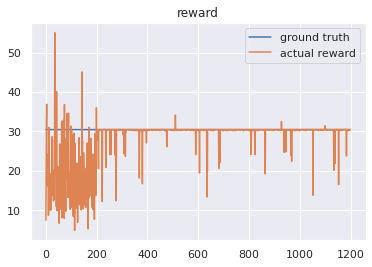

In [15]:
plt.plot([hwithoutconstraints(action)/(np.sqrt(args.card))**3]*T)
plt.plot(model.rewards_list)
plt.legend(['ground truth','actual reward'])
plt.title('reward')

In [16]:
plt.plot(model.feasi)
plt.title('infeasibility')

Text(0.5, 1.0, 'infeasibility')

Text(0.5, 1.0, 'reward')

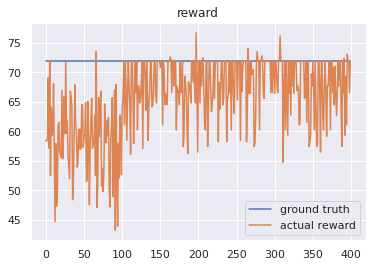

In [207]:
plt.plot([hwithoutconstraints(action)/(np.sqrt(args.card))]*T)
plt.plot(model.rewards_list)
plt.legend(['ground truth','actual reward'])
plt.title('reward')

Text(0.5, 1.0, 'infeasibility')

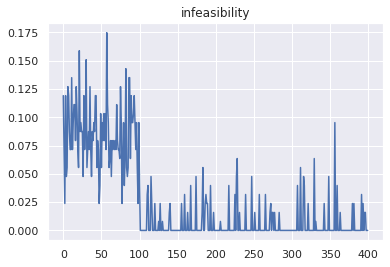

In [208]:
plt.plot(model.feasi)
plt.title('infeasibility')

In [209]:
hwithoutconstraints(action)/(np.sqrt(args.card))

71.87235975985492